# Does DC Capital Bikeshare fairly accomodate users from different income levels?

------------------

# Data Processing

## Importing DC Capital Bikeshare datasets

In [1]:
#import the modules
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy import stats
import seaborn as sns #for styling the plots
import glob
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf

In [2]:
from scipy.stats import norm #normal
from scipy.stats import genextreme as gev #generalized extreme value
from scipy.stats import pareto #pareto

In [3]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

In [4]:
#import data 2018-Mar 2020
path = r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\oldbike"

all_files = glob.glob(os.path.join(path, "20*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
dcbike1   = pd.concat(df_from_each_file, ignore_index=True)
dcbike1.to_csv( "dcbike1.csv")

In [5]:
#import data Apr 2020-Sep 2022
path = r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\newbike"

all_files2 = glob.glob(os.path.join(path, "202*.csv"))
df_from_each_file2 = (pd.read_csv(f, sep=',',low_memory=False) for f in all_files2)
dcbike2   = pd.concat(df_from_each_file2, ignore_index=True)
dcbike2.to_csv( "dcbike2.csv")

## Data Cleaning - 2018-2022 bike rides

In [6]:
dcbike1.head()
# has data only Jan 2018- Mar 2020.
# data types change afterwards, more features get available.
# here we have the start and end date which can be joined with later data to make a time-series analysis. 
# bike number and ride_id don't match.


Duration           Start date             End date  Start station number  \
0       552  2018-01-01 00:05:06  2018-01-01 00:14:18                 31104   
1      1282  2018-01-01 00:14:30  2018-01-01 00:35:53                 31321   
2      1265  2018-01-01 00:14:53  2018-01-01 00:35:58                 31321   
3       578  2018-01-01 00:15:31  2018-01-01 00:25:09                 31406   
4       372  2018-01-01 00:18:02  2018-01-01 00:24:15                 31618   

                   Start station  End station number  \
0    Adams Mill & Columbia Rd NW               31400   
1  15th St & Constitution Ave NW               31321   
2  15th St & Constitution Ave NW               31321   
3            14th & Upshur St NW               31103   
4       4th & East Capitol St NE               31619   

                                 End station Bike number Member type  
0             Georgia & New Hampshire Ave NW      W00886      Member  
1              15th St & Constitution Ave NW      W01435      Casual  
2              15th St & Constitution Ave NW      W21242      Casual  
3                       16th & Harvard St NW      W21322      Casual  
4  Lincoln Park / 13th & East Capitol St NE       W00119      Member

In [7]:
dcbike1.dtypes

Duration                 int64
Start date              object
End date                object
Start station number     int64
Start station           object
End station number       int64
End station             object
Bike number             object
Member type             object
dtype: object

In [8]:
dcbike1[['Start date','End date']] = dcbike1[['Start date','End date']].apply(pd.to_datetime, errors = 'coerce')

In [9]:
(dcbike1['Start date'].min(), dcbike1['End date'].max())

(Timestamp('2018-01-01 00:05:06'), Timestamp('2020-04-01 17:13:27'))

In [10]:
dcbike1.dtypes

Duration                         int64
Start date              datetime64[ns]
End date                datetime64[ns]
Start station number             int64
Start station                   object
End station number               int64
End station                     object
Bike number                     object
Member type                     object
dtype: object

In [11]:
(dcbike1['Start date'] == 0).sum()

0

In [12]:
(dcbike1['Duration'] == 0).sum()

0

In [13]:
dcbike1['Member type'].value_counts()

Member    6249302
Casual    1229199
Name: Member type, dtype: int64

In [14]:
dcbike2.head()

ride_id rideable_type           started_at             ended_at  \
0  77A0F1B26D1597B1   docked_bike  2020-04-25 17:28:39  2020-04-25 17:35:04   
1  8698F10128EA4F18   docked_bike  2020-04-06 07:54:59  2020-04-06 07:57:24   
2  AA07819DC0F58872   docked_bike  2020-04-22 17:06:18  2020-04-22 18:08:32   
3  DA909BCA92EF85AB   docked_bike  2020-04-16 15:22:40  2020-04-16 15:58:37   
4  B36F1E14D8C6757E   docked_bike  2020-04-10 13:19:41  2020-04-10 13:23:05   

                  start_station_name start_station_id  \
0  Rhode Island & Connecticut Ave NW            31239   
1                     21st & I St NW            31205   
2     Connecticut Ave & Tilden St NW            31313   
3                      7th & E St SW            31294   
4      Potomac & Pennsylvania Ave SE            31606   

                 end_station_name end_station_id  start_lat  start_lng  \
0                  12th & L St NW        31251.0  38.905996 -77.039802   
1                  18th & L St NW        31224.0  38.900711 -77.046449   
2  Connecticut Ave & Tilden St NW        31313.0  38.941139 -77.061977   
3                   7th & E St SW        31294.0  38.883450 -77.021741   
4  8th & Eye St SE / Barracks Row        31608.0  38.880300 -76.986200   

     end_lat    end_lng member_casual  
0  38.903819 -77.028400        casual  
1  38.903741 -77.042452        member  
2  38.941139 -77.061977        casual  
3  38.883450 -77.021741        casual  
4  38.879200 -76.995300        member

In [15]:
dcbike2.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [16]:
dcbike2[['started_at','ended_at']] = dcbike2[['started_at','ended_at']].apply(pd.to_datetime, errors = 'coerce')

In [17]:
(dcbike2['started_at'].min(), dcbike2['started_at'].max())

(Timestamp('2020-04-01 00:25:48'), Timestamp('2022-09-30 23:59:27'))

#### 2018-2022 bike trips join for all trips of Capital Bikeshare (will be used only for time-series)

In [18]:
dcbike1_join = dcbike1[['Start date','End date','Member type']]
dcbike1_join = dcbike1_join.rename(columns={"Start date":"started_at",'End date':'ended_at','Member type': 'member_casual'})
dcbike2_join = dcbike2[['started_at','ended_at','member_casual']]

In [19]:
dcbike1_join.dtypes

started_at       datetime64[ns]
ended_at         datetime64[ns]
member_casual            object
dtype: object

In [20]:
dcbike2_join.dtypes

started_at       datetime64[ns]
ended_at         datetime64[ns]
member_casual            object
dtype: object

In [21]:
bike_18_22 = pd.concat([dcbike1_join,dcbike2_join])

In [22]:
bike_18_22.head()

started_at            ended_at member_casual
0 2018-01-01 00:05:06 2018-01-01 00:14:18        Member
1 2018-01-01 00:14:30 2018-01-01 00:35:53        Casual
2 2018-01-01 00:14:53 2018-01-01 00:35:58        Casual
3 2018-01-01 00:15:31 2018-01-01 00:25:09        Casual
4 2018-01-01 00:18:02 2018-01-01 00:24:15        Member

In [23]:
bike_18_22.dtypes

started_at       datetime64[ns]
ended_at         datetime64[ns]
member_casual            object
dtype: object

In [24]:
# member casual type 
bike_18_22['member_casual'].unique()

array(['Member', 'Casual', 'casual', 'member'], dtype=object)

In [25]:
bike_18_22['member_casual'] = bike_18_22['member_casual'].replace(['Member'], 'member')
bike_18_22['member_casual'] = bike_18_22['member_casual'].replace(['Casual'], 'casual')
bike_18_22['member_casual'].unique()

array(['member', 'casual'], dtype=object)

In [26]:
#add column: duration
bike_18_22['duration'] = bike_18_22['ended_at'] - bike_18_22['started_at']
bike_18_22['duration'] = bike_18_22['duration'].dt.total_seconds()/60

In [27]:
bike_18_22['duration'].min(), bike_18_22['duration'].max()

(-29063.883333333335, 525817.2166666667)

In [28]:
# duration more than 1 min less than 100.
length = (bike_18_22.duration <= 100) & (bike_18_22.duration >= 1)
sum(~length)

406024

In [29]:
bike_18_22 = bike_18_22[length]

In [30]:
bike_18_22.reindex()

started_at            ended_at member_casual   duration
0       2018-01-01 00:05:06 2018-01-01 00:14:18        member   9.200000
1       2018-01-01 00:14:30 2018-01-01 00:35:53        casual  21.383333
2       2018-01-01 00:14:53 2018-01-01 00:35:58        casual  21.083333
3       2018-01-01 00:15:31 2018-01-01 00:25:09        casual   9.633333
4       2018-01-01 00:18:02 2018-01-01 00:24:15        member   6.216667
...                     ...                 ...           ...        ...
7137913 2022-09-28 20:54:43 2022-09-28 21:10:48        casual  16.083333
7137914 2022-09-29 19:20:18 2022-09-29 19:40:42        casual  20.400000
7137915 2022-09-20 18:44:53 2022-09-20 18:57:58        member  13.083333
7137916 2022-09-19 14:50:06 2022-09-19 15:14:55        member  24.816667
7137917 2022-09-02 08:01:14 2022-09-02 08:10:56        member   9.700000

[14210395 rows x 4 columns]

In [31]:
bike_18_22['duration'].min(), bike_18_22['duration'].max()

(1.0, 100.0)

## Data Cleaning and Sanity index filtering for 2020-2022 trips

In [32]:
dcbike2.head()

ride_id rideable_type          started_at            ended_at  \
0  77A0F1B26D1597B1   docked_bike 2020-04-25 17:28:39 2020-04-25 17:35:04   
1  8698F10128EA4F18   docked_bike 2020-04-06 07:54:59 2020-04-06 07:57:24   
2  AA07819DC0F58872   docked_bike 2020-04-22 17:06:18 2020-04-22 18:08:32   
3  DA909BCA92EF85AB   docked_bike 2020-04-16 15:22:40 2020-04-16 15:58:37   
4  B36F1E14D8C6757E   docked_bike 2020-04-10 13:19:41 2020-04-10 13:23:05   

                  start_station_name start_station_id  \
0  Rhode Island & Connecticut Ave NW            31239   
1                     21st & I St NW            31205   
2     Connecticut Ave & Tilden St NW            31313   
3                      7th & E St SW            31294   
4      Potomac & Pennsylvania Ave SE            31606   

                 end_station_name end_station_id  start_lat  start_lng  \
0                  12th & L St NW        31251.0  38.905996 -77.039802   
1                  18th & L St NW        31224.0  38.900711 -77.046449   
2  Connecticut Ave & Tilden St NW        31313.0  38.941139 -77.061977   
3                   7th & E St SW        31294.0  38.883450 -77.021741   
4  8th & Eye St SE / Barracks Row        31608.0  38.880300 -76.986200   

     end_lat    end_lng member_casual  
0  38.903819 -77.028400        casual  
1  38.903741 -77.042452        member  
2  38.941139 -77.061977        casual  
3  38.883450 -77.021741        casual  
4  38.879200 -76.995300        member

In [33]:
dcbike2['rideable_type'].unique()

array(['docked_bike', 'electric_bike', 'classic_bike'], dtype=object)

In [34]:
#keep only columns that will be used
dcbike = dcbike2[['ride_id','rideable_type','started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']]

In [35]:
dcbike

ride_id rideable_type          started_at  \
0        77A0F1B26D1597B1   docked_bike 2020-04-25 17:28:39   
1        8698F10128EA4F18   docked_bike 2020-04-06 07:54:59   
2        AA07819DC0F58872   docked_bike 2020-04-22 17:06:18   
3        DA909BCA92EF85AB   docked_bike 2020-04-16 15:22:40   
4        B36F1E14D8C6757E   docked_bike 2020-04-10 13:19:41   
...                   ...           ...                 ...   
7137913  9BC643AD58F0C8C9  classic_bike 2022-09-28 20:54:43   
7137914  83890E277F3C9A4F  classic_bike 2022-09-29 19:20:18   
7137915  D9A0A9E479262419  classic_bike 2022-09-20 18:44:53   
7137916  1DC8BF68CB04547F  classic_bike 2022-09-19 14:50:06   
7137917  DDA7BC16992B2A5F  classic_bike 2022-09-02 08:01:14   

                   ended_at  start_lat  start_lng    end_lat    end_lng  \
0       2020-04-25 17:35:04  38.905996 -77.039802  38.903819 -77.028400   
1       2020-04-06 07:57:24  38.900711 -77.046449  38.903741 -77.042452   
2       2020-04-22 18:08:32  38.941139 -77.061977  38.941139 -77.061977   
3       2020-04-16 15:58:37  38.883450 -77.021741  38.883450 -77.021741   
4       2020-04-10 13:23:05  38.880300 -76.986200  38.879200 -76.995300   
...                     ...        ...        ...        ...        ...   
7137913 2022-09-28 21:10:48  38.905711 -77.047318  38.905578 -77.027313   
7137914 2022-09-29 19:40:42  38.905711 -77.047318  38.890496 -77.017246   
7137915 2022-09-20 18:57:58  38.923330 -77.035200  38.905578 -77.027313   
7137916 2022-09-19 15:14:55  38.887320 -76.983569  38.890496 -77.017246   
7137917 2022-09-02 08:10:56  38.923330 -77.035200  38.905578 -77.027313   

        member_casual  
0              casual  
1              member  
2              casual  
3              casual  
4              member  
...               ...  
7137913        casual  
7137914        casual  
7137915        member  
7137916        member  
7137917        member  

[7137918 rows x 9 columns]

In [36]:
#add column: duration 
dcbike['duration'] = dcbike['ended_at'] - dcbike['started_at']
dcbike['duration'] = dcbike['duration'].dt.total_seconds()/60

In [37]:
# sanity index: length
dcbike['duration'].min(), dcbike['duration'].max()

(-29063.883333333335, 525817.2166666667)

In [38]:
# duration more than 2 min less than 45 (reasonable commute or leisure ride duration)
length = (dcbike.duration <= 45) & (dcbike.duration >= 2)
sum(~length)

828282

In [39]:
dcbike = dcbike[length]

In [40]:
# sanity index: length
dcbike['duration'].min(), dcbike['duration'].max()

(2.0, 45.0)

In [41]:
dcbike.isna().any()

ride_id          False
rideable_type    False
started_at       False
ended_at         False
start_lat         True
start_lng         True
end_lat           True
end_lng           True
member_casual    False
duration         False
dtype: bool

In [42]:
dcbike.shape

(6309636, 10)

In [43]:
dcbike.dropna(inplace=True)
dcbike.isna().any()

ride_id          False
rideable_type    False
started_at       False
ended_at         False
start_lat        False
start_lng        False
end_lat          False
end_lng          False
member_casual    False
duration         False
dtype: bool

In [44]:
dcbike.shape

(6305967, 10)

In [45]:
dcbike = dcbike.loc[((dcbike['end_lat'] != 0) | (dcbike['end_lng'] != 0))]
dcbike = dcbike.loc[((dcbike['start_lat'] != 0) | (dcbike['start_lng'] != 0))]

In [46]:
dcbike.shape

(6305966, 10)

In [47]:
dcbike = dcbike.reset_index(drop=True)
dcbike

ride_id rideable_type          started_at  \
0        77A0F1B26D1597B1   docked_bike 2020-04-25 17:28:39   
1        8698F10128EA4F18   docked_bike 2020-04-06 07:54:59   
2        DA909BCA92EF85AB   docked_bike 2020-04-16 15:22:40   
3        B36F1E14D8C6757E   docked_bike 2020-04-10 13:19:41   
4        3C10F9AE61844C89   docked_bike 2020-04-26 12:30:57   
...                   ...           ...                 ...   
6305961  9BC643AD58F0C8C9  classic_bike 2022-09-28 20:54:43   
6305962  83890E277F3C9A4F  classic_bike 2022-09-29 19:20:18   
6305963  D9A0A9E479262419  classic_bike 2022-09-20 18:44:53   
6305964  1DC8BF68CB04547F  classic_bike 2022-09-19 14:50:06   
6305965  DDA7BC16992B2A5F  classic_bike 2022-09-02 08:01:14   

                   ended_at  start_lat  start_lng    end_lat    end_lng  \
0       2020-04-25 17:35:04  38.905996 -77.039802  38.903819 -77.028400   
1       2020-04-06 07:57:24  38.900711 -77.046449  38.903741 -77.042452   
2       2020-04-16 15:58:37  38.883450 -77.021741  38.883450 -77.021741   
3       2020-04-10 13:23:05  38.880300 -76.986200  38.879200 -76.995300   
4       2020-04-26 12:34:15  38.880300 -76.986200  38.879200 -76.995300   
...                     ...        ...        ...        ...        ...   
6305961 2022-09-28 21:10:48  38.905711 -77.047318  38.905578 -77.027313   
6305962 2022-09-29 19:40:42  38.905711 -77.047318  38.890496 -77.017246   
6305963 2022-09-20 18:57:58  38.923330 -77.035200  38.905578 -77.027313   
6305964 2022-09-19 15:14:55  38.887320 -76.983569  38.890496 -77.017246   
6305965 2022-09-02 08:10:56  38.923330 -77.035200  38.905578 -77.027313   

        member_casual   duration  
0              casual   6.416667  
1              member   2.416667  
2              casual  35.950000  
3              member   3.400000  
4              member   3.300000  
...               ...        ...  
6305961        casual  16.083333  
6305962        casual  20.400000  
6305963        member  13.083333  
6305964        member  24.816667  
6305965        member   9.700000  

[6305966 rows x 10 columns]

In [48]:
dcbike['start_lng'].min(),dcbike['start_lng'].max()

(-77.39, -76.82)

In [49]:
dcbike['end_lng'].min(),dcbike['end_lng'].max()

(-77.41, -76.81)

In [50]:
dcbike['start_lat'].min(),dcbike['start_lat'].max()

(38.77, 39.13)

In [51]:
dcbike['end_lat'].min(),dcbike['end_lat'].max()

(38.72, 39.18)

In [52]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    haver_formula = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

    r = 6371 #6371 for distance in KM for miles use 3958.756
    dist = 2 * r * np.arcsin(np.sqrt(haver_formula))
    return pd.Series(dist)

In [53]:
dcbike['distance/km'] = haversine(dcbike['start_lng'], dcbike['start_lat'], dcbike['end_lng'], dcbike['end_lat'])

In [54]:
dcbike.head()

ride_id rideable_type          started_at            ended_at  \
0  77A0F1B26D1597B1   docked_bike 2020-04-25 17:28:39 2020-04-25 17:35:04   
1  8698F10128EA4F18   docked_bike 2020-04-06 07:54:59 2020-04-06 07:57:24   
2  DA909BCA92EF85AB   docked_bike 2020-04-16 15:22:40 2020-04-16 15:58:37   
3  B36F1E14D8C6757E   docked_bike 2020-04-10 13:19:41 2020-04-10 13:23:05   
4  3C10F9AE61844C89   docked_bike 2020-04-26 12:30:57 2020-04-26 12:34:15   

   start_lat  start_lng    end_lat    end_lng member_casual   duration  \
0  38.905996 -77.039802  38.903819 -77.028400        casual   6.416667   
1  38.900711 -77.046449  38.903741 -77.042452        member   2.416667   
2  38.883450 -77.021741  38.883450 -77.021741        casual  35.950000   
3  38.880300 -76.986200  38.879200 -76.995300        member   3.400000   
4  38.880300 -76.986200  38.879200 -76.995300        member   3.300000   

   distance/km  
0     1.015884  
1     0.482884  
2     0.000000  
3     0.797148  
4     0.797148

In [55]:
dcbike['distance/km'].min(), dcbike['distance/km'].max()

(0.0, 20.233936034428098)

In [56]:
dcbike = dcbike.loc[(dcbike['distance/km'] != 0)]

In [57]:
dcbike['distance/km'].min(), dcbike['distance/km'].max()

(4.3609816288025545e-06, 20.233936034428098)

In [58]:
dcbike['duration/hour'] =dcbike['duration']/60

In [59]:
# add column = speed
dcbike['speed'] = dcbike['distance/km'] / dcbike['duration/hour']

In [60]:
# speed 
dcbike.head()

ride_id rideable_type          started_at            ended_at  \
0  77A0F1B26D1597B1   docked_bike 2020-04-25 17:28:39 2020-04-25 17:35:04   
1  8698F10128EA4F18   docked_bike 2020-04-06 07:54:59 2020-04-06 07:57:24   
3  B36F1E14D8C6757E   docked_bike 2020-04-10 13:19:41 2020-04-10 13:23:05   
4  3C10F9AE61844C89   docked_bike 2020-04-26 12:30:57 2020-04-26 12:34:15   
5  361BF81F8528597B   docked_bike 2020-04-17 16:44:31 2020-04-17 16:47:44   

   start_lat  start_lng    end_lat    end_lng member_casual  duration  \
0  38.905996 -77.039802  38.903819 -77.028400        casual  6.416667   
1  38.900711 -77.046449  38.903741 -77.042452        member  2.416667   
3  38.880300 -76.986200  38.879200 -76.995300        member  3.400000   
4  38.880300 -76.986200  38.879200 -76.995300        member  3.300000   
5  38.880300 -76.986200  38.879200 -76.995300        member  3.216667   

   distance/km  duration/hour      speed  
0     1.015884       0.106944   9.499175  
1     0.482884       0.040278  11.988854  
3     0.797148       0.056667  14.067322  
4     0.797148       0.055000  14.493605  
5     0.797148       0.053611  14.869087

In [61]:
dcbike['speed'].min(), dcbike['speed'].max()
# what"s a good speed for bike? between 5 and 30 km/h.

(6.796335005926058e-06, 187.5716071422124)

In [62]:
dcbike = dcbike.loc[(dcbike['speed'] >= 5) & (dcbike['speed'] <= 30)]
dcbike['speed'].min(), dcbike['speed'].max()

(5.000005469021814, 29.990622599583368)

In [63]:
dcbike = dcbike.reset_index(drop=True)
dcbike

ride_id rideable_type          started_at  \
0        77A0F1B26D1597B1   docked_bike 2020-04-25 17:28:39   
1        8698F10128EA4F18   docked_bike 2020-04-06 07:54:59   
2        B36F1E14D8C6757E   docked_bike 2020-04-10 13:19:41   
3        3C10F9AE61844C89   docked_bike 2020-04-26 12:30:57   
4        361BF81F8528597B   docked_bike 2020-04-17 16:44:31   
...                   ...           ...                 ...   
5311759  9BC643AD58F0C8C9  classic_bike 2022-09-28 20:54:43   
5311760  83890E277F3C9A4F  classic_bike 2022-09-29 19:20:18   
5311761  D9A0A9E479262419  classic_bike 2022-09-20 18:44:53   
5311762  1DC8BF68CB04547F  classic_bike 2022-09-19 14:50:06   
5311763  DDA7BC16992B2A5F  classic_bike 2022-09-02 08:01:14   

                   ended_at  start_lat  start_lng    end_lat    end_lng  \
0       2020-04-25 17:35:04  38.905996 -77.039802  38.903819 -77.028400   
1       2020-04-06 07:57:24  38.900711 -77.046449  38.903741 -77.042452   
2       2020-04-10 13:23:05  38.880300 -76.986200  38.879200 -76.995300   
3       2020-04-26 12:34:15  38.880300 -76.986200  38.879200 -76.995300   
4       2020-04-17 16:47:44  38.880300 -76.986200  38.879200 -76.995300   
...                     ...        ...        ...        ...        ...   
5311759 2022-09-28 21:10:48  38.905711 -77.047318  38.905578 -77.027313   
5311760 2022-09-29 19:40:42  38.905711 -77.047318  38.890496 -77.017246   
5311761 2022-09-20 18:57:58  38.923330 -77.035200  38.905578 -77.027313   
5311762 2022-09-19 15:14:55  38.887320 -76.983569  38.890496 -77.017246   
5311763 2022-09-02 08:10:56  38.923330 -77.035200  38.905578 -77.027313   

        member_casual   duration  distance/km  duration/hour      speed  
0              casual   6.416667     1.015884       0.106944   9.499175  
1              member   2.416667     0.482884       0.040278  11.988854  
2              member   3.400000     0.797148       0.056667  14.067322  
3              member   3.300000     0.797148       0.055000  14.493605  
4              member   3.216667     0.797148       0.053611  14.869087  
...               ...        ...          ...            ...        ...  
5311759        casual  16.083333     1.731059       0.268056   6.457836  
5311760        casual  20.400000     3.103949       0.340000   9.129261  
5311761        member  13.083333     2.088499       0.218056   9.577828  
5311762        member  24.816667     2.936104       0.413611   7.098707  
5311763        member   9.700000     2.088499       0.161667  12.918548  

[5311764 rows x 13 columns]

## Income data per census tract

In [64]:
income_ct = gpd.read_file(r"C:\Users\ilgit\Downloads\Economic Characteristics of DC Census Tracts.csv")

In [65]:
income_ct.columns.values.tolist()

['Census Tract',
 'Area Land',
 'Area Water',
 'GEO Identifier',
 'EMPLOYMENT STATUS: Population 16 years and over',
 'EMPLOYMENT STATUS: Population 16 years and over: In labor force',
 'EMPLOYMENT STATUS: Population 16 years and over: In labor force: Civilian labor force',
 'EMPLOYMENT STATUS: Population 16 years and over: In labor force: Civilian labor force: Employed',
 'EMPLOYMENT STATUS: Population 16 years and over: In labor force: Civilian labor force: Unemployed',
 'EMPLOYMENT STATUS: Population 16 years and over: In labor force: Armed Forces',
 'EMPLOYMENT STATUS: Population 16 years and over: Not in labor force',
 'EMPLOYMENT STATUS: Civilian labor force',
 'EMPLOYMENT STATUS: Civilian labor force: Unemployment Rate',
 'EMPLOYMENT STATUS: Females 16 years and over',
 'EMPLOYMENT STATUS: Females 16 years and over: In labor force',
 'EMPLOYMENT STATUS: Females 16 years and over: In labor force: Civilian labor force',
 'EMPLOYMENT STATUS: Females 16 years and over: In labor forc

In [66]:
median_inc_ct = income_ct[['GEO Identifier','INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households',
                           'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households: Median household income (dollars)']]

In [67]:
median_inc_ct = median_inc_ct.rename(columns={'GEO Identifier': 'GEOID', 
                                              'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households' : 'Total Households',
                                              'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS): Total households: Median household income (dollars)' : 'Median Income'})


In [68]:
median_inc_ct

GEOID Total Households Median Income
0    11001000101              756        187839
1    11001000102             1762        184167
2    11001000201                0              
3    11001000202             1727        164261
4    11001000300             2377        156483
..           ...              ...           ...
201  11001010900             1146         39298
202  11001011001             1395        115114
203  11001011002             1205        105182
204  11001011100             1647         63625
205  11001980000                3              

[206 rows x 3 columns]

## Commuters' data per census tract

In [69]:
commute_ct = income_ct[['GEO Identifier','COMMUTING TO WORK: Workers 16 years and over',
                        'COMMUTING TO WORK: Workers 16 years and over: Car, truck, or van -- drove alone',
                        'COMMUTING TO WORK: Workers 16 years and over: Car, truck, or van -- carpooled',
                        'COMMUTING TO WORK: Workers 16 years and over: Public transportation (excluding taxicab)',
                        'COMMUTING TO WORK: Workers 16 years and over: Walked',
                        'COMMUTING TO WORK: Workers 16 years and over: Other means', 
                        'COMMUTING TO WORK: Workers 16 years and over: Worked from home',
                        'COMMUTING TO WORK: Workers 16 years and over: Mean travel time to work (minutes)']]

In [70]:
commute_ct = commute_ct.rename(columns={'GEO Identifier': 'GEOID', 
                                        'COMMUTING TO WORK: Workers 16 years and over': 'Total Commuters',
                                        'COMMUTING TO WORK: Workers 16 years and over: Car, truck, or van -- drove alone' : 'Drove alone',
                                        'COMMUTING TO WORK: Workers 16 years and over: Car, truck, or van -- carpooled' : 'Carpooled',
                                        'COMMUTING TO WORK: Workers 16 years and over: Public transportation (excluding taxicab)' : 'Used Public Transport',
                                        'COMMUTING TO WORK: Workers 16 years and over: Walked':'Walked',
                                        'COMMUTING TO WORK: Workers 16 years and over: Other means':'Used other means',
                                        'COMMUTING TO WORK: Workers 16 years and over: Worked from home': 'Worked From Home',
                                        'COMMUTING TO WORK: Workers 16 years and over: Mean travel time to work (minutes)':'Commute time: minutes'})
commute_ct

GEOID Total Commuters Drove alone Carpooled Used Public Transport  \
0    11001000101             769         246        88                    99   
1    11001000102            2150         709        18                   252   
2    11001000201            1302          90       109                    25   
3    11001000202            2814         809        77                   357   
4    11001000300            3935        1636       343                   595   
..           ...             ...         ...       ...                   ...   
201  11001010900            1418         460       218                   426   
202  11001011001            1801         631        36                   593   
203  11001011002            1108         273        42                   381   
204  11001011100            2090        1034       235                   535   
205  11001980000              13          10         0                     3   

    Walked Used other means Worked From Home Commute time: minutes  
0      181               67               88                  20.3  
1      364              158              649                  26.8  
2      886               57              135                  13.5  
3      882              130              559                  23.7  
4      623              240              498                  27.3  
..     ...              ...              ...                   ...  
201    203               69               42                  31.4  
202    147               55              339                  25.1  
203    168               75              169                  27.3  
204      0                8              278                  31.1  
205      0                0                0                        

[206 rows x 9 columns]

## Demographics data per census tract

In [71]:
demo_ct = gpd.read_file(r'C:\Users\ilgit\Downloads\Demographic Characteristics of DC Census Tracts.csv')

In [72]:
demo_ct.columns.values.tolist()

['Census Tract',
 'Area Land',
 'Area Water',
 'CITIZEN, VOTING AGE POPULATION: Citizen, 18 and over population',
 'CITIZEN, VOTING AGE POPULATION: Citizen, 18 and over population: Female',
 'CITIZEN, VOTING AGE POPULATION: Citizen, 18 and over population: Male',
 'GEO Identification',
 'HISPANIC OR LATINO AND RACE: Total population',
 'HISPANIC OR LATINO AND RACE: Total population: Hispanic or Latino (of any race)',
 'HISPANIC OR LATINO AND RACE: Total population: Hispanic or Latino (of any race): Cuban',
 'HISPANIC OR LATINO AND RACE: Total population: Hispanic or Latino (of any race): Mexican',
 'HISPANIC OR LATINO AND RACE: Total population: Hispanic or Latino (of any race): Other Hispanic or Latino',
 'HISPANIC OR LATINO AND RACE: Total population: Hispanic or Latino (of any race): Puerto Rican',
 'HISPANIC OR LATINO AND RACE: Total population: Not Hispanic or Latino',
 'HISPANIC OR LATINO AND RACE: Total population: Not Hispanic or Latino: American Indian and Alaska Native alone'

In [73]:
Pop_ct = demo_ct[['GEO Identification','SEX AND AGE: Total population']]
Pop_ct = Pop_ct.rename(columns={'SEX AND AGE: Total population': 'Population'})
Pop_ct

GEO Identification Population
0          11001000101       1250
1          11001000102       3318
2          11001000201       3972
3          11001000202       4665
4          11001000300       6504
..                 ...        ...
201        11001010900       3400
202        11001011001       2345
203        11001011002       1760
204        11001011100       5227
205        11001980000         13

[206 rows x 2 columns]

## Census tract shapefile

In [74]:
census_tract = gpd.read_file(r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\ACS_Demographic_Characteristics_DC_Census_Tract.shp")

In [75]:
census_tract[['ALAND', "AWATER"]]

ALAND  AWATER
0    271037    2414
1    194755       0
2    305616       0
3    204529       0
4    207646       0
..      ...     ...
201  648848       0
202  403051    3427
203  431384    7884
204  171910       0
205  229696       0

[206 rows x 2 columns]

<AxesSubplot: >

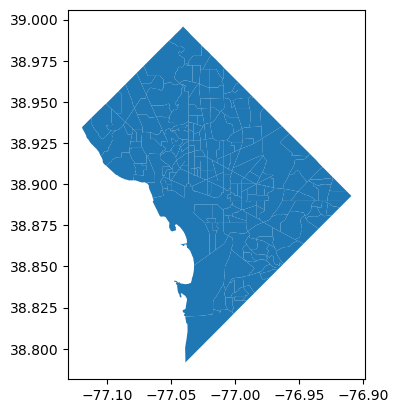

In [76]:
census_tract.plot()

In [77]:
census_tract = census_tract[['ALAND','TRACTCE','GEOID','NAME','geometry']]

In [78]:
census_tract

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
2    305616  003600  11001003600     36   
3    204529  004201  11001004201  42.01   
4    207646  004202  11001004202  42.02   
..      ...     ...          ...    ...   
201  648848  009509  11001009509  95.09   
202  403051  009700  11001009700     97   
203  431384  009801  11001009801  98.01   
204  171910  002801  11001002801  28.01   
205  229696  002802  11001002802  28.02   

                                              geometry  
0    POLYGON ((-77.05018 38.92125, -77.05006 38.921...  
1    POLYGON ((-77.04630 38.91632, -77.04630 38.916...  
2    POLYGON ((-77.03241 38.92658, -77.03217 38.926...  
3    POLYGON ((-77.04166 38.91418, -77.04166 38.914...  
4    POLYGON ((-77.04599 38.91451, -77.04574 38.914...  
..                                                 ...  
201  POLYGON ((-77.00201 38.95106, -77.00065 38.951...  
202  POLYGON ((-76.99486 38.82925, -76.99483 38.829...  
203  POLYGON ((-77.00386 38.83099, -77.00353 38.831...  
204  POLYGON ((-77.03646 38.93413, -77.03646 38.934...  
205  POLYGON ((-77.03671 38.92713, -77.03649 38.927...  

[206 rows x 5 columns]

______

# Exploratory analysis

# 1- Time-series

## Time-series analysis of total daily rides

(Explanation)

In [79]:
# date column
bike_18_22['Date'] = bike_18_22['started_at'].dt.date

In [80]:
bike_18_22 = bike_18_22.reset_index().rename({'index': 'ride_count'}, axis=1)

In [81]:
# time-series analysis
daily_rides = bike_18_22.groupby(by='Date', as_index=False).agg({'ride_count':'count'})
daily_rides.head()

Date  ride_count
0  2018-01-01        1196
1  2018-01-02        3767
2  2018-01-03        4727
3  2018-01-04        2367
4  2018-01-05        2702

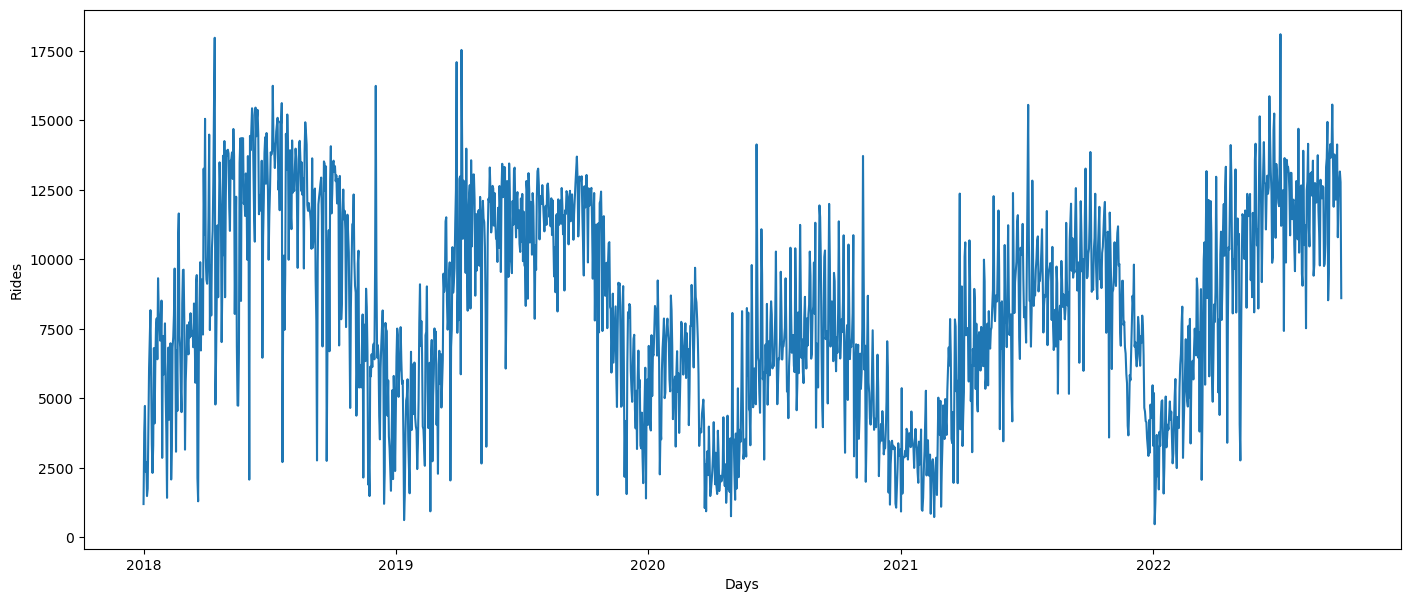

In [82]:
plt.figure(figsize=(17,7))
plt.plot(daily_rides.Date, daily_rides.ride_count)
plt.xlabel('Days')
plt.ylabel('Rides')
plt.show()

In [83]:
# smoothen the line and see the trend better using 30-days rolling average
daily_rides['MA'] = daily_rides.rolling(window=30)['ride_count'].mean()

In [84]:

N = 30
daily_rides = daily_rides.iloc[N: , :]
daily_rides = daily_rides.iloc[:-N , :]
daily_rides

Date  ride_count            MA
30    2018-01-31        6366   5541.000000
31    2018-02-01        7699   5672.066667
32    2018-02-02        5185   5687.333333
33    2018-02-03        3767   5734.000000
34    2018-02-04        1420   5691.266667
...          ...         ...           ...
1699  2022-08-27       13750  11807.033333
1700  2022-08-28       11743  11841.033333
1701  2022-08-29       10962  11716.333333
1702  2022-08-30        9782  11700.933333
1703  2022-08-31       12867  11733.833333

[1674 rows x 3 columns]

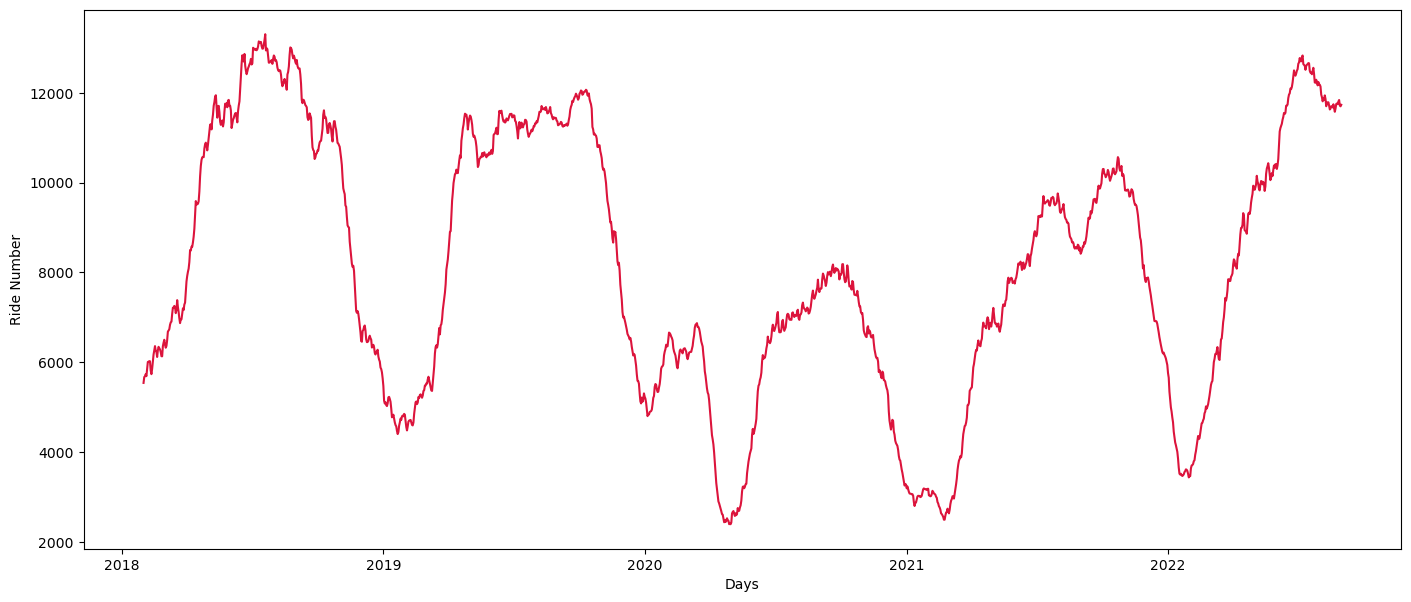

In [85]:
# visualize time-series analysis of daily ride numbers with rolling average
plt.figure(figsize=(17,7))
plt.plot(daily_rides.Date, daily_rides.MA, color="crimson")
plt.xlabel('Days')
plt.ylabel('Ride Number')
plt.show()

## Time-Series Analysis of daily rides: Member vs. Casual

In [86]:
bike_18_22

ride_count          started_at            ended_at member_casual  \
0                  0 2018-01-01 00:05:06 2018-01-01 00:14:18        member   
1                  1 2018-01-01 00:14:30 2018-01-01 00:35:53        casual   
2                  2 2018-01-01 00:14:53 2018-01-01 00:35:58        casual   
3                  3 2018-01-01 00:15:31 2018-01-01 00:25:09        casual   
4                  4 2018-01-01 00:18:02 2018-01-01 00:24:15        member   
...              ...                 ...                 ...           ...   
14210390     7137913 2022-09-28 20:54:43 2022-09-28 21:10:48        casual   
14210391     7137914 2022-09-29 19:20:18 2022-09-29 19:40:42        casual   
14210392     7137915 2022-09-20 18:44:53 2022-09-20 18:57:58        member   
14210393     7137916 2022-09-19 14:50:06 2022-09-19 15:14:55        member   
14210394     7137917 2022-09-02 08:01:14 2022-09-02 08:10:56        member   

           duration        Date  
0          9.200000  2018-01-01  
1         21.383333  2018-01-01  
2         21.083333  2018-01-01  
3          9.633333  2018-01-01  
4          6.216667  2018-01-01  
...             ...         ...  
14210390  16.083333  2022-09-28  
14210391  20.400000  2022-09-29  
14210392  13.083333  2022-09-20  
14210393  24.816667  2022-09-19  
14210394   9.700000  2022-09-02  

[14210395 rows x 6 columns]

In [87]:
member = bike_18_22.loc[bike_18_22['member_casual'] == 'member']
casual = bike_18_22.loc[bike_18_22['member_casual'] == 'casual']

In [88]:
member.head()

ride_count          started_at            ended_at member_casual  \
0           0 2018-01-01 00:05:06 2018-01-01 00:14:18        member   
4           4 2018-01-01 00:18:02 2018-01-01 00:24:15        member   
5           5 2018-01-01 00:18:07 2018-01-01 00:24:17        member   
6           6 2018-01-01 00:19:07 2018-01-01 00:27:14        member   
7           7 2018-01-01 00:21:55 2018-01-01 00:48:50        member   

    duration        Date  
0   9.200000  2018-01-01  
4   6.216667  2018-01-01  
5   6.166667  2018-01-01  
6   8.116667  2018-01-01  
7  26.916667  2018-01-01

In [89]:
casual.head()

ride_count          started_at            ended_at member_casual  \
1            1 2018-01-01 00:14:30 2018-01-01 00:35:53        casual   
2            2 2018-01-01 00:14:53 2018-01-01 00:35:58        casual   
3            3 2018-01-01 00:15:31 2018-01-01 00:25:09        casual   
17          17 2018-01-01 00:34:17 2018-01-01 01:03:40        casual   
19          19 2018-01-01 00:37:18 2018-01-01 01:03:38        casual   

     duration        Date  
1   21.383333  2018-01-01  
2   21.083333  2018-01-01  
3    9.633333  2018-01-01  
17  29.383333  2018-01-01  
19  26.333333  2018-01-01

In [90]:
daily_rides_member = member.groupby(by='Date', as_index=False).agg({'ride_count':'count'})
daily_rides_member.head()

Date  ride_count
0  2018-01-01        1061
1  2018-01-02        3603
2  2018-01-03        4458
3  2018-01-04        2301
4  2018-01-05        2642

In [91]:
daily_rides_casual = casual.groupby(by='Date', as_index=False).agg({'ride_count':'count'})
daily_rides_casual.head()

Date  ride_count
0  2018-01-01         135
1  2018-01-02         164
2  2018-01-03         269
3  2018-01-04          66
4  2018-01-05          60

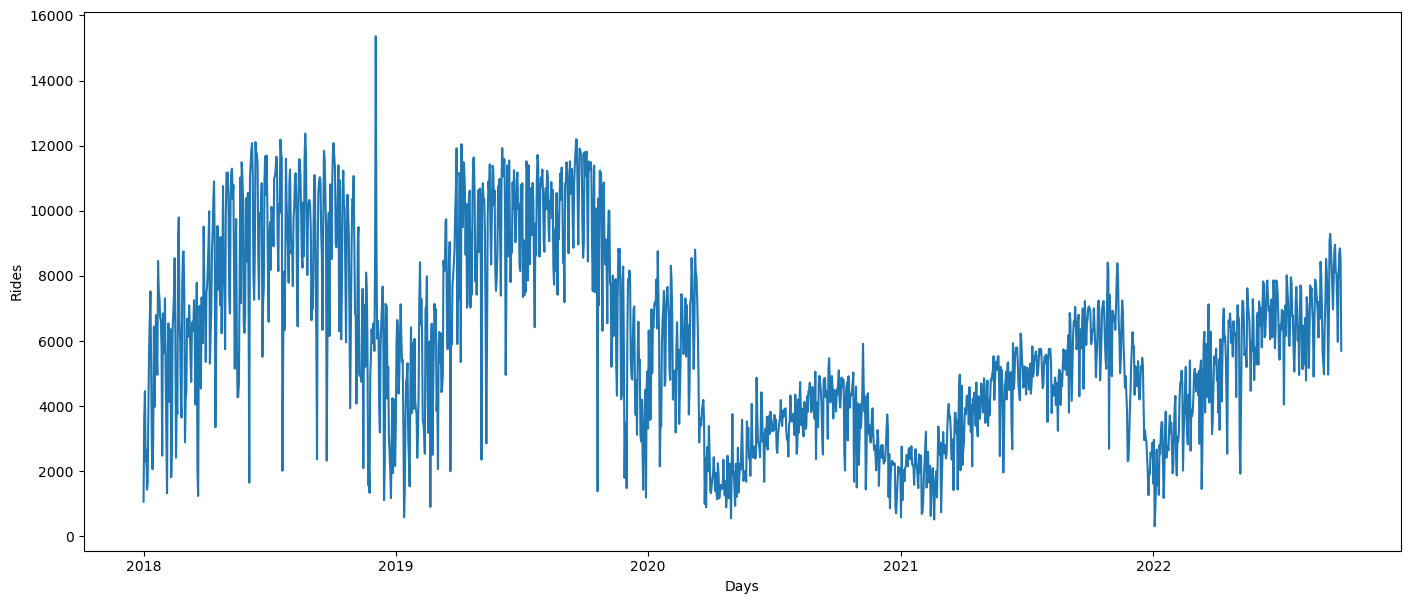

In [92]:
plt.figure(figsize=(17,7))
plt.plot(daily_rides_member.Date, daily_rides_member.ride_count)
plt.xlabel('Days')
plt.ylabel('Rides')
plt.show()

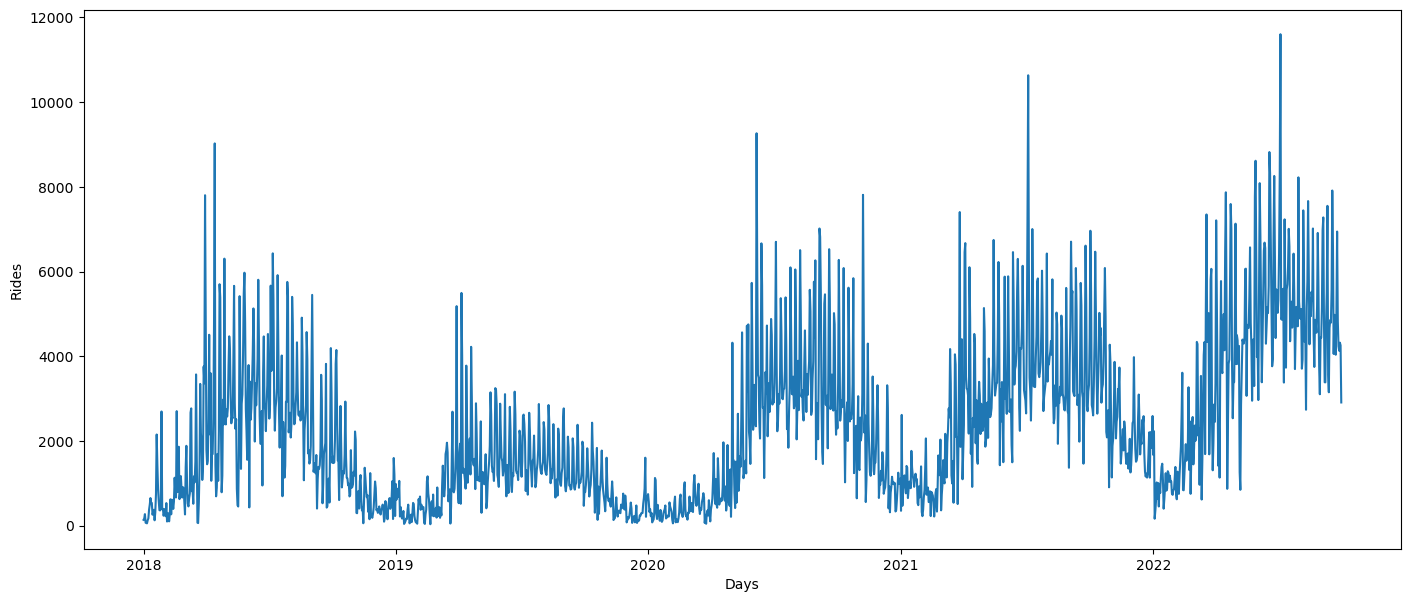

In [93]:
plt.figure(figsize=(17,7))
plt.plot(daily_rides_casual.Date, daily_rides_casual.ride_count)
plt.xlabel('Days')
plt.ylabel('Rides')
plt.show()

In [94]:
daily_rides_member['MA'] = daily_rides_member.rolling(window=30)['ride_count'].mean()

In [95]:
daily_rides_casual['MA'] = daily_rides_casual.rolling(window=30)['ride_count'].mean()

In [96]:
N = 30
daily_rides_member = daily_rides_member.iloc[N: , :]
daily_rides_member = daily_rides_member.iloc[:-N , :]
daily_rides_member

Date  ride_count           MA
30    2018-01-31        6051  5007.266667
31    2018-02-01        7307  5130.733333
32    2018-02-02        4965  5147.633333
33    2018-02-03        3237  5178.833333
34    2018-02-04        1325  5134.933333
...          ...         ...          ...
1699  2022-08-27        6839  6554.600000
1700  2022-08-28        6107  6557.600000
1701  2022-08-29        7207  6581.866667
1702  2022-08-30        6681  6639.400000
1703  2022-08-31        8430  6691.300000

[1674 rows x 3 columns]

In [97]:
N = 30
daily_rides_casual = daily_rides_casual.iloc[N: , :]
daily_rides_casual = daily_rides_casual.iloc[:-N , :]
daily_rides_casual

Date  ride_count           MA
30    2018-01-31         315   533.733333
31    2018-02-01         392   541.333333
32    2018-02-02         220   539.700000
33    2018-02-03         530   555.166667
34    2018-02-04          95   556.333333
...          ...         ...          ...
1699  2022-08-27        6911  5252.433333
1700  2022-08-28        5636  5283.433333
1701  2022-08-29        3755  5134.466667
1702  2022-08-30        3101  5061.533333
1703  2022-08-31        4437  5042.533333

[1674 rows x 3 columns]

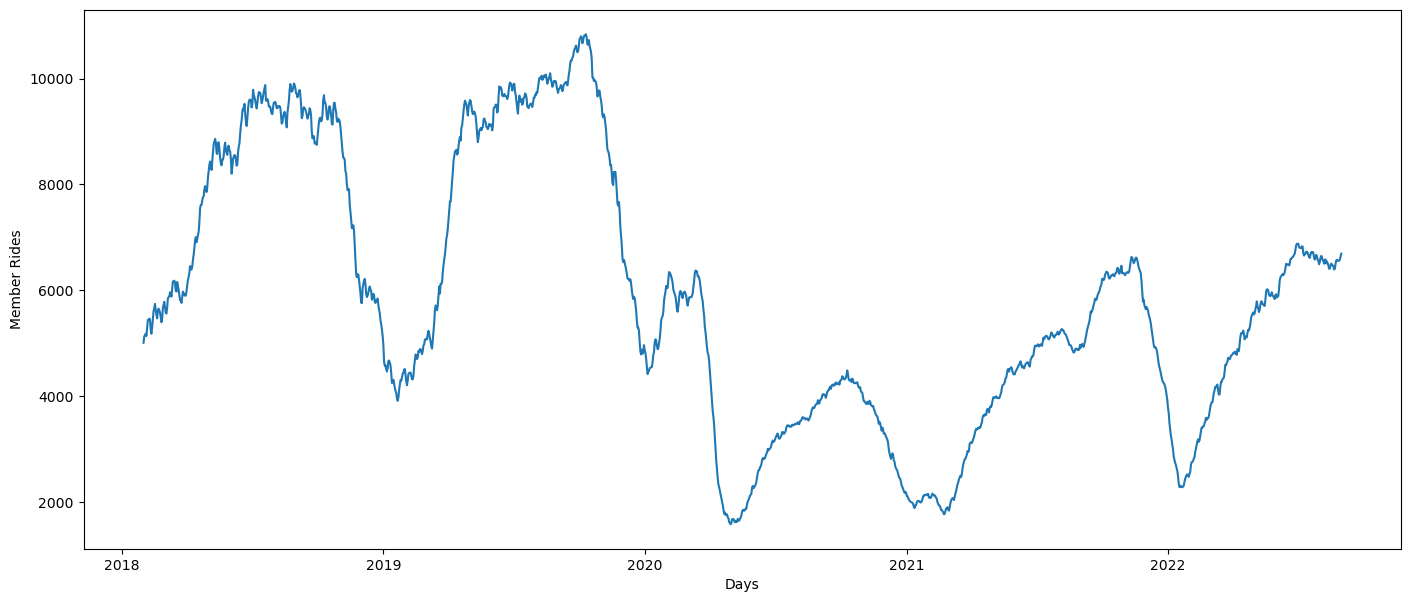

In [98]:
plt.figure(figsize=(17,7))
plt.plot(daily_rides_member.Date, daily_rides_member.MA)
plt.xlabel('Days')
plt.ylabel('Member Rides')
plt.show()

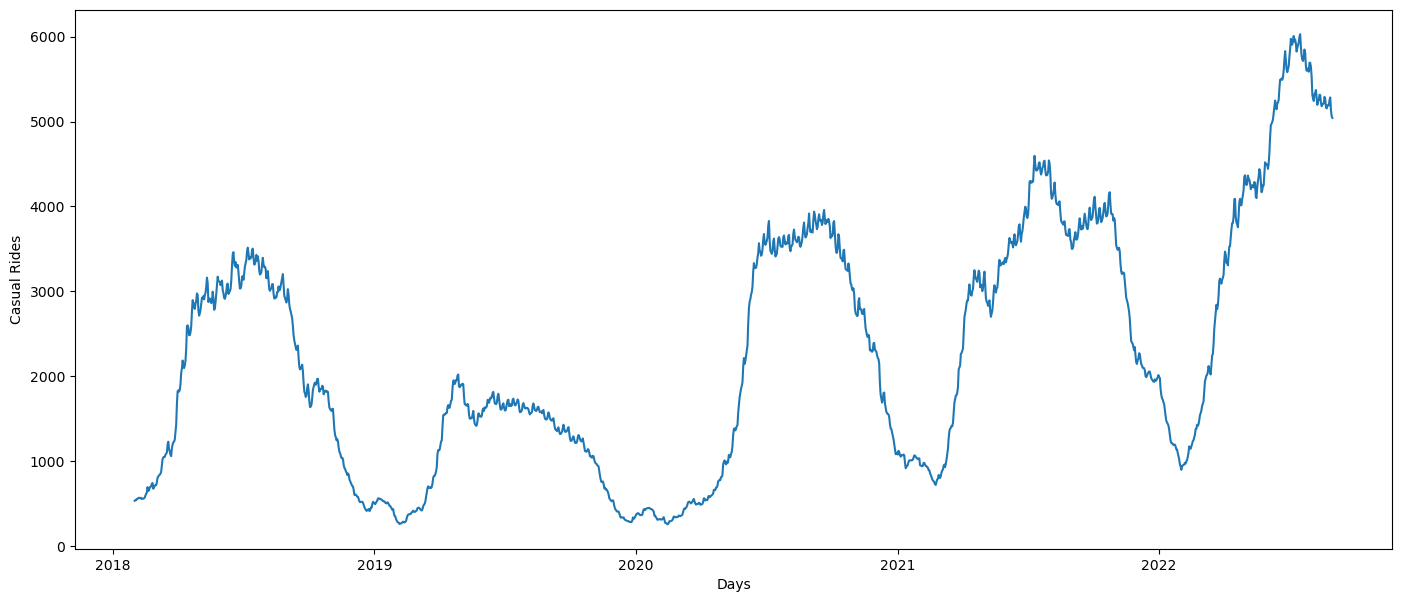

In [99]:
plt.figure(figsize=(17,7))
plt.plot(daily_rides_casual.Date, daily_rides_casual.MA)
plt.xlabel('Days')
plt.ylabel('Casual Rides')
plt.show()

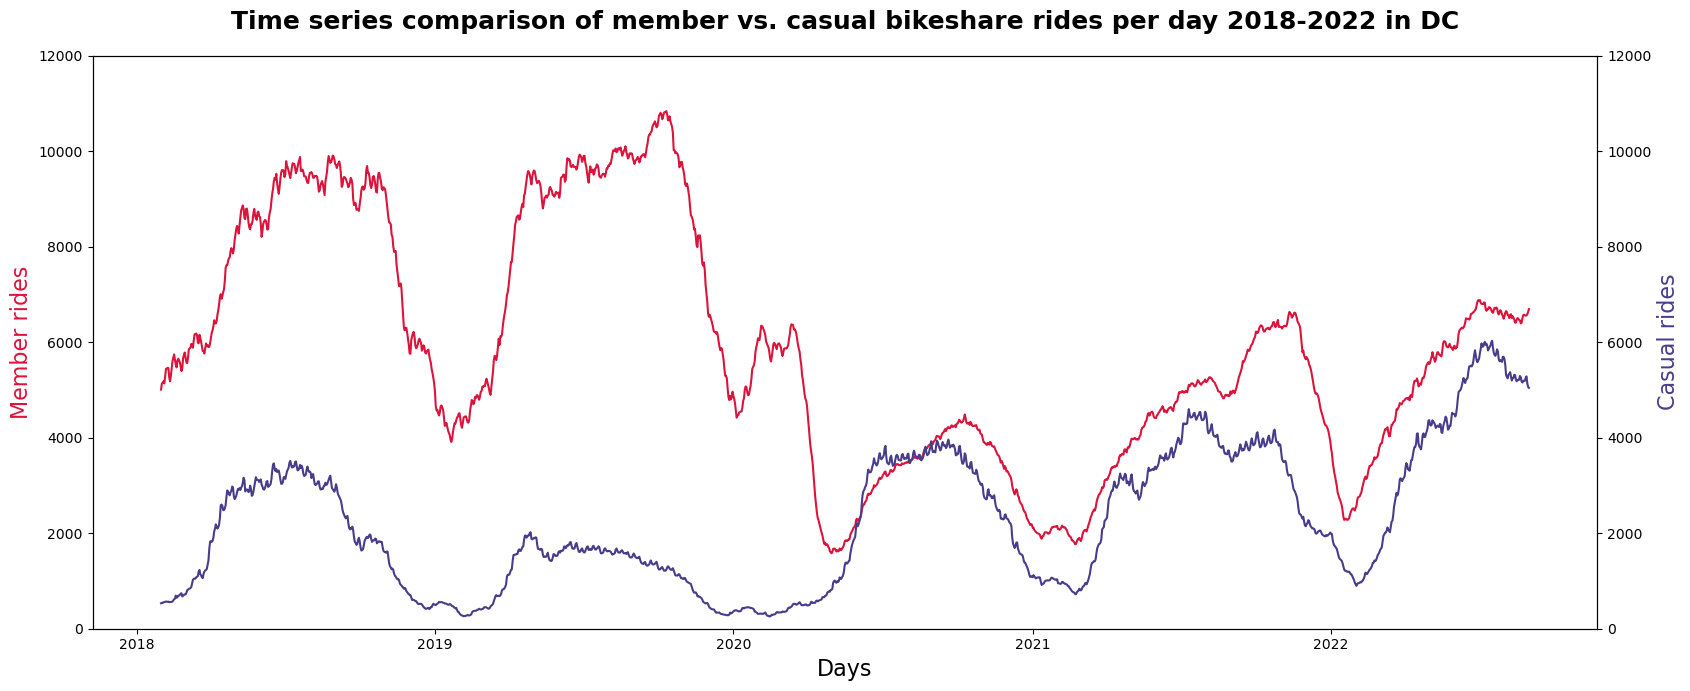

In [100]:
plt.rcParams["figure.figsize"] = [17, 7]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
ax1.plot(daily_rides_member.Date, daily_rides_member.MA,
        color="crimson")
ax2 = ax1.twinx()
ax2.plot(daily_rides_casual.Date, daily_rides_casual["MA"],color="darkslateblue")
ax1.set_xlabel('Days', fontsize=16)
ax1.set_ylabel('Member rides', color="crimson", fontsize=16)
ax2.set_ylabel('Casual rides' ,color="darkslateblue" , fontsize=16)


ymin, ymax = 0, 12000 
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

fig.suptitle('Time series comparison of member vs. casual bikeshare rides per day 2018-2022 in DC', fontsize= 18, fontweight ="bold")
fig.tight_layout()
plt.show()

## DOW, month of the year, hour of the day analyses - member vs. casual

In [101]:
member['DOW'] = member['started_at'].dt.dayofweek
member['month'] = member['started_at'].dt.month
member['hour'] = member['started_at'].dt.hour
member.head()

ride_count          started_at            ended_at member_casual  \
0           0 2018-01-01 00:05:06 2018-01-01 00:14:18        member   
4           4 2018-01-01 00:18:02 2018-01-01 00:24:15        member   
5           5 2018-01-01 00:18:07 2018-01-01 00:24:17        member   
6           6 2018-01-01 00:19:07 2018-01-01 00:27:14        member   
7           7 2018-01-01 00:21:55 2018-01-01 00:48:50        member   

    duration        Date  DOW  month  hour  
0   9.200000  2018-01-01    0      1     0  
4   6.216667  2018-01-01    0      1     0  
5   6.166667  2018-01-01    0      1     0  
6   8.116667  2018-01-01    0      1     0  
7  26.916667  2018-01-01    0      1     0

In [102]:
casual['DOW'] = casual['started_at'].dt.dayofweek
casual['month'] = casual['started_at'].dt.month
casual['hour'] = casual['started_at'].dt.hour
casual.head()

ride_count          started_at            ended_at member_casual  \
1            1 2018-01-01 00:14:30 2018-01-01 00:35:53        casual   
2            2 2018-01-01 00:14:53 2018-01-01 00:35:58        casual   
3            3 2018-01-01 00:15:31 2018-01-01 00:25:09        casual   
17          17 2018-01-01 00:34:17 2018-01-01 01:03:40        casual   
19          19 2018-01-01 00:37:18 2018-01-01 01:03:38        casual   

     duration        Date  DOW  month  hour  
1   21.383333  2018-01-01    0      1     0  
2   21.083333  2018-01-01    0      1     0  
3    9.633333  2018-01-01    0      1     0  
17  29.383333  2018-01-01    0      1     0  
19  26.333333  2018-01-01    0      1     0

In [103]:
member_month = member.groupby(by='month',as_index=False).agg({'ride_count':'count'}).rename({'ride_count': 'member'}, axis=1)
casual_month = casual.groupby(by='month',as_index=False).agg({'ride_count':'count'}).rename({'ride_count': 'casual'}, axis=1)
month = member_month.merge(casual_month, on='month')
month

month   member  casual
0       1   618510   97873
1       2   629206  111353
2       3   787617  265672
3       4   852103  385850
4       5   944340  455355
5       6  1030219  536734
6       7  1060321  576655
7       8  1093014  522343
8       9  1114606  472253
9      10   911835  295249
10     11   653039  172209
11     12   501571  122468

<AxesSubplot: ylabel='Ride Number'>

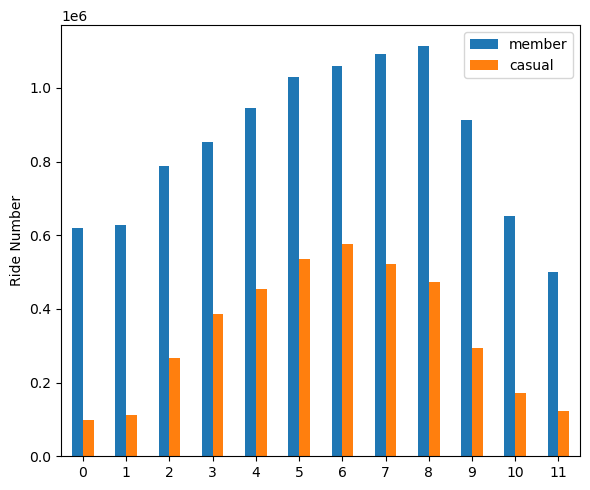

In [104]:
month.plot.bar(y=['member','casual'], ylabel="Ride Number", rot=0, figsize=(6, 5))

In [105]:
member_DOW = member.groupby(by='DOW',as_index=False).agg({'ride_count':'count'}).rename({'ride_count': 'member'}, axis=1)
casual_DOW = casual.groupby(by='DOW',as_index=False).agg({'ride_count':'count'}).rename({'ride_count': 'casual'}, axis=1)
DOW = member_DOW.merge(casual_DOW, on='DOW')
DOW

DOW   member  casual
0    0  1422627  466613
1    1  1570569  444582
2    2  1603291  455672
3    3  1560793  468177
4    4  1526246  568970
5    5  1344961  887973
6    6  1167894  722027

<AxesSubplot: ylabel='Ride Number'>

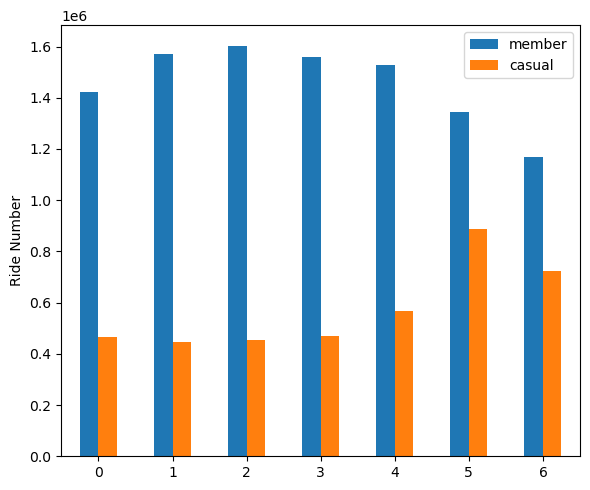

In [106]:
DOW.plot.bar(y=['member','casual'], ylabel="Ride Number", rot=0, figsize=(6, 5))

In [107]:
member_hour = member.groupby(by='hour',as_index=False).agg({'ride_count':'count'}).rename({'ride_count': 'member'}, axis=1)
casual_hour = casual.groupby(by='hour',as_index=False).agg({'ride_count':'count'}).rename({'ride_count': 'casual'}, axis=1)
hour = member_hour.merge(casual_hour, on='hour')
hour

hour   member  casual
0      0    81973   51113
1      1    45952   31380
2      2    28645   20291
3      3    15577   11058
4      4    19020    8256
5      5    76534   14840
6      6   240870   34536
7      7   553558   69776
8      8   885011  123964
9      9   558475  148955
10    10   421715  195444
11    11   475042  241903
12    12   553564  280060
13    13   546644  299344
14    14   534411  318769
15    15   612257  336442
16    16   769770  343543
17    17  1093504  373212
18    18   927665  330350
19    19   639995  258561
20    20   432320  185968
21    21   310483  139290
22    22   226005  114464
23    23   147391   82495

<AxesSubplot: ylabel='Ride Number'>

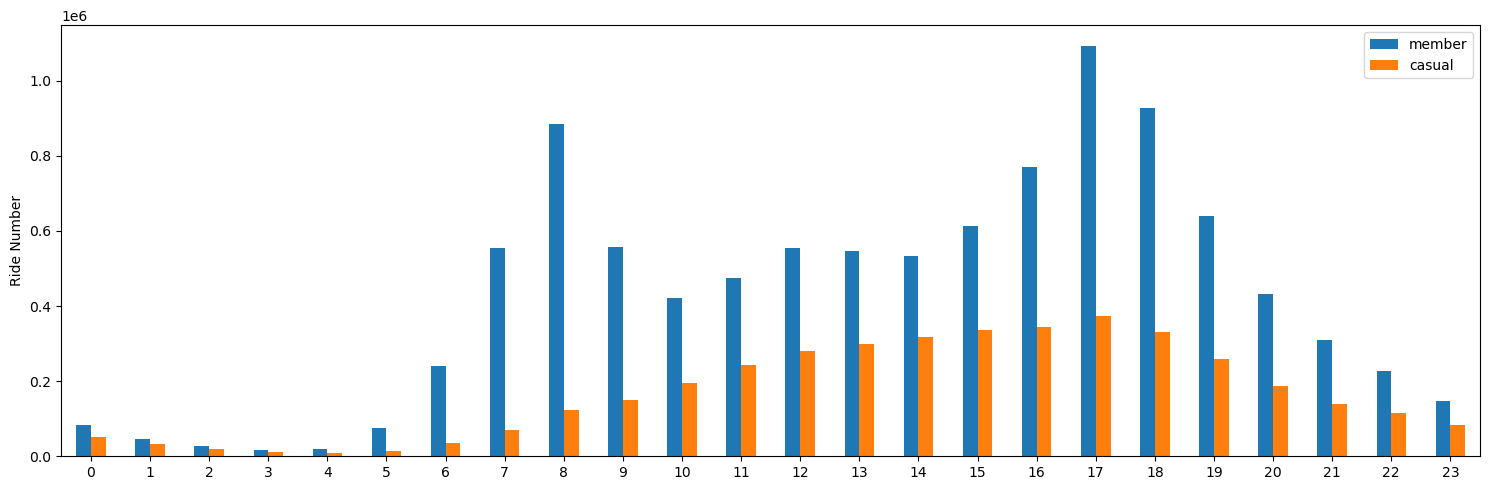

In [108]:
hour.plot.bar(y=['member','casual'], ylabel="Ride Number", rot=0, figsize=(15, 5))

## Duration analyses

In [109]:
bike_18_22

ride_count          started_at            ended_at member_casual  \
0                  0 2018-01-01 00:05:06 2018-01-01 00:14:18        member   
1                  1 2018-01-01 00:14:30 2018-01-01 00:35:53        casual   
2                  2 2018-01-01 00:14:53 2018-01-01 00:35:58        casual   
3                  3 2018-01-01 00:15:31 2018-01-01 00:25:09        casual   
4                  4 2018-01-01 00:18:02 2018-01-01 00:24:15        member   
...              ...                 ...                 ...           ...   
14210390     7137913 2022-09-28 20:54:43 2022-09-28 21:10:48        casual   
14210391     7137914 2022-09-29 19:20:18 2022-09-29 19:40:42        casual   
14210392     7137915 2022-09-20 18:44:53 2022-09-20 18:57:58        member   
14210393     7137916 2022-09-19 14:50:06 2022-09-19 15:14:55        member   
14210394     7137917 2022-09-02 08:01:14 2022-09-02 08:10:56        member   

           duration        Date  
0          9.200000  2018-01-01  
1         21.383333  2018-01-01  
2         21.083333  2018-01-01  
3          9.633333  2018-01-01  
4          6.216667  2018-01-01  
...             ...         ...  
14210390  16.083333  2022-09-28  
14210391  20.400000  2022-09-29  
14210392  13.083333  2022-09-20  
14210393  24.816667  2022-09-19  
14210394   9.700000  2022-09-02  

[14210395 rows x 6 columns]

In [110]:
# duration to integer - round number
bike_18_22['duration'] = bike_18_22['duration'].astype(int)
bike_18_22.head()

ride_count          started_at            ended_at member_casual  duration  \
0           0 2018-01-01 00:05:06 2018-01-01 00:14:18        member         9   
1           1 2018-01-01 00:14:30 2018-01-01 00:35:53        casual        21   
2           2 2018-01-01 00:14:53 2018-01-01 00:35:58        casual        21   
3           3 2018-01-01 00:15:31 2018-01-01 00:25:09        casual         9   
4           4 2018-01-01 00:18:02 2018-01-01 00:24:15        member         6   

         Date  
0  2018-01-01  
1  2018-01-01  
2  2018-01-01  
3  2018-01-01  
4  2018-01-01

In [111]:
bike_18_22_dur = bike_18_22.groupby(by='duration',as_index=False).agg({'ride_count':'count'})

In [112]:
bike_18_22_dur

duration  ride_count
0          1      170754
1          2      401684
2          3      629241
3          4      766858
4          5      821611
..       ...         ...
95        96        5990
96        97        6022
97        98        5948
98        99        5679
99       100         102

[100 rows x 2 columns]

In [113]:
bike_18_22_dur.describe()

duration     ride_count
count  100.000000     100.000000
mean    50.500000  142103.950000
std     29.011492  225834.530313
min      1.000000     102.000000
25%     25.750000   10514.250000
50%     50.500000   25462.500000
75%     75.250000  172142.250000
max    100.000000  823149.000000

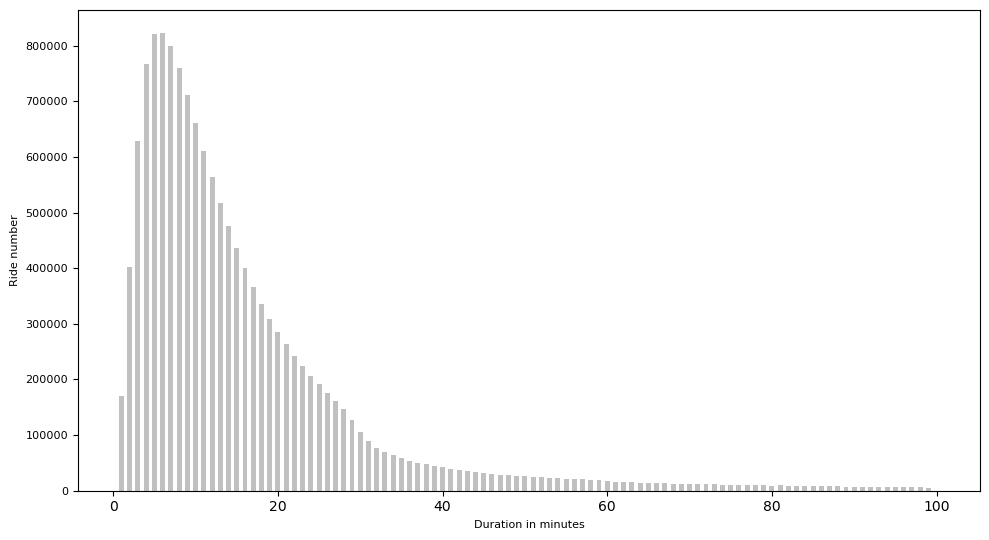

In [114]:
plt.figure(figsize=(10,5.5))
plt.bar(bike_18_22_dur.duration, bike_18_22_dur.ride_count, width=0.6, color = 'silver')
plt.yticks(fontsize=8)
plt.xlabel('Duration in minutes',fontsize=8)
plt.ylabel('Ride number',fontsize=8)
plt.show()

In [115]:
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles
    
    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x,p)))
        
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')
    
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    return pars

Mean = 15.88
Standard deviation = 14.93
1 percentile = 1.00
5 percentile = 3.00
25 percentile = 6.00
50 percentile = 11.00
75 percentile = 20.00
95 percentile = 46.00
99 percentile = 80.00


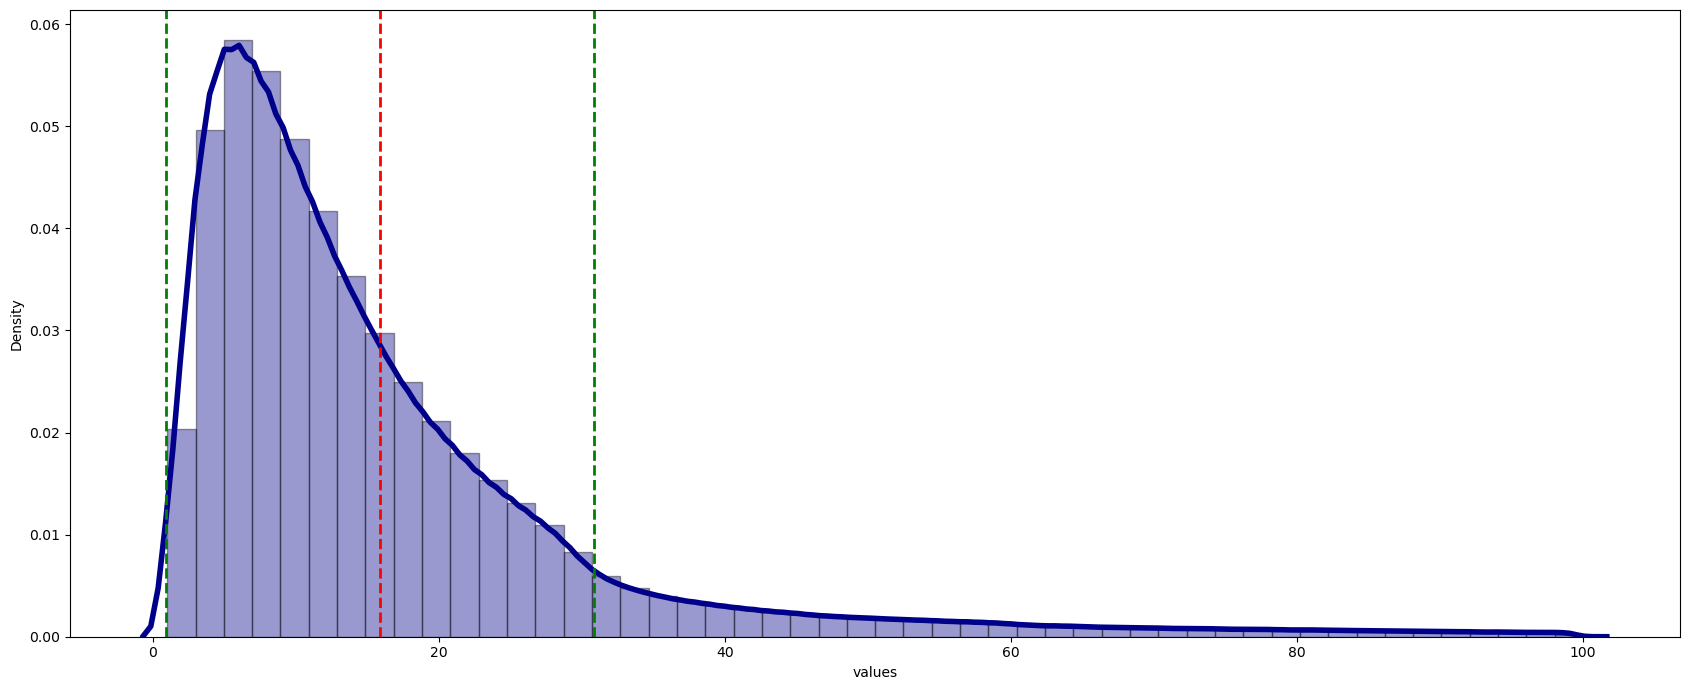

In [116]:
distribution_analysis(bike_18_22.duration)

# 2- Spatial Analysis

## Bikeshare activity density by start point per census tract - all rides

In [117]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(dcbike.start_lng, dcbike.start_lat)]

startLatLon = gpd.GeoDataFrame(dcbike[['ride_id', 'speed', 'distance/km', 'duration']],geometry=geometry,crs={'init': 'epsg:4326'})
startLatLon

ride_id      speed  distance/km   duration  \
0        77A0F1B26D1597B1   9.499175     1.015884   6.416667   
1        8698F10128EA4F18  11.988854     0.482884   2.416667   
2        B36F1E14D8C6757E  14.067322     0.797148   3.400000   
3        3C10F9AE61844C89  14.493605     0.797148   3.300000   
4        361BF81F8528597B  14.869087     0.797148   3.216667   
...                   ...        ...          ...        ...   
5311759  9BC643AD58F0C8C9   6.457836     1.731059  16.083333   
5311760  83890E277F3C9A4F   9.129261     3.103949  20.400000   
5311761  D9A0A9E479262419   9.577828     2.088499  13.083333   
5311762  1DC8BF68CB04547F   7.098707     2.936104  24.816667   
5311763  DDA7BC16992B2A5F  12.918548     2.088499   9.700000   

                           geometry  
0        POINT (-77.03980 38.90600)  
1        POINT (-77.04645 38.90071)  
2        POINT (-76.98620 38.88030)  
3        POINT (-76.98620 38.88030)  
4        POINT (-76.98620 38.88030)  
...                             ...  
5311759  POINT (-77.04732 38.90571)  
5311760  POINT (-77.04732 38.90571)  
5311761  POINT (-77.03520 38.92333)  
5311762  POINT (-76.98357 38.88732)  
5311763  POINT (-77.03520 38.92333)  

[5311764 rows x 5 columns]

In [118]:
geoStart = gpd.sjoin(startLatLon, census_tract, op='within', how='inner')

In [119]:
geoStart

ride_id      speed  distance/km   duration  \
0        77A0F1B26D1597B1   9.499175     1.015884   6.416667   
6        01D6659BA9B9E8F8   5.765413     1.484594  15.450000   
36       3F1A40AD1AC765B7  10.017351     0.651128   3.900000   
38       BEDEBBC250F51433  10.007612     2.076580  12.450000   
64       A48F9F959B230B74   9.376998     0.421965   2.700000   
...                   ...        ...          ...        ...   
5296449  E8F592D49C598C98   9.113920     5.106327  33.616667   
5300985  18644090FBA7984E   8.405746     3.138145  22.400000   
5302709  78633828381D1917  10.123027     2.772584  16.433333   
5302836  7786314DA0DBE7B7   9.015593     4.144669  27.583333   
5302838  EC70129955D8DE16  10.467565     0.619331   3.550000   

                           geometry  index_right   ALAND TRACTCE        GEOID  \
0        POINT (-77.03980 38.90600)            7  891588  010700  11001010700   
6        POINT (-77.03980 38.90600)            7  891588  010700  11001010700   
36       POINT (-77.03980 38.90600)            7  891588  010700  11001010700   
38       POINT (-77.03980 38.90600)            7  891588  010700  11001010700   
64       POINT (-77.04337 38.90220)            7  891588  010700  11001010700   
...                             ...          ...     ...     ...          ...   
5296449  POINT (-76.99267 38.92249)          164  391905  009302  11001009302   
5300985  POINT (-76.99267 38.92249)          164  391905  009302  11001009302   
5302709  POINT (-76.99267 38.92249)          164  391905  009302  11001009302   
5302836  POINT (-76.99267 38.92249)          164  391905  009302  11001009302   
5302838  POINT (-76.99267 38.92249)          164  391905  009302  11001009302   

          NAME  
0          107  
6          107  
36         107  
38         107  
64         107  
...        ...  
5296449  93.02  
5300985  93.02  
5302709  93.02  
5302836  93.02  
5302838  93.02  

[4729140 rows x 10 columns]

In [120]:
Rides_tract_start = geoStart.groupby('GEOID').agg({'ride_id':'count', 'speed':'mean', 'distance/km':'mean', 'duration': 'mean'})
Rides_tract_start.reset_index()

GEOID  ride_id      speed  distance/km   duration
0    11001000101        4  12.905267     4.201944  17.854167
1    11001000102   102496   9.813119     2.493637  16.070300
2    11001000201    23762  10.427737     2.415942  14.477027
3    11001000202    32781   9.798257     2.696232  17.140547
4    11001000300    14790  11.265032     2.831380  15.364372
..           ...      ...        ...          ...        ...
184  11001010900      210  12.105693     2.926162  15.788254
185  11001011001        1  13.492488     5.393247  23.983333
186  11001011002     1389  10.221306     2.523033  15.173146
187  11001011100     9736  10.952853     3.181275  18.678770
188  11001980000   260222   8.463948     2.391685  17.711453

[189 rows x 5 columns]

In [121]:
Rides_tract_start = census_tract.merge(Rides_tract_start,right_on='GEOID',left_on='GEOID')

In [122]:
Rides_tract_start

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
2    305616  003600  11001003600     36   
3    204529  004201  11001004201  42.01   
4    207646  004202  11001004202  42.02   
..      ...     ...          ...    ...   
184  962212  009508  11001009508  95.08   
185  648848  009509  11001009509  95.09   
186  431384  009801  11001009801  98.01   
187  171910  002801  11001002801  28.01   
188  229696  002802  11001002802  28.02   

                                              geometry  ride_id      speed  \
0    POLYGON ((-77.05018 38.92125, -77.05006 38.921...    21545  10.765476   
1    POLYGON ((-77.04630 38.91632, -77.04630 38.916...    50088  10.725445   
2    POLYGON ((-77.03241 38.92658, -77.03217 38.926...    29426  11.705430   
3    POLYGON ((-77.04166 38.91418, -77.04166 38.914...    62822  10.551960   
4    POLYGON ((-77.04599 38.91451, -77.04574 38.914...    25211   9.867378   
..                                                 ...      ...        ...   
184  POLYGON ((-77.00905 38.95334, -77.00905 38.953...     5397  10.116239   
185  POLYGON ((-77.00201 38.95106, -77.00065 38.951...     1323  12.497397   
186  POLYGON ((-77.00386 38.83099, -77.00353 38.831...      423  11.096774   
187  POLYGON ((-77.03646 38.93413, -77.03646 38.934...    20902  12.005382   
188  POLYGON ((-77.03671 38.92713, -77.03649 38.927...    15089  11.664094   

     distance/km   duration  
0       1.999325  11.892663  
1       1.945559  11.497122  
2       2.118711  11.379220  
3       1.662226  10.103636  
4       1.682447  10.771081  
..           ...        ...  
184     2.165534  12.663949  
185     2.960490  14.753578  
186     1.800861  10.568243  
187     2.419873  12.653614  
188     2.229143  12.019820  

[189 rows x 9 columns]

In [123]:
Rides_tract_start['Activity Density'] = Rides_tract_start['ride_id'] / Rides_tract_start['ALAND']
Rides_tract_start

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
2    305616  003600  11001003600     36   
3    204529  004201  11001004201  42.01   
4    207646  004202  11001004202  42.02   
..      ...     ...          ...    ...   
184  962212  009508  11001009508  95.08   
185  648848  009509  11001009509  95.09   
186  431384  009801  11001009801  98.01   
187  171910  002801  11001002801  28.01   
188  229696  002802  11001002802  28.02   

                                              geometry  ride_id      speed  \
0    POLYGON ((-77.05018 38.92125, -77.05006 38.921...    21545  10.765476   
1    POLYGON ((-77.04630 38.91632, -77.04630 38.916...    50088  10.725445   
2    POLYGON ((-77.03241 38.92658, -77.03217 38.926...    29426  11.705430   
3    POLYGON ((-77.04166 38.91418, -77.04166 38.914...    62822  10.551960   
4    POLYGON ((-77.04599 38.91451, -77.04574 38.914...    25211   9.867378   
..                                                 ...      ...        ...   
184  POLYGON ((-77.00905 38.95334, -77.00905 38.953...     5397  10.116239   
185  POLYGON ((-77.00201 38.95106, -77.00065 38.951...     1323  12.497397   
186  POLYGON ((-77.00386 38.83099, -77.00353 38.831...      423  11.096774   
187  POLYGON ((-77.03646 38.93413, -77.03646 38.934...    20902  12.005382   
188  POLYGON ((-77.03671 38.92713, -77.03649 38.927...    15089  11.664094   

     distance/km   duration  Activity Density  
0       1.999325  11.892663          0.079491  
1       1.945559  11.497122          0.257185  
2       2.118711  11.379220          0.096284  
3       1.662226  10.103636          0.307154  
4       1.682447  10.771081          0.121413  
..           ...        ...               ...  
184     2.165534  12.663949          0.005609  
185     2.960490  14.753578          0.002039  
186     1.800861  10.568243          0.000981  
187     2.419873  12.653614          0.121587  
188     2.229143  12.019820          0.065691  

[189 rows x 10 columns]

Text(0.5, 1.0, 'Bikeshare activity density by start point per census tract')

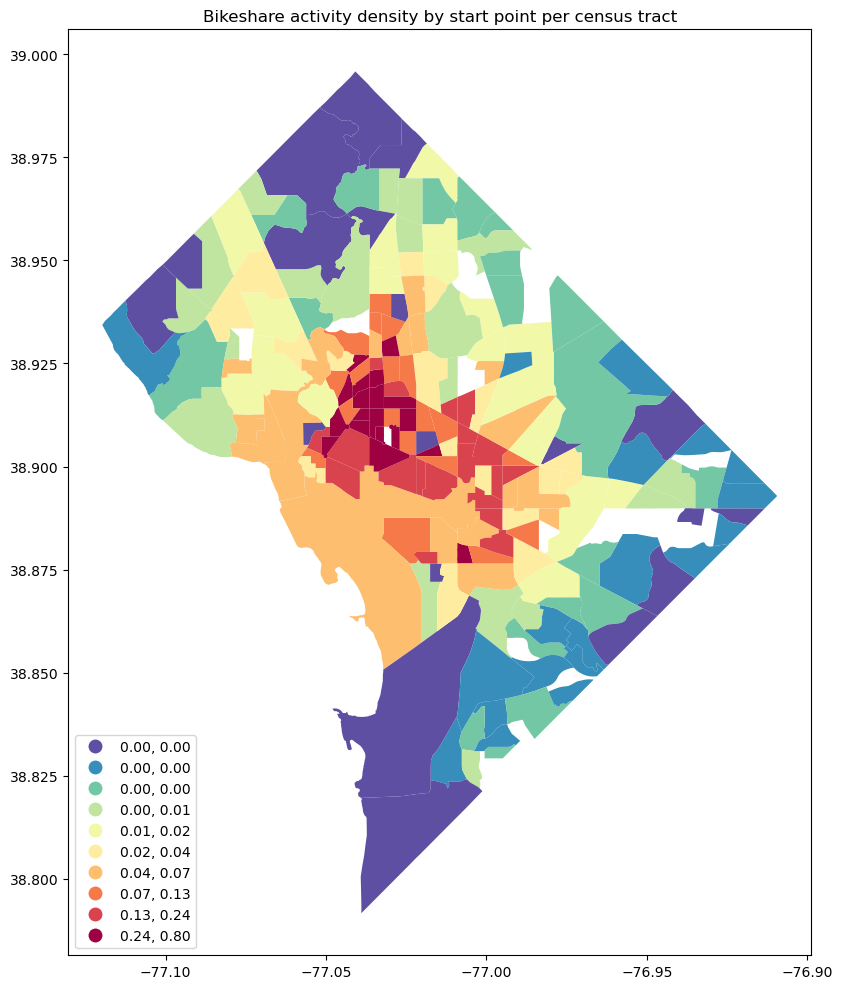

In [124]:
Rides_tract_start.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles',legend=True, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"} ,
                 legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Bikeshare activity density by start point per census tract')

## Bikeshare activity density by end point per census tract - all rides

In [115]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(dcbike.end_lng, dcbike.end_lat)]

endLatLon = gpd.GeoDataFrame(dcbike[['ride_id','speed', 'distance/km', 'duration']],geometry=geometry,crs={'init': 'epsg:4326'})
endLatLon

ride_id      speed  distance/km   duration  \
0        77A0F1B26D1597B1   9.499175     1.015884   6.416667   
1        8698F10128EA4F18  11.988854     0.482884   2.416667   
2        B36F1E14D8C6757E  14.067322     0.797148   3.400000   
3        3C10F9AE61844C89  14.493605     0.797148   3.300000   
4        361BF81F8528597B  14.869087     0.797148   3.216667   
...                   ...        ...          ...        ...   
5311759  9BC643AD58F0C8C9   6.457836     1.731059  16.083333   
5311760  83890E277F3C9A4F   9.129261     3.103949  20.400000   
5311761  D9A0A9E479262419   9.577828     2.088499  13.083333   
5311762  1DC8BF68CB04547F   7.098707     2.936104  24.816667   
5311763  DDA7BC16992B2A5F  12.918548     2.088499   9.700000   

                           geometry  
0        POINT (-77.02840 38.90382)  
1        POINT (-77.04245 38.90374)  
2        POINT (-76.99530 38.87920)  
3        POINT (-76.99530 38.87920)  
4        POINT (-76.99530 38.87920)  
...                             ...  
5311759  POINT (-77.02731 38.90558)  
5311760  POINT (-77.01725 38.89050)  
5311761  POINT (-77.02731 38.90558)  
5311762  POINT (-77.01725 38.89050)  
5311763  POINT (-77.02731 38.90558)  

[5311764 rows x 5 columns]

In [116]:
geoEnd = gpd.sjoin(endLatLon, census_tract, op='within', how='inner')

In [117]:
Rides_tract_end = geoEnd.groupby('GEOID').agg({'ride_id':'count', 'speed':'mean', 'distance/km':'mean', 'duration': 'mean'})
Rides_tract_end

ride_id      speed  distance/km   duration
GEOID                                                  
11001000101       51  14.030441     3.836833  17.348366
11001000102   124062  10.153221     2.502712  15.695828
11001000201    22329  10.251819     2.568597  15.635478
11001000202    43051  10.424676     2.885578  17.176117
11001000300    13994  11.905861     2.836665  14.943009
...              ...        ...          ...        ...
11001010800   132456   9.994594     2.050119  12.614730
11001010900      159  12.150469     3.529129  18.047484
11001011002     1874   9.896127     2.642451  16.424413
11001011100     9546  11.297757     3.160795  18.227898
11001980000   277508   8.970821     2.517415  17.724215

[191 rows x 4 columns]

In [118]:
Rides_tract_end = census_tract.merge(Rides_tract_end,right_on='GEOID',left_on='GEOID')

In [119]:
Rides_tract_end['Activity Density'] = Rides_tract_end['ride_id'] / Rides_tract_end['ALAND']
Rides_tract_end

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
2    305616  003600  11001003600     36   
3    204529  004201  11001004201  42.01   
4    207646  004202  11001004202  42.02   
..      ...     ...          ...    ...   
186  962212  009508  11001009508  95.08   
187  648848  009509  11001009509  95.09   
188  431384  009801  11001009801  98.01   
189  171910  002801  11001002801  28.01   
190  229696  002802  11001002802  28.02   

                                              geometry  ride_id      speed  \
0    POLYGON ((-77.05018 38.92125, -77.05006 38.921...    13622  10.592983   
1    POLYGON ((-77.04630 38.91632, -77.04630 38.916...    41212  10.129526   
2    POLYGON ((-77.03241 38.92658, -77.03217 38.926...    20483  10.693872   
3    POLYGON ((-77.04166 38.91418, -77.04166 38.914...    63723  10.643324   
4    POLYGON ((-77.04599 38.91451, -77.04574 38.914...    26845  10.251803   
..                                                 ...      ...        ...   
186  POLYGON ((-77.00905 38.95334, -77.00905 38.953...     4856  10.841030   
187  POLYGON ((-77.00201 38.95106, -77.00065 38.951...     1403  12.712930   
188  POLYGON ((-77.00386 38.83099, -77.00353 38.831...      438  11.234753   
189  POLYGON ((-77.03646 38.93413, -77.03646 38.934...    13867  10.804342   
190  POLYGON ((-77.03671 38.92713, -77.03649 38.927...    12285  10.587129   

     distance/km   duration  Activity Density  
0       2.048719  12.173939          0.050259  
1       1.859350  11.444805          0.211609  
2       2.010582  11.675484          0.067022  
3       1.620745   9.660975          0.311560  
4       1.739630  10.741656          0.129283  
..           ...        ...               ...  
186     2.103994  12.003134          0.005047  
187     2.783645  13.878582          0.002162  
188     1.562824   9.145396          0.001015  
189     2.261112  13.050102          0.080664  
190     2.230147  13.073043          0.053484  

[191 rows x 10 columns]

Text(0.5, 1.0, 'Bikeshare activity density by end point per census tract')

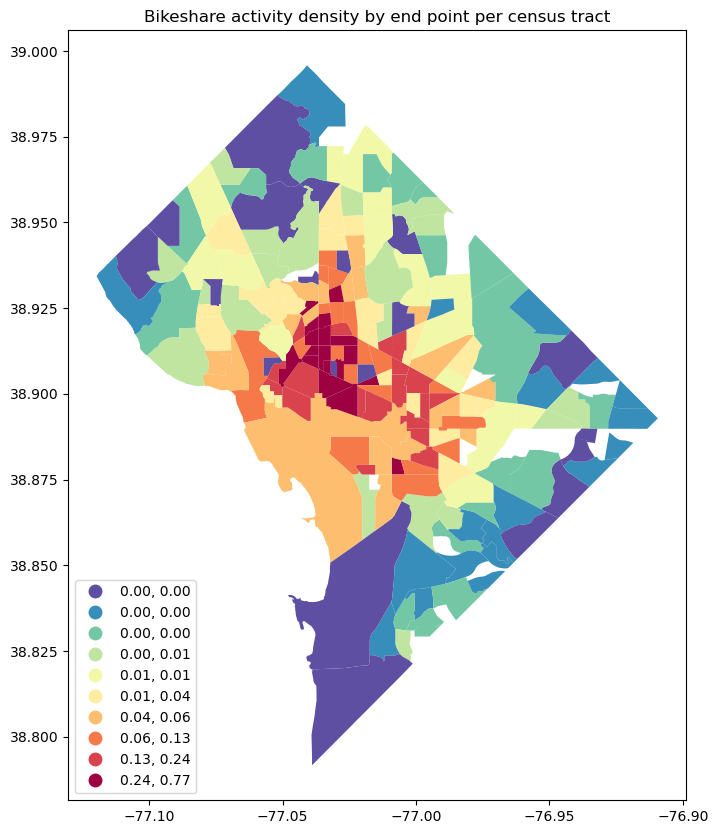

In [120]:
Rides_tract_end.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles',legend=True, missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values"} ,
                 legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Bikeshare activity density by end point per census tract')

In [121]:
# a major component that is significant in determining the density of bike use in the center vs. the boundary
# is the distance from the center. 

## Activity density by start/end point: member vs. casual

In [125]:
member2 = dcbike.loc[dcbike['member_casual'] == 'member']
casual2 = dcbike.loc[dcbike['member_casual'] == 'casual']

### Member activity density

In [126]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(member2.start_lng, member2.start_lat)]

startLatLon = gpd.GeoDataFrame(member2[['ride_id']],geometry=geometry,crs={'init': 'epsg:4326'})
startLatLon

ride_id                    geometry
1        8698F10128EA4F18  POINT (-77.04645 38.90071)
2        B36F1E14D8C6757E  POINT (-76.98620 38.88030)
3        3C10F9AE61844C89  POINT (-76.98620 38.88030)
4        361BF81F8528597B  POINT (-76.98620 38.88030)
5        8087C5803C444CA7  POINT (-77.04764 38.92320)
...                   ...                         ...
5311748  93716E6C043412EE  POINT (-77.03520 38.92333)
5311749  B9EC3CDE7ABF1B55  POINT (-76.98357 38.88732)
5311761  D9A0A9E479262419  POINT (-77.03520 38.92333)
5311762  1DC8BF68CB04547F  POINT (-76.98357 38.88732)
5311763  DDA7BC16992B2A5F  POINT (-77.03520 38.92333)

[3485174 rows x 2 columns]

In [127]:
geoStartmember = gpd.sjoin(startLatLon, census_tract, op='within', how='inner')

In [128]:
member_tract_start = geoStartmember.groupby('GEOID').agg({'ride_id':'count'})

In [129]:
member_tract_start = census_tract.merge(member_tract_start,right_on='GEOID',left_on='GEOID')

In [130]:
member_tract_start['Activity Density'] = member_tract_start['ride_id'] / member_tract_start['ALAND']

In [131]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(member2.end_lng, member2.end_lat)]

endLatLon = gpd.GeoDataFrame(member2[['ride_id']],geometry=geometry,crs={'init': 'epsg:4326'})
endLatLon

ride_id                    geometry
1        8698F10128EA4F18  POINT (-77.04245 38.90374)
2        B36F1E14D8C6757E  POINT (-76.99530 38.87920)
3        3C10F9AE61844C89  POINT (-76.99530 38.87920)
4        361BF81F8528597B  POINT (-76.99530 38.87920)
5        8087C5803C444CA7  POINT (-77.04368 38.92067)
...                   ...                         ...
5311748  93716E6C043412EE  POINT (-77.04157 38.91881)
5311749  B9EC3CDE7ABF1B55  POINT (-77.01725 38.89050)
5311761  D9A0A9E479262419  POINT (-77.02731 38.90558)
5311762  1DC8BF68CB04547F  POINT (-77.01725 38.89050)
5311763  DDA7BC16992B2A5F  POINT (-77.02731 38.90558)

[3485174 rows x 2 columns]

In [132]:
geoEndmember = gpd.sjoin(endLatLon, census_tract, op='within', how='inner')

In [133]:
member_tract_end = geoEndmember.groupby('GEOID').agg({'ride_id':'count'})

In [134]:
member_tract_end = census_tract.merge(member_tract_end,right_on='GEOID',left_on='GEOID')

In [135]:
member_tract_end['Activity Density'] = member_tract_end['ride_id'] / member_tract_end['ALAND']

Text(0.5, 1.0, 'By end point per census tract')

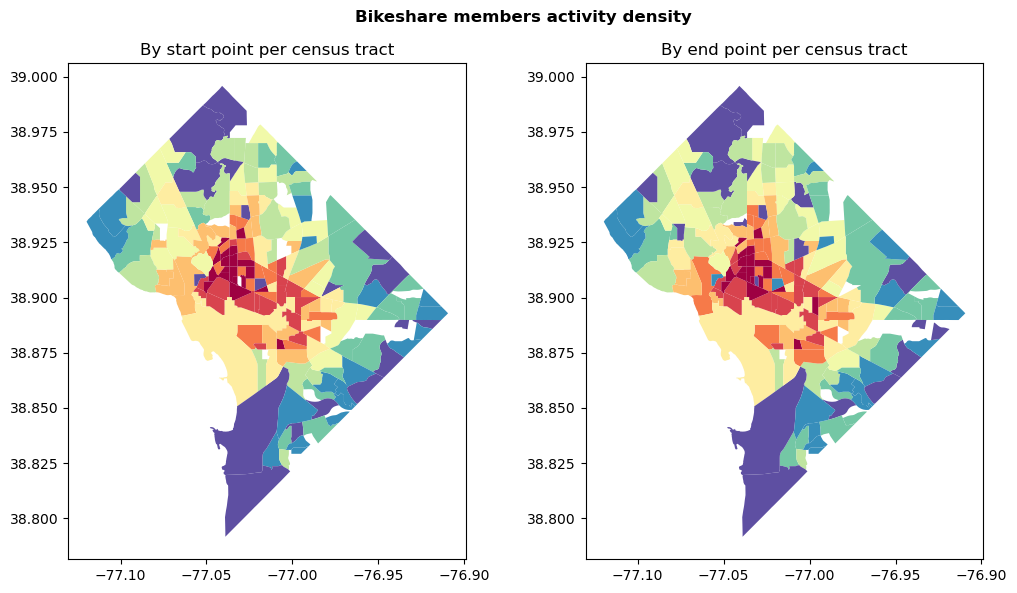

In [136]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2)
fig.suptitle("Bikeshare members activity density ", fontsize=12, fontweight ="bold" )

member_tract_start.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', ax=axes[0])
member_tract_end.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', ax=axes[1])

axes[0].set_title('By start point per census tract')
axes[1].set_title('By end point per census tract')

### Casual users' activity density

In [137]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(casual2.start_lng, casual2.start_lat)]

startLatLon = gpd.GeoDataFrame(casual2[['ride_id']],geometry=geometry,crs={'init': 'epsg:4326'})
startLatLon

ride_id                    geometry
0        77A0F1B26D1597B1  POINT (-77.03980 38.90600)
8        21E11004E625B42D  POINT (-77.04336 38.80472)
13       F2E1738BA018C85E  POINT (-76.98368 38.91560)
19       50EBB3C161753161  POINT (-76.98620 38.88030)
25       BDAD908F7140151B  POINT (-77.01981 38.95656)
...                   ...                         ...
5311756  ED5E82799D7A229F  POINT (-77.03222 38.92855)
5311757  203B22E782F92745  POINT (-77.03230 38.92852)
5311758  402B3053FBD5B8E2  POINT (-76.98357 38.88732)
5311759  9BC643AD58F0C8C9  POINT (-77.04732 38.90571)
5311760  83890E277F3C9A4F  POINT (-77.04732 38.90571)

[1826590 rows x 2 columns]

In [138]:
geoStartcasual = gpd.sjoin(startLatLon, census_tract, op='within', how='inner')

In [139]:
casual_tract_start =geoStartcasual.groupby('GEOID').agg({'ride_id':'count'})

In [140]:
casual_tract_start = census_tract.merge(casual_tract_start,right_on='GEOID',left_on='GEOID')

In [141]:
casual_tract_start['Activity Density'] = casual_tract_start['ride_id'] / casual_tract_start['ALAND']

In [142]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(casual2.end_lng,casual2.end_lat)]

endLatLon = gpd.GeoDataFrame(casual2[['ride_id']],geometry=geometry,crs={'init': 'epsg:4326'})
endLatLon

ride_id                    geometry
0        77A0F1B26D1597B1  POINT (-77.02840 38.90382)
8        21E11004E625B42D  POINT (-77.03951 38.86503)
13       F2E1738BA018C85E  POINT (-76.94745 38.89706)
19       50EBB3C161753161  POINT (-76.99540 38.88400)
25       BDAD908F7140151B  POINT (-77.02786 38.96134)
...                   ...                         ...
5311756  ED5E82799D7A229F  POINT (-77.02731 38.90558)
5311757  203B22E782F92745  POINT (-77.04157 38.91881)
5311758  402B3053FBD5B8E2  POINT (-77.01725 38.89050)
5311759  9BC643AD58F0C8C9  POINT (-77.02731 38.90558)
5311760  83890E277F3C9A4F  POINT (-77.01725 38.89050)

[1826590 rows x 2 columns]

In [143]:
geoEndcasual = gpd.sjoin(endLatLon, census_tract, op='within', how='inner')

In [144]:
casual_tract_end = geoEndcasual.groupby('GEOID').agg({'ride_id':'count'})

In [145]:
casual_tract_end = census_tract.merge(casual_tract_end,right_on='GEOID',left_on='GEOID')

In [146]:
casual_tract_end['Activity Density'] = casual_tract_end['ride_id'] / casual_tract_end['ALAND']

Text(0.5, 1.0, 'By end point per census tract')

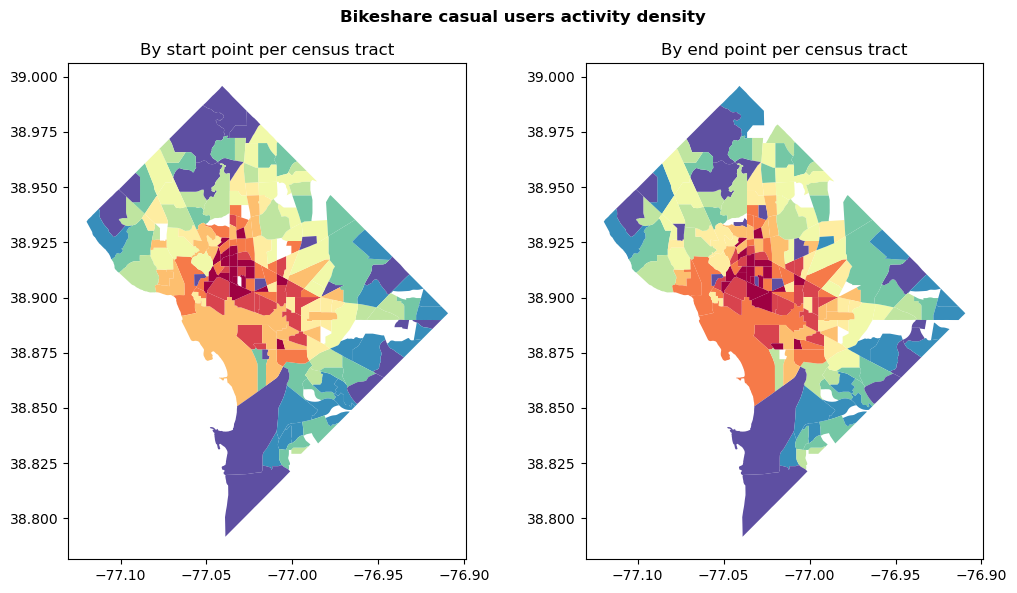

In [147]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2)
fig.suptitle("Bikeshare casual users activity density ", fontsize=12, fontweight ="bold" )

casual_tract_start.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', ax=axes[0])
casual_tract_end.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', ax=axes[1])

axes[0].set_title('By start point per census tract')
axes[1].set_title('By end point per census tract')

## Potential commuters' activity density, distance and speed by start point

In [148]:
member2['hour'] = member2['started_at'].dt.hour

In [149]:
commuter = member2.loc[(member2['hour'] == 8)| (member2['hour'] == 9)| (member2['hour'] == 7)| (member2['hour'] == 6)]

In [150]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(commuter.start_lng, commuter.start_lat)]

startLatLon = gpd.GeoDataFrame(commuter[['ride_id','distance/km','speed','duration']],geometry=geometry,crs={'init': 'epsg:4326'})
startLatLon

ride_id  distance/km      speed   duration  \
1        8698F10128EA4F18     0.482884  11.988854   2.416667   
22       6E4203B71BA7ACE2     1.729171  12.704112   8.166667   
23       2613B945D929CE44     3.049556   7.493789  24.416667   
33       886BF5AD01F9FDFA     0.730054  10.597559   4.133333   
39       98A3C8503AFCB58A     3.374664   6.120298  33.083333   
...                   ...          ...        ...        ...   
5311702  12E964A801EF7741     0.827911   9.142575   5.433333   
5311707  42F675981DB26C4E     1.457308   9.124015   9.583333   
5311732  0A4BB8CAAE873F10     0.905178  12.296764   4.416667   
5311745  54A9380AE41B7F63     1.722941   9.924142  10.416667   
5311763  DDA7BC16992B2A5F     2.088499  12.918548   9.700000   

                           geometry  
1        POINT (-77.04645 38.90071)  
22       POINT (-77.00314 38.89497)  
23       POINT (-77.00597 38.88492)  
33       POINT (-77.02379 38.92812)  
39       POINT (-76.98620 38.88030)  
...                             ...  
5311702  POINT (-77.03210 38.91776)  
5311707  POINT (-77.03825 38.91554)  
5311732  POINT (-77.05005 38.92358)  
5311745  POINT (-77.00195 38.90041)  
5311763  POINT (-77.03520 38.92333)  

[651962 rows x 5 columns]

In [151]:
'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(commuter.end_lng, commuter.end_lat)]

endLatLon = gpd.GeoDataFrame(commuter[['ride_id','distance/km','speed','duration']],geometry=geometry,crs={'init': 'epsg:4326'})
endLatLon

ride_id  distance/km      speed   duration  \
1        8698F10128EA4F18     0.482884  11.988854   2.416667   
22       6E4203B71BA7ACE2     1.729171  12.704112   8.166667   
23       2613B945D929CE44     3.049556   7.493789  24.416667   
33       886BF5AD01F9FDFA     0.730054  10.597559   4.133333   
39       98A3C8503AFCB58A     3.374664   6.120298  33.083333   
...                   ...          ...        ...        ...   
5311702  12E964A801EF7741     0.827911   9.142575   5.433333   
5311707  42F675981DB26C4E     1.457308   9.124015   9.583333   
5311732  0A4BB8CAAE873F10     0.905178  12.296764   4.416667   
5311745  54A9380AE41B7F63     1.722941   9.924142  10.416667   
5311763  DDA7BC16992B2A5F     2.088499  12.918548   9.700000   

                           geometry  
1        POINT (-77.04245 38.90374)  
22       POINT (-77.01744 38.88412)  
23       POINT (-77.03353 38.90200)  
33       POINT (-77.03150 38.93080)  
39       POINT (-76.95210 38.86559)  
...                             ...  
5311702  POINT (-77.04157 38.91881)  
5311707  POINT (-77.02731 38.90558)  
5311732  POINT (-77.04157 38.91881)  
5311745  POINT (-77.01725 38.89050)  
5311763  POINT (-77.02731 38.90558)  

[651962 rows x 5 columns]

In [152]:
geoStartcommuter = gpd.sjoin(startLatLon, census_tract, op='within', how='inner')

commuter_tract_start = geoStartcommuter.groupby('GEOID').agg({'ride_id':'count', 'speed':'mean', 'distance/km':'mean', 'duration': 'mean'})

commuter_tract_start = census_tract.merge(commuter_tract_start,right_on='GEOID',left_on='GEOID')

commuter_tract_start['Activity Density'] = commuter_tract_start['ride_id'] / commuter_tract_start['ALAND']

In [153]:
geoEndcommuter = gpd.sjoin(endLatLon, census_tract, op='within', how='inner')

commuter_tract_end = geoEndcommuter.groupby('GEOID').agg({'ride_id':'count','speed':'mean','distance/km':'mean','duration': 'mean'})

commuter_tract_end = census_tract.merge(commuter_tract_end,right_on='GEOID',left_on='GEOID')

commuter_tract_end['Activity Density'] = commuter_tract_end['ride_id'] / commuter_tract_end['ALAND']

Text(0.5, 1.0, 'By end point per census tract')

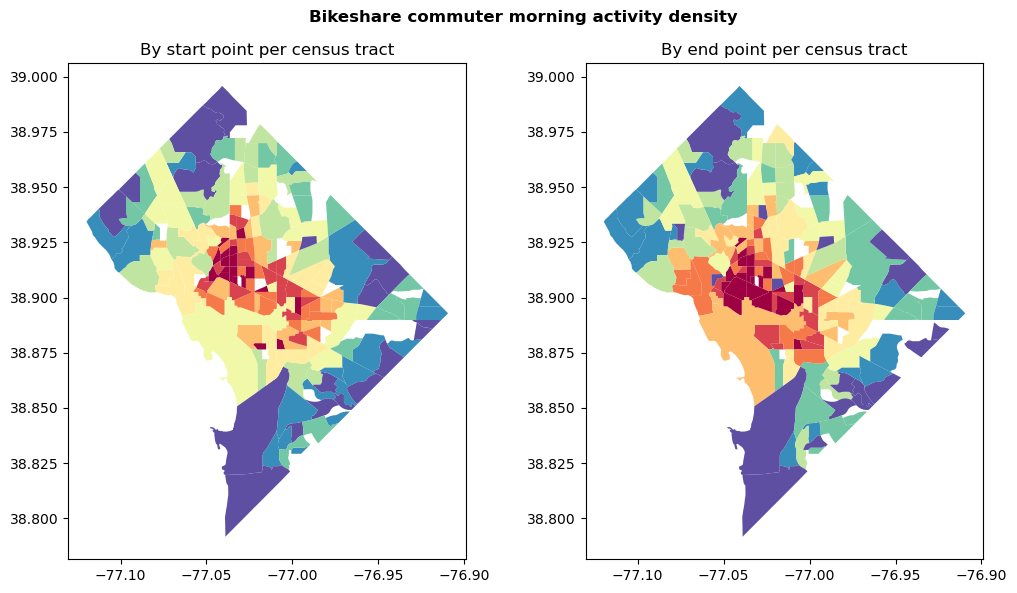

In [154]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2)
fig.suptitle("Bikeshare commuter morning activity density ", fontsize=12, fontweight ="bold" )

commuter_tract_start.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', markersize=0.01, ax=axes[0])
commuter_tract_end.plot(column='Activity Density', k=10, cmap= 'Spectral_r', scheme= 'Quantiles' , markersize=0.01, ax=axes[1])

axes[0].set_title('By start point per census tract')
axes[1].set_title('By end point per census tract')

Text(0.5, 1.0, 'By end point per census tract')

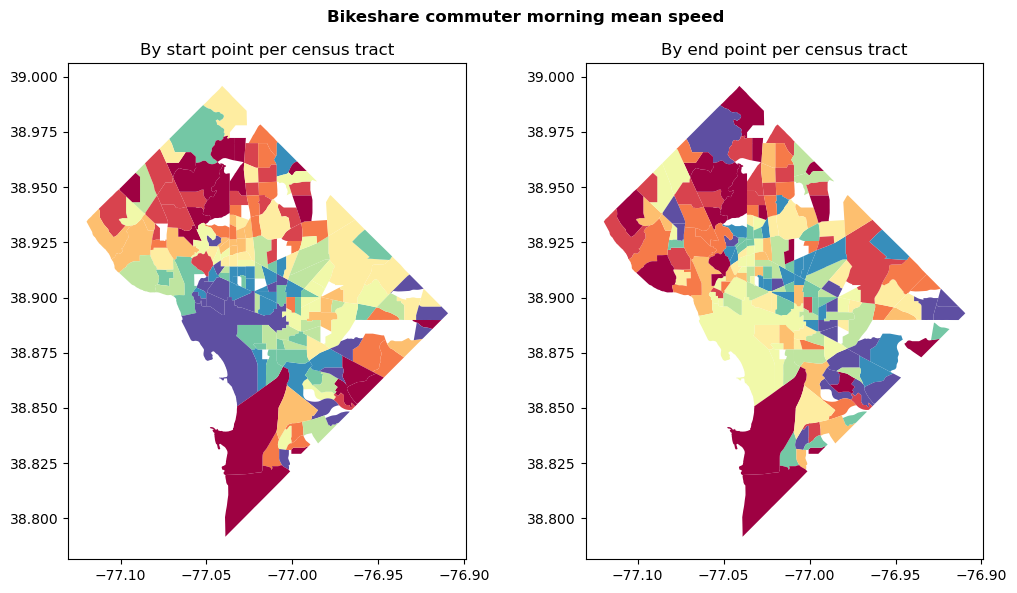

In [155]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2)
fig.suptitle("Bikeshare commuter morning mean speed", fontsize=12, fontweight ="bold" )

commuter_tract_start.plot(column='speed', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', markersize=0.01, ax=axes[0])

commuter_tract_end.plot(column='speed', k=10, cmap= 'Spectral_r', scheme= 'Quantiles' , markersize=0.01, ax=axes[1])

axes[0].set_title('By start point per census tract')
axes[1].set_title('By end point per census tract')

Text(0.5, 1.0, 'By end point per census tract')

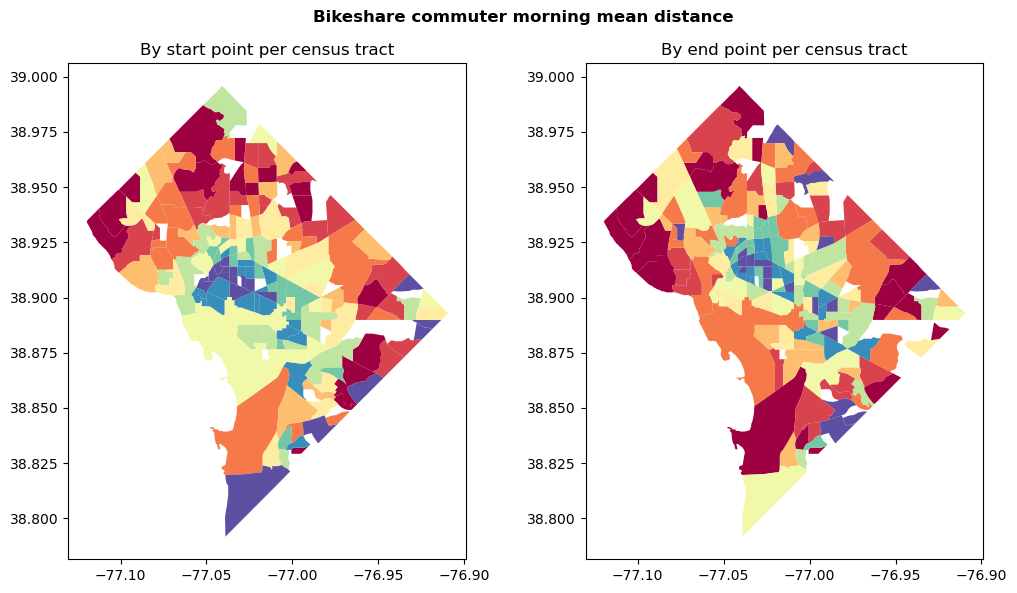

In [156]:
fig, axes = plt.subplots(figsize=(12,6), ncols=2)
fig.suptitle("Bikeshare commuter morning mean distance ", fontsize=12, fontweight ="bold" )

commuter_tract_start.plot(column='distance/km', k=10, cmap= 'Spectral_r', scheme= 'Quantiles', markersize=0.01, ax=axes[0])

commuter_tract_end.plot(column='distance/km', k=10, cmap= 'Spectral_r', scheme= 'Quantiles' , markersize=0.01, ax=axes[1])

axes[0].set_title('By start point per census tract')
axes[1].set_title('By end point per census tract')

______

## Median Income analysis per census tract

In [157]:
median_inc_ct.head()

GEOID Total Households Median Income
0  11001000101              756        187839
1  11001000102             1762        184167
2  11001000201                0              
3  11001000202             1727        164261
4  11001000300             2377        156483

In [158]:
median_inc_ct_Viz = census_tract.merge(median_inc_ct,on= 'GEOID')
median_inc_ct_Viz[['Total Households', 'Median Income']] = median_inc_ct_Viz[['Total Households', 'Median Income']].apply(pd.to_numeric, errors='coerce').fillna(0)
median_inc_ct_Viz = median_inc_ct_Viz.loc[median_inc_ct_Viz['Total Households']>=100]
median_inc_ct_Viz = median_inc_ct_Viz.loc[median_inc_ct_Viz['Median Income']>0]
median_inc_ct_Viz

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
2    305616  003600  11001003600     36   
3    204529  004201  11001004201  42.01   
4    207646  004202  11001004202  42.02   
..      ...     ...          ...    ...   
200  962212  009508  11001009508  95.08   
201  648848  009509  11001009509  95.09   
203  431384  009801  11001009801  98.01   
204  171910  002801  11001002801  28.01   
205  229696  002802  11001002802  28.02   

                                              geometry  Total Households  \
0    POLYGON ((-77.05018 38.92125, -77.05006 38.921...              2362   
1    POLYGON ((-77.04630 38.91632, -77.04630 38.916...              2079   
2    POLYGON ((-77.03241 38.92658, -77.03217 38.926...              1967   
3    POLYGON ((-77.04166 38.91418, -77.04166 38.914...              1889   
4    POLYGON ((-77.04599 38.91451, -77.04574 38.914...              1466   
..                                                 ...               ...   
200  POLYGON ((-77.00905 38.95334, -77.00905 38.953...              1481   
201  POLYGON ((-77.00201 38.95106, -77.00065 38.951...              1246   
203  POLYGON ((-77.00386 38.83099, -77.00353 38.831...              1012   
204  POLYGON ((-77.03646 38.93413, -77.03646 38.934...              1705   
205  POLYGON ((-77.03671 38.92713, -77.03649 38.927...              2520   

     Median Income  
0         153650.0  
1         154792.0  
2         107610.0  
3         132386.0  
4         105449.0  
..             ...  
200        58250.0  
201        86042.0  
203        13510.0  
204        62323.0  
205        72582.0  

[201 rows x 7 columns]

Text(0.5, 1.0, 'Median Income')

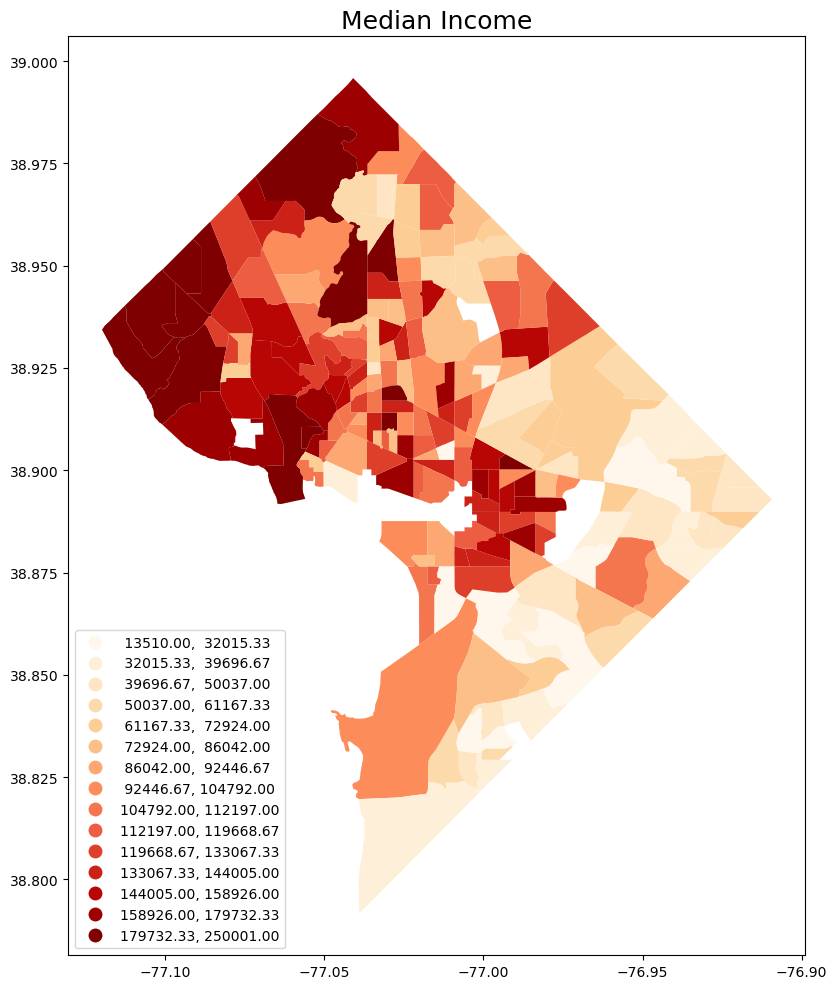

In [159]:
median_inc_ct_Viz.plot(column='Median Income', k=15, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                       legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Median Income', fontsize=18)                      

##  Income distribution

<AxesSubplot: >

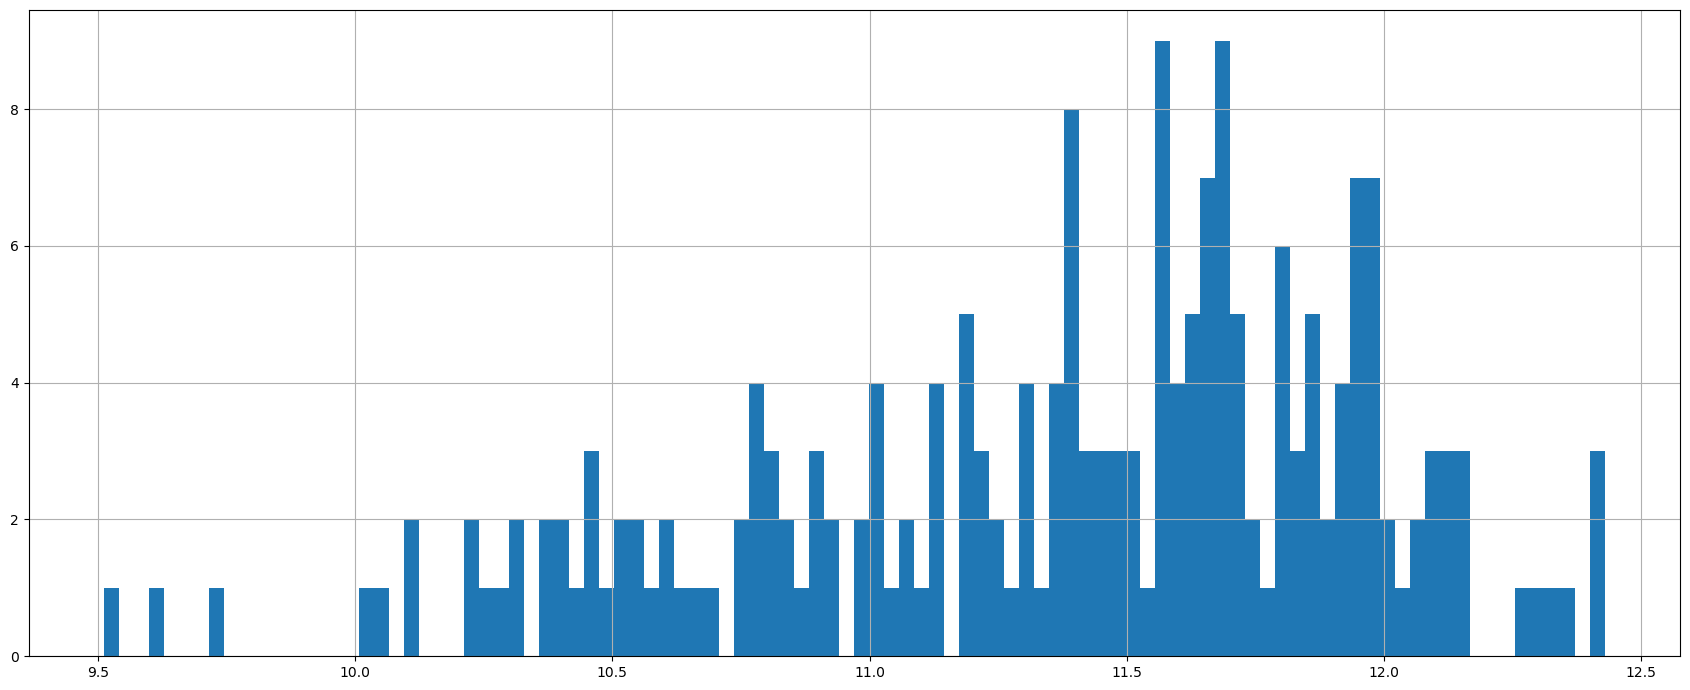

In [160]:
np.log(median_inc_ct_Viz['Median Income']).hist(bins=100)

In [161]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [162]:
is_normal(np.log(median_inc_ct_Viz['Median Income']))

KstestResult(statistic=0.1057872718173839, pvalue=0.020597272189311632)

### Morning commute patterns: commuters with high income vs. low income, where do they go?

### High Income

In [163]:
top5income = median_inc_ct_Viz.nlargest(5, 'Median Income')
top5income['GEOID'].values.tolist()

['11001000903', '11001000904', '11001000804', '11001001003', '11001001500']

In [164]:
commuter.head()

ride_id rideable_type          started_at            ended_at  \
1   8698F10128EA4F18   docked_bike 2020-04-06 07:54:59 2020-04-06 07:57:24   
22  6E4203B71BA7ACE2   docked_bike 2020-04-14 09:17:29 2020-04-14 09:25:39   
23  2613B945D929CE44   docked_bike 2020-04-02 09:43:54 2020-04-02 10:08:19   
33  886BF5AD01F9FDFA   docked_bike 2020-04-01 06:46:55 2020-04-01 06:51:03   
39  98A3C8503AFCB58A   docked_bike 2020-04-25 07:05:00 2020-04-25 07:38:05   

    start_lat  start_lng    end_lat    end_lng member_casual   duration  \
1   38.900711 -77.046449  38.903741 -77.042452        member   2.416667   
22  38.894972 -77.003135  38.884120 -77.017445        member   8.166667   
23  38.884916 -77.005965  38.902000 -77.033530        member  24.416667   
33  38.928121 -77.023795  38.930800 -77.031500        member   4.133333   
39  38.880300 -76.986200  38.865590 -76.952103        member  33.083333   

    distance/km  duration/hour      speed  hour  
1      0.482884       0.040278  11.988854     7  
22     1.729171       0.136111  12.704112     9  
23     3.049556       0.406944   7.493789     9  
33     0.730054       0.068889  10.597559     6  
39     3.374664       0.551389   6.120298     7

In [165]:
top5= ['11001000903', '11001000904', '11001000804', '11001001003', '11001001500']
high_inc = geoStartcommuter.loc[geoStartcommuter['GEOID'].isin(top5)]
high_inc

ride_id  distance/km      speed   duration  \
10009    E045D3C6542EF323     1.318492   9.455321   8.366667   
69865    921BD0B092EDF6B2     1.318492   6.742289  11.733333   
73816    AE9D929F656A7C74     2.195300   6.987694  18.850000   
386305   FE60E7FBD47315A2     7.319140  12.535159  35.033333   
417925   E5997E01CE3AD1C2     3.500794   7.056471  29.766667   
...                   ...          ...        ...        ...   
1695802  60218374F5EF5A64     2.056228   9.241474  13.350000   
2029904  EA63EB67D2E2EDB7     2.612337  16.441284   9.533333   
2264287  1D994689A09FED4E     5.159188  13.079632  23.666667   
2379922  B2262410552E20F1     2.822698  16.416339  10.316667   
3176779  DED3CDBBC651DAE4     6.525506  17.010732  23.016667   

                           geometry  index_right   ALAND TRACTCE        GEOID  \
10009    POINT (-77.08717 38.93874)           43  928101  000903  11001000903   
69865    POINT (-77.08717 38.93874)           43  928101  000903  11001000903   
73816    POINT (-77.08717 38.93874)           43  928101  000903  11001000903   
386305   POINT (-77.08717 38.93874)           43  928101  000903  11001000903   
417925   POINT (-77.08717 38.93874)           43  928101  000903  11001000903   
...                             ...          ...     ...     ...          ...   
1695802  POINT (-77.09000 38.95000)           52  982460  001003  11001001003   
2029904  POINT (-77.09000 38.95000)           52  982460  001003  11001001003   
2264287  POINT (-77.09000 38.95000)           52  982460  001003  11001001003   
2379922  POINT (-77.09000 38.95000)           52  982460  001003  11001001003   
3176779  POINT (-77.09000 38.95000)           52  982460  001003  11001001003   

          NAME  
10009     9.03  
69865     9.03  
73816     9.03  
386305    9.03  
417925    9.03  
...        ...  
1695802  10.03  
2029904  10.03  
2264287  10.03  
2379922  10.03  
3176779  10.03  

[372 rows x 10 columns]

In [166]:
commuter_high = commuter.loc[high_inc.index, :]

'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(commuter_high.end_lng, commuter_high.end_lat)]
comHighLatLon = gpd.GeoDataFrame(commuter_high[['ride_id']],geometry=geometry,crs={'init': 'epsg:4326'})
comHighLatLon

ride_id                    geometry
10009    E045D3C6542EF323  POINT (-77.07276 38.93488)
69865    921BD0B092EDF6B2  POINT (-77.07276 38.93488)
73816    AE9D929F656A7C74  POINT (-77.06198 38.94114)
386305   FE60E7FBD47315A2  POINT (-77.03243 38.88855)
417925   E5997E01CE3AD1C2  POINT (-77.05183 38.92339)
...                   ...                         ...
1695802  60218374F5EF5A64  POINT (-77.11000 38.94000)
2029904  EA63EB67D2E2EDB7  POINT (-77.06203 38.94112)
2264287  1D994689A09FED4E  POINT (-77.04375 38.92070)
2379922  B2262410552E20F1  POINT (-77.06000 38.94000)
3176779  DED3CDBBC651DAE4  POINT (-77.04658 38.90201)

[372 rows x 2 columns]

<AxesSubplot: >

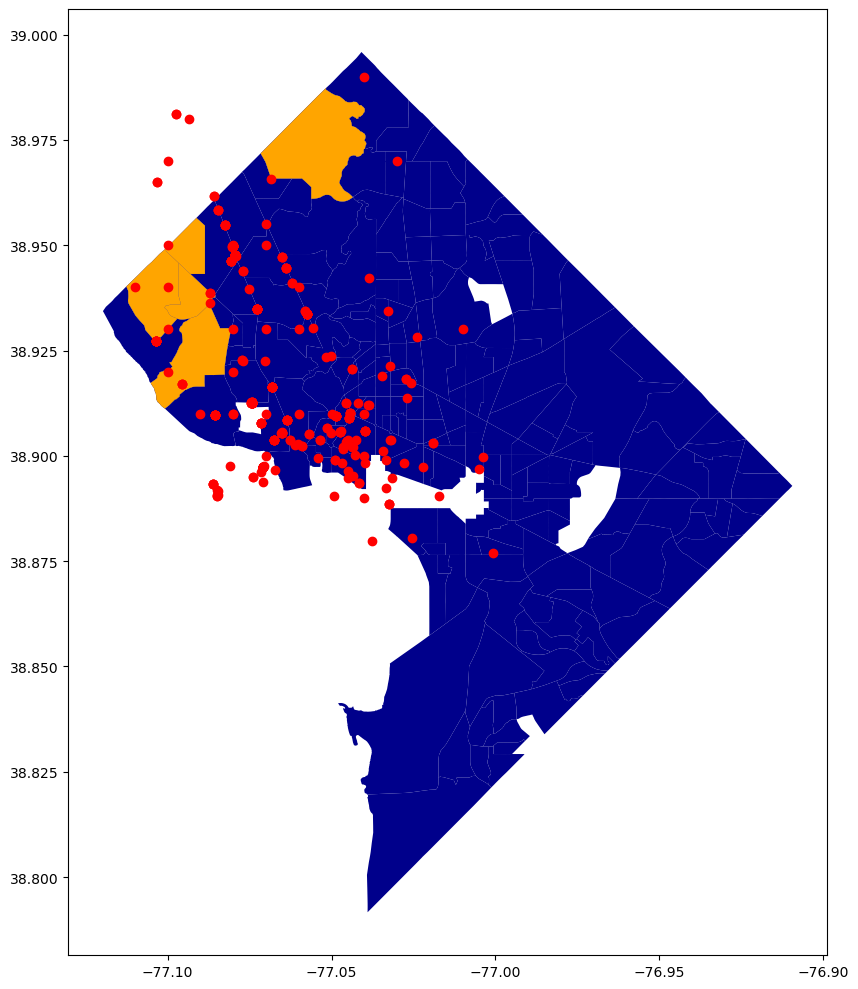

In [167]:
fig,ax = plt.subplots(figsize=(10,10))

median_inc_ct_Viz.plot(facecolor='darkblue',ax=ax)
top5income.plot(facecolor='orange',ax=ax)
comHighLatLon.plot(facecolor='red',ax=ax)

### Low income

In [168]:
bot5income = median_inc_ct_Viz.nsmallest(5, 'Median Income')
bot5income['GEOID'].values.tolist()

['11001009801', '11001007401', '11001007504', '11001009602', '11001007406']

In [169]:
bot5 = ['11001009801', '11001007401', '11001007504', '11001009602', '11001007406']
low_inc = geoStartcommuter.loc[geoStartcommuter['GEOID'].isin(bot5)]
low_inc

ride_id  distance/km      speed   duration  \
105801   95ADE2170098DCAA     5.632691  10.366917  32.600000   
118785   3C73C63A4C854B6F     2.597807   5.627019  27.700000   
133793   A44C5BF2C56E86B2     3.334565   6.728943  29.733333   
173045   92D3BA72E15FE819     1.217957   7.957611   9.183333   
176267   6EC9E4D61256EDD2     2.866644  13.870857  12.400000   
...                   ...          ...        ...        ...   
5136519  BD7BA9DC34D0FBF4     1.399610  10.812438   7.766667   
5136520  00750D1F064D92EE     1.399610  12.986073   6.466667   
5136522  A6785450C8BFB36C     1.399610  16.201274   5.183333   
5136524  ADDBC30C2778C03C     3.653754  14.220014  15.416667   
5137146  B744F1908FE160A4     1.399610  13.364977   6.283333   

                           geometry  index_right    ALAND TRACTCE  \
105801   POINT (-76.97769 38.85737)          115   764081  007504   
118785   POINT (-76.97769 38.85737)          115   764081  007504   
133793   POINT (-76.97769 38.85737)          115   764081  007504   
173045   POINT (-76.97769 38.85737)          115   764081  007504   
176267   POINT (-76.97769 38.85737)          115   764081  007504   
...                             ...          ...      ...     ...   
5136519  POINT (-76.99464 38.86267)           17  1209113  007401   
5136520  POINT (-76.99464 38.86267)           17  1209113  007401   
5136522  POINT (-76.99464 38.86267)           17  1209113  007401   
5136524  POINT (-76.99473 38.86267)           17  1209113  007401   
5137146  POINT (-76.99464 38.86267)           17  1209113  007401   

               GEOID   NAME  
105801   11001007504  75.04  
118785   11001007504  75.04  
133793   11001007504  75.04  
173045   11001007504  75.04  
176267   11001007504  75.04  
...              ...    ...  
5136519  11001007401  74.01  
5136520  11001007401  74.01  
5136522  11001007401  74.01  
5136524  11001007401  74.01  
5137146  11001007401  74.01  

[498 rows x 10 columns]

In [170]:
commuter_low = commuter.loc[low_inc.index, :]

'''make points from given latitudes and longitudes'''
geometry = [Point(xy) for xy in zip(commuter_low.end_lng, commuter_low.end_lat)]
comLowLatLon = gpd.GeoDataFrame(commuter_low[['ride_id']],geometry=geometry,crs={'init': 'epsg:4326'})
comLowLatLon

ride_id                    geometry
105801   95ADE2170098DCAA  POINT (-77.01211 38.90036)
118785   3C73C63A4C854B6F  POINT (-76.99447 38.87674)
133793   A44C5BF2C56E86B2  POINT (-76.99540 38.88400)
173045   92D3BA72E15FE819  POINT (-76.98524 38.86661)
176267   6EC9E4D61256EDD2  POINT (-76.99530 38.87920)
...                   ...                         ...
5136519  BD7BA9DC34D0FBF4  POINT (-77.00517 38.85312)
5136520  00750D1F064D92EE  POINT (-77.00517 38.85312)
5136522  A6785450C8BFB36C  POINT (-77.00517 38.85312)
5136524  ADDBC30C2778C03C  POINT (-77.00813 38.83152)
5137146  B744F1908FE160A4  POINT (-77.00517 38.85312)

[498 rows x 2 columns]

<AxesSubplot: >

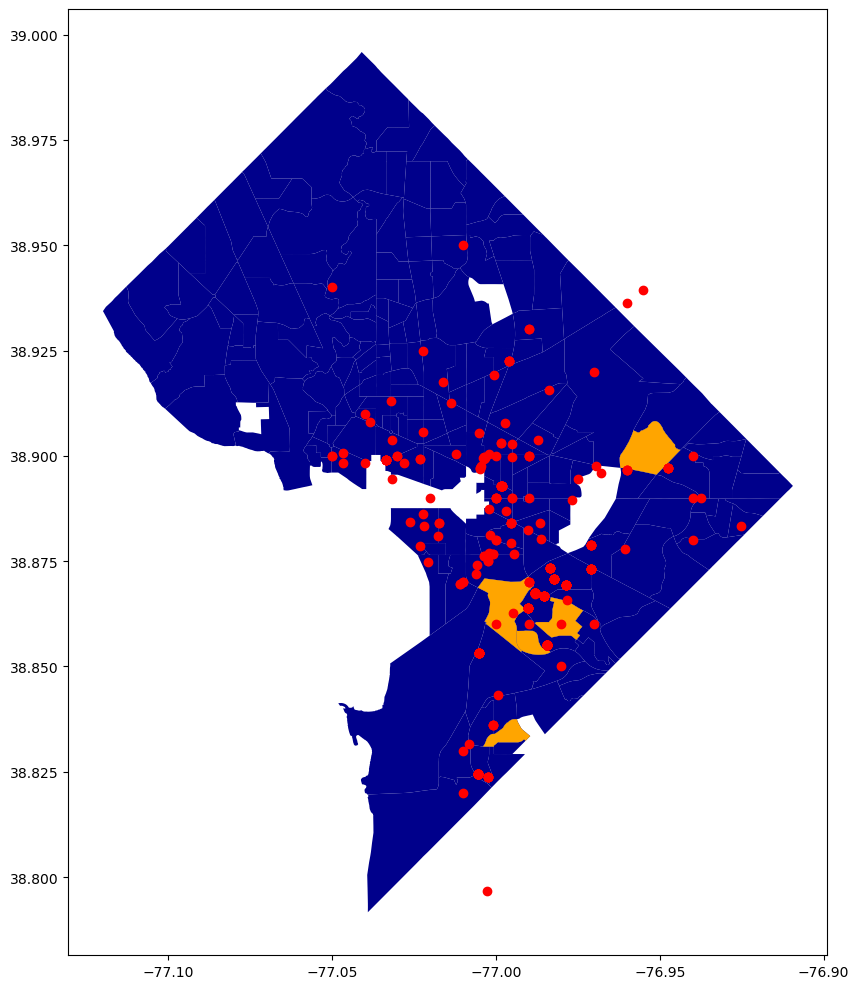

In [171]:
fig,ax = plt.subplots(figsize=(10,10))

median_inc_ct_Viz.plot(facecolor='darkblue',ax=ax)
bot5income.plot(facecolor='orange',ax=ax)
comLowLatLon.plot(facecolor='red',ax=ax)

## Commuters' data analysis per census tract

In [172]:
commute_ct_VIZ = census_tract.merge(commute_ct,on= 'GEOID')

In [173]:
commute_ct_VIZ[['Drove alone','Carpooled','Used Public Transport','Walked','Used other means','Worked From Home']] = commute_ct_VIZ[['Drove alone','Carpooled','Used Public Transport','Walked','Used other means','Worked From Home']].apply(pd.to_numeric, errors = 'coerce')

Text(0.5, 1.0, 'Drove alone')

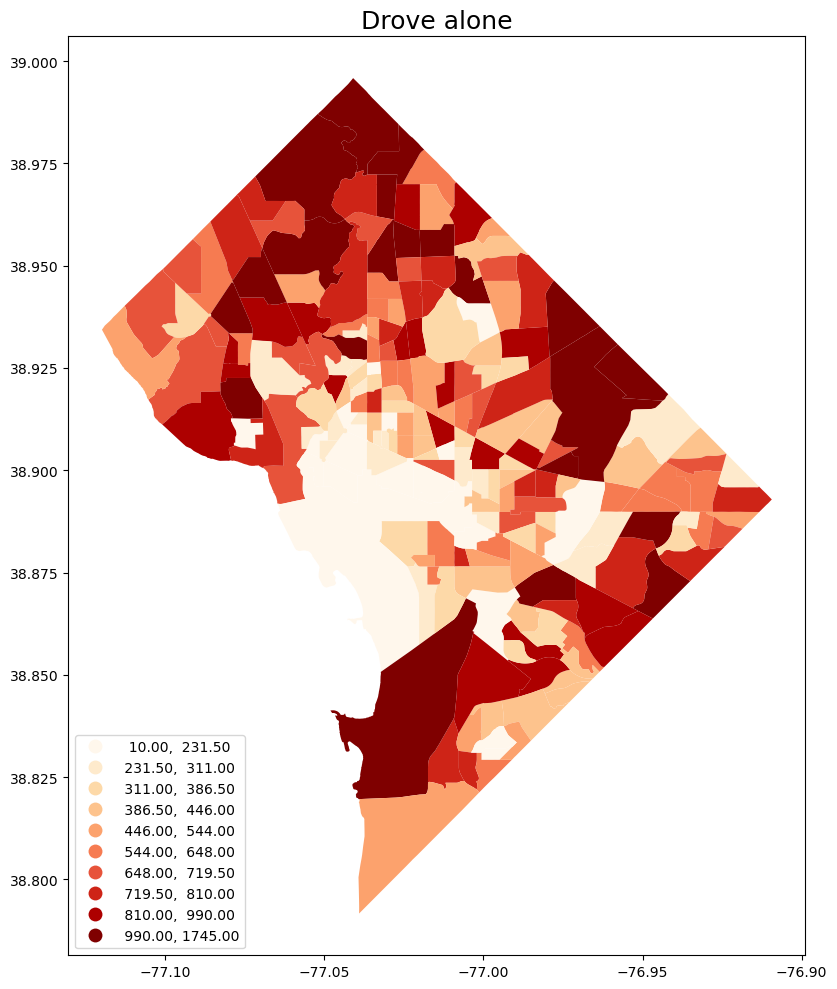

In [174]:
commute_ct_VIZ.plot(column='Drove alone', k=10, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                   legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Drove alone', fontsize=18)

Text(0.5, 1.0, 'Carpooled')

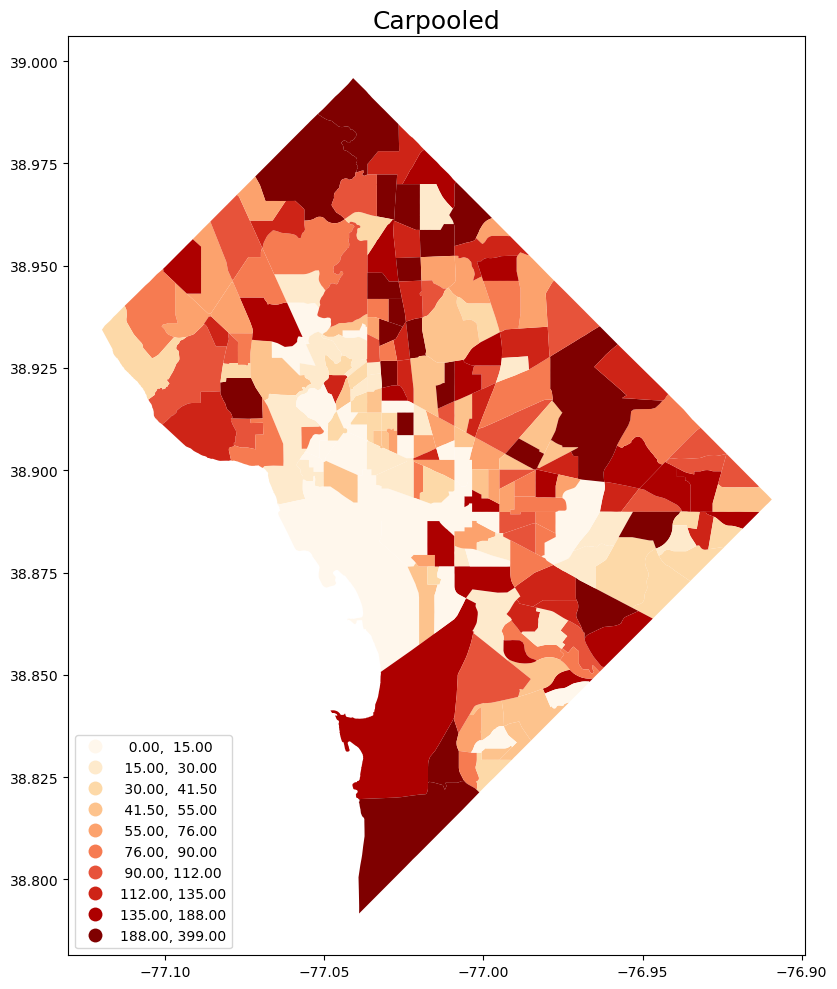

In [175]:
commute_ct_VIZ.plot(column='Carpooled', k=10, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                   legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Carpooled', fontsize=18)

Text(0.5, 1.0, 'Used Public Transport')

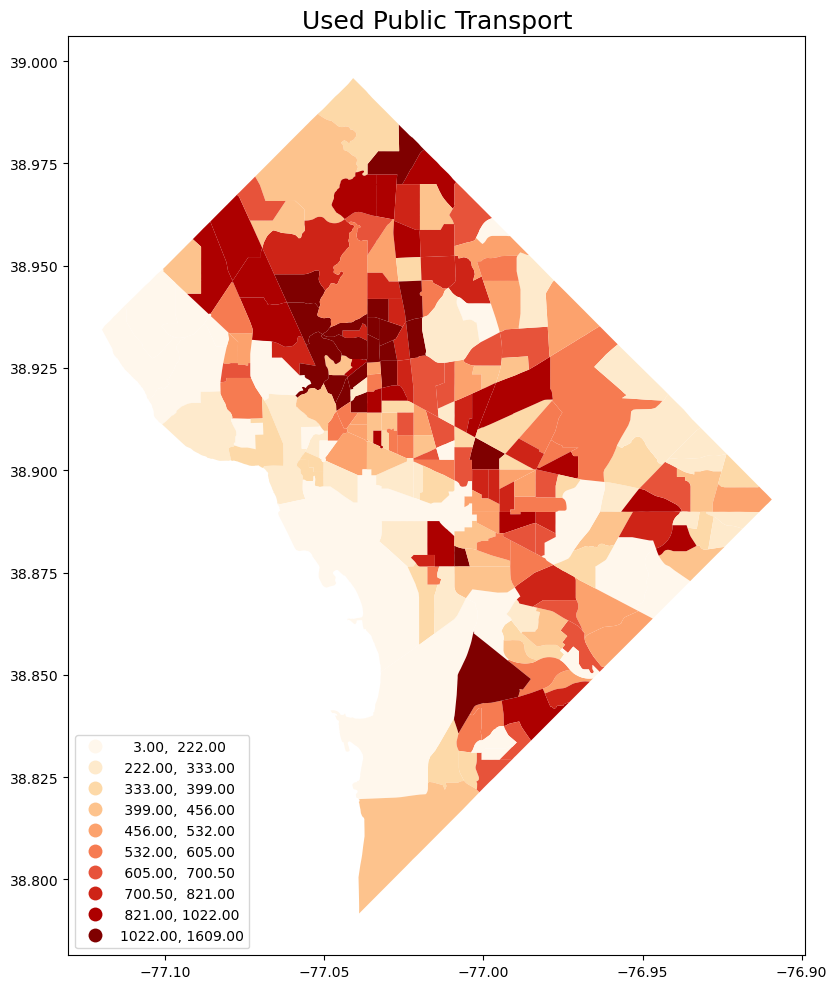

In [176]:

commute_ct_VIZ.plot(column='Used Public Transport', k=10, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                   legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Used Public Transport', fontsize=18)

Text(0.5, 1.0, 'Walked')

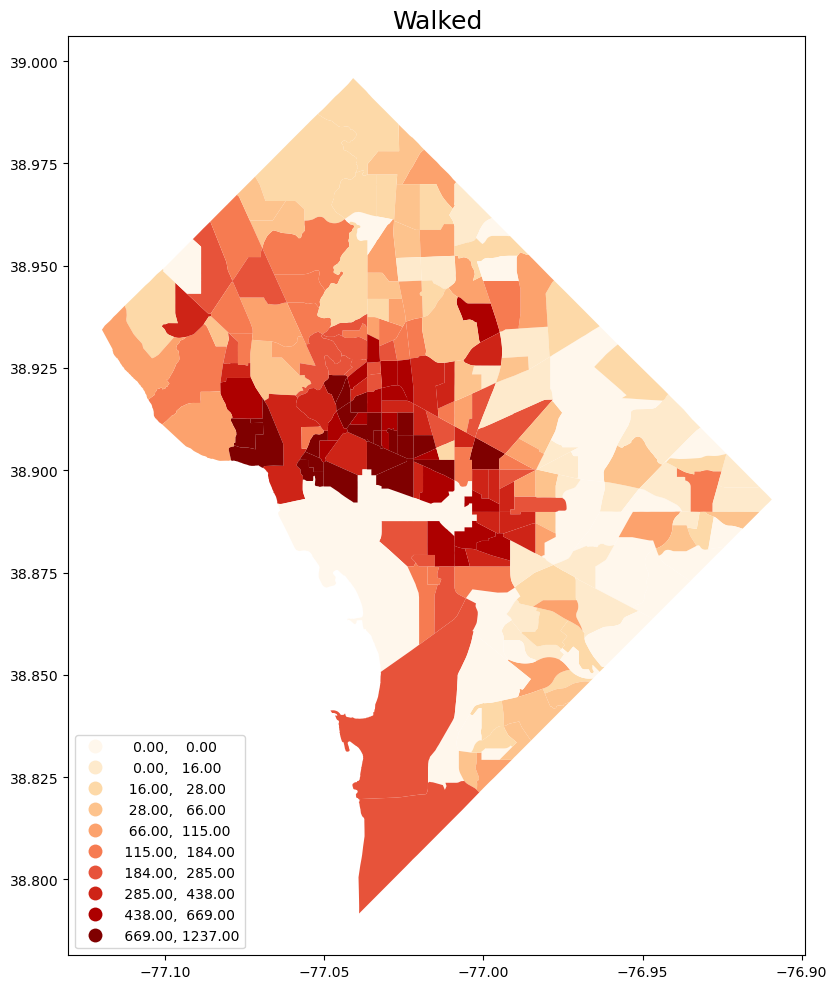

In [177]:

commute_ct_VIZ.plot(column='Walked', k=10, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                   legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Walked', fontsize=18)

Text(0.5, 1.0, 'Used other means')

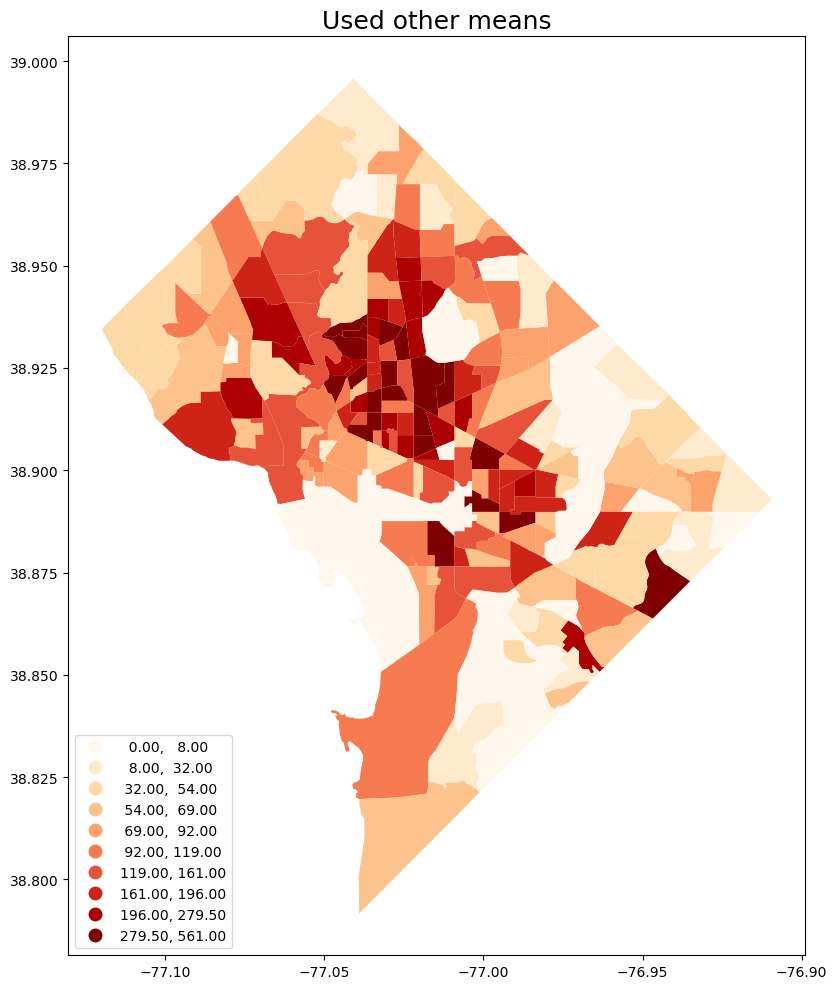

In [178]:

commute_ct_VIZ.plot(column='Used other means', k=10, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                   legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Used other means', fontsize=18)

Text(0.5, 1.0, 'Worked from Home')

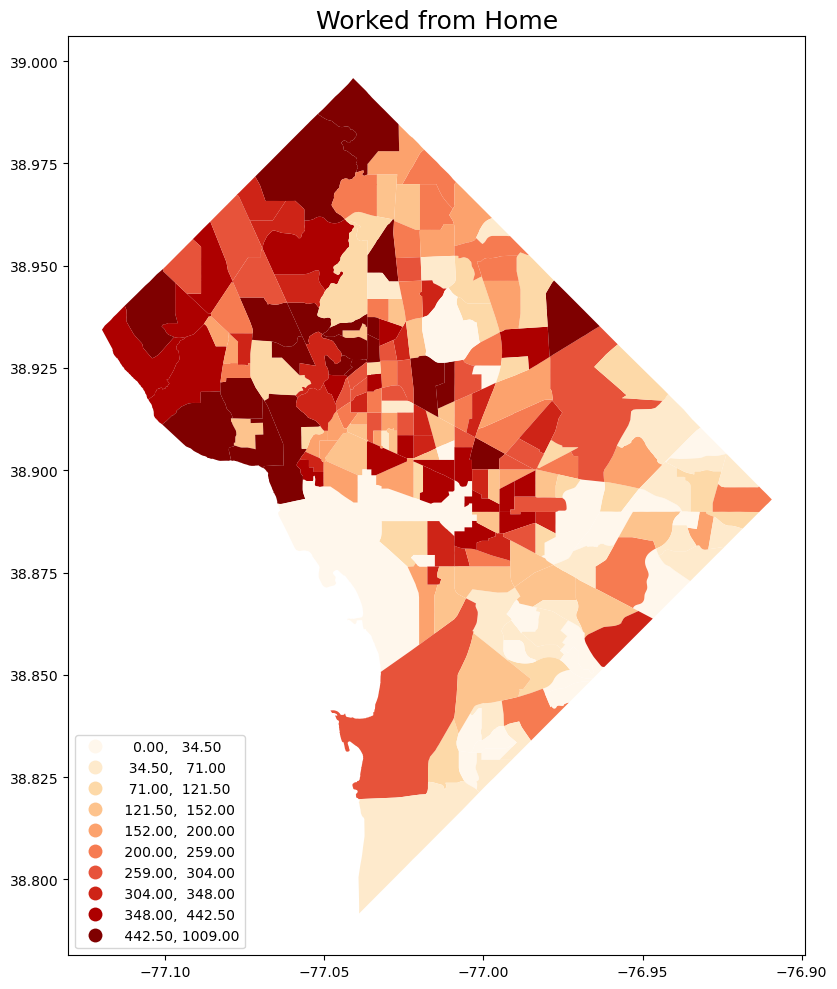

In [179]:

commute_ct_VIZ.plot(column='Worked From Home', k=10, cmap= 'OrRd', scheme= 'Quantiles',legend=True,
                   legend_kwds={'loc': 'lower left'}, markersize=0.01, figsize=(10,10))
plt.title('Worked from Home', fontsize=18)

## Bike infrastructure in DC

In [180]:
bikelanes = gpd.read_file(r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\Bicycle_Lanes.shp")
bikelanes

ROUTEID        ROUTENAME ROADTYPE                        SUBBLOCKKE  \
0     11001502       15TH ST NW        1  6dcbdc3a941ab83f3a7d9548df7ab7ef   
1     11000702        7TH ST NW        1  2859478e88c9b44ff41e061c74356be8   
2     11001402       14TH ST NW        1  ab2082b1fc3a3e52b8d24cd01b32ad63   
3     11001502       15TH ST NW        1  5021fd55010da50f0ccc60f93cc964dc   
4     11003402       34TH ST NW        1  59a24cc29900a596e2a114611d5d0ba3   
...        ...              ...      ...                               ...   
2154  63089892  VIRGINIA AVE SE        6  12b6ccbafe54ded871d0de9242ae9b00   
2155  64058502     MAINE AVE SW        6  5a9ceb672925054cfa2da9ffa342d9c3   
2156  63089892  VIRGINIA AVE SE        6  625f70434c23b78c74f5dff0bb813e2f   
2157  64058502     MAINE AVE SW        6  2f8aff08ab5e5ffded25e2d531ea1180   
2158  63089892  VIRGINIA AVE SE        6  8fd8e1e2c1800e761ac82a7e0a20d83a   

     BIKELANE_P BIKELANE_T BIKELANE_1 BIKELANE_C BIKELANE_2 BIKELANE_D  ...  \
0          None       None       None       None       None         IB  ...   
1            BD         BD       None       None         BD       None  ...   
2            BD         BD       None       None         BD       None  ...   
3          None       None       None       None       None         IB  ...   
4            IB         IB       None       None         IB       None  ...   
...         ...        ...        ...        ...        ...        ...  ...   
2154       None       None       None       None       None       None  ...   
2155       None       None       None       None       None       None  ...   
2156       None       None       None       None       None       None  ...   
2157       None       None       None       None       None       None  ...   
2158       None       None       None       None       None       None  ...   

     STREETNAME STREETTYPE TOTALBIKEL TOTALBIK_1 WARD_ID SMD_ID  ANC_ID  \
0          15TH         ST          2          7       2   2F05      2F   
1           7TH         ST          2         10       2   2G02      2G   
2          14TH         ST          2         10       4   4E03      4E   
3          15TH         ST          2          8       2   2B09      2B   
4          34TH         ST          1          5       2   2E03      2E   
...         ...        ...        ...        ...     ...    ...     ...   
2154   VIRGINIA        AVE          2          8       6   6B01      6B   
2155      MAINE        AVE          2          8       6   6D01      6D   
2156   VIRGINIA        AVE          2          8       6   6B03      6B   
2157      MAINE        AVE          2          8       6   6D01      6D   
2158   VIRGINIA        AVE          2          8       6   6B01      6B   

     OBJECTID SHAPELEN                                           geometry  
0     3433077        0  LINESTRING Z (-77.03457 38.90657 0.00000, -77....  
1     3433081        0  LINESTRING Z (-77.02192 38.91113 0.00000, -77....  
2     3433091        0  LINESTRING Z (-77.03343 38.95151 0.00000, -77....  
3     3433123        0  LINESTRING Z (-77.03454 38.91454 0.00000, -77....  
4     3433131        0  LINESTRING Z (-77.06781 38.90636 0.00000, -77....  
...       ...      ...                                                ...  
2154  3467597        0  LINESTRING Z (-77.00083 38.87979 0.00000, -77....  
2155  3467677        0  LINESTRING Z (-77.02507 38.88028 0.00000, -77....  
2156  3467681        0  LINESTRING Z (-77.00058 38.87971 0.00000, -77....  
2157  3467696        0  LINESTRING Z (-77.02494 38.88019 0.00000, -77....  
2158  3467720        0  LINESTRING Z (-77.00205 38.88012 0.00000, -77....  

[2159 rows x 27 columns]

In [181]:
walkshed = gpd.read_file(r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\Walkshed_Bikeshare.shp")

In [182]:
signed = gpd.read_file(r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\Signed_Bike_Routes.shp")

In [183]:
bikeshare_loc = gpd.read_file(r"C:\Users\ilgit\OneDrive\Documents\Urban Data Science\Capital_Bike_Share_Locations.shp")
bikeshare_loc = bikeshare_loc.loc[bikeshare_loc['REGION_NAM'] == 'Washington, DC']

In [184]:
bikeshare = gpd.sjoin(bikeshare_loc, census_tract, op='within', how='inner')
bikeshare = bikeshare.groupby('GEOID', as_index=False).agg({'OBJECTID':'count'})
bikeshare = census_tract.merge(bikeshare,right_on='GEOID',left_on='GEOID')
bikeshare 

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
2    305616  003600  11001003600     36   
3    204529  004201  11001004201  42.01   
4    207646  004202  11001004202  42.02   
..      ...     ...          ...    ...   
150  398513  006900  11001006900     69   
151  962212  009508  11001009508  95.08   
152  431384  009801  11001009801  98.01   
153  171910  002801  11001002801  28.01   
154  229696  002802  11001002802  28.02   

                                              geometry  OBJECTID  
0    POLYGON ((-77.05018 38.92125, -77.05006 38.921...         2  
1    POLYGON ((-77.04630 38.91632, -77.04630 38.916...         2  
2    POLYGON ((-77.03241 38.92658, -77.03217 38.926...         2  
3    POLYGON ((-77.04166 38.91418, -77.04166 38.914...         1  
4    POLYGON ((-77.04599 38.91451, -77.04574 38.914...         1  
..                                                 ...       ...  
150  POLYGON ((-76.99377 38.88459, -76.99369 38.884...         3  
151  POLYGON ((-77.00905 38.95334, -77.00905 38.953...         1  
152  POLYGON ((-77.00386 38.83099, -77.00353 38.831...         1  
153  POLYGON ((-77.03646 38.93413, -77.03646 38.934...         1  
154  POLYGON ((-77.03671 38.92713, -77.03649 38.927...         1  

[155 rows x 6 columns]

Text(0.5, 1.0, 'Bikelanes and bikeshare walkshed in DC')

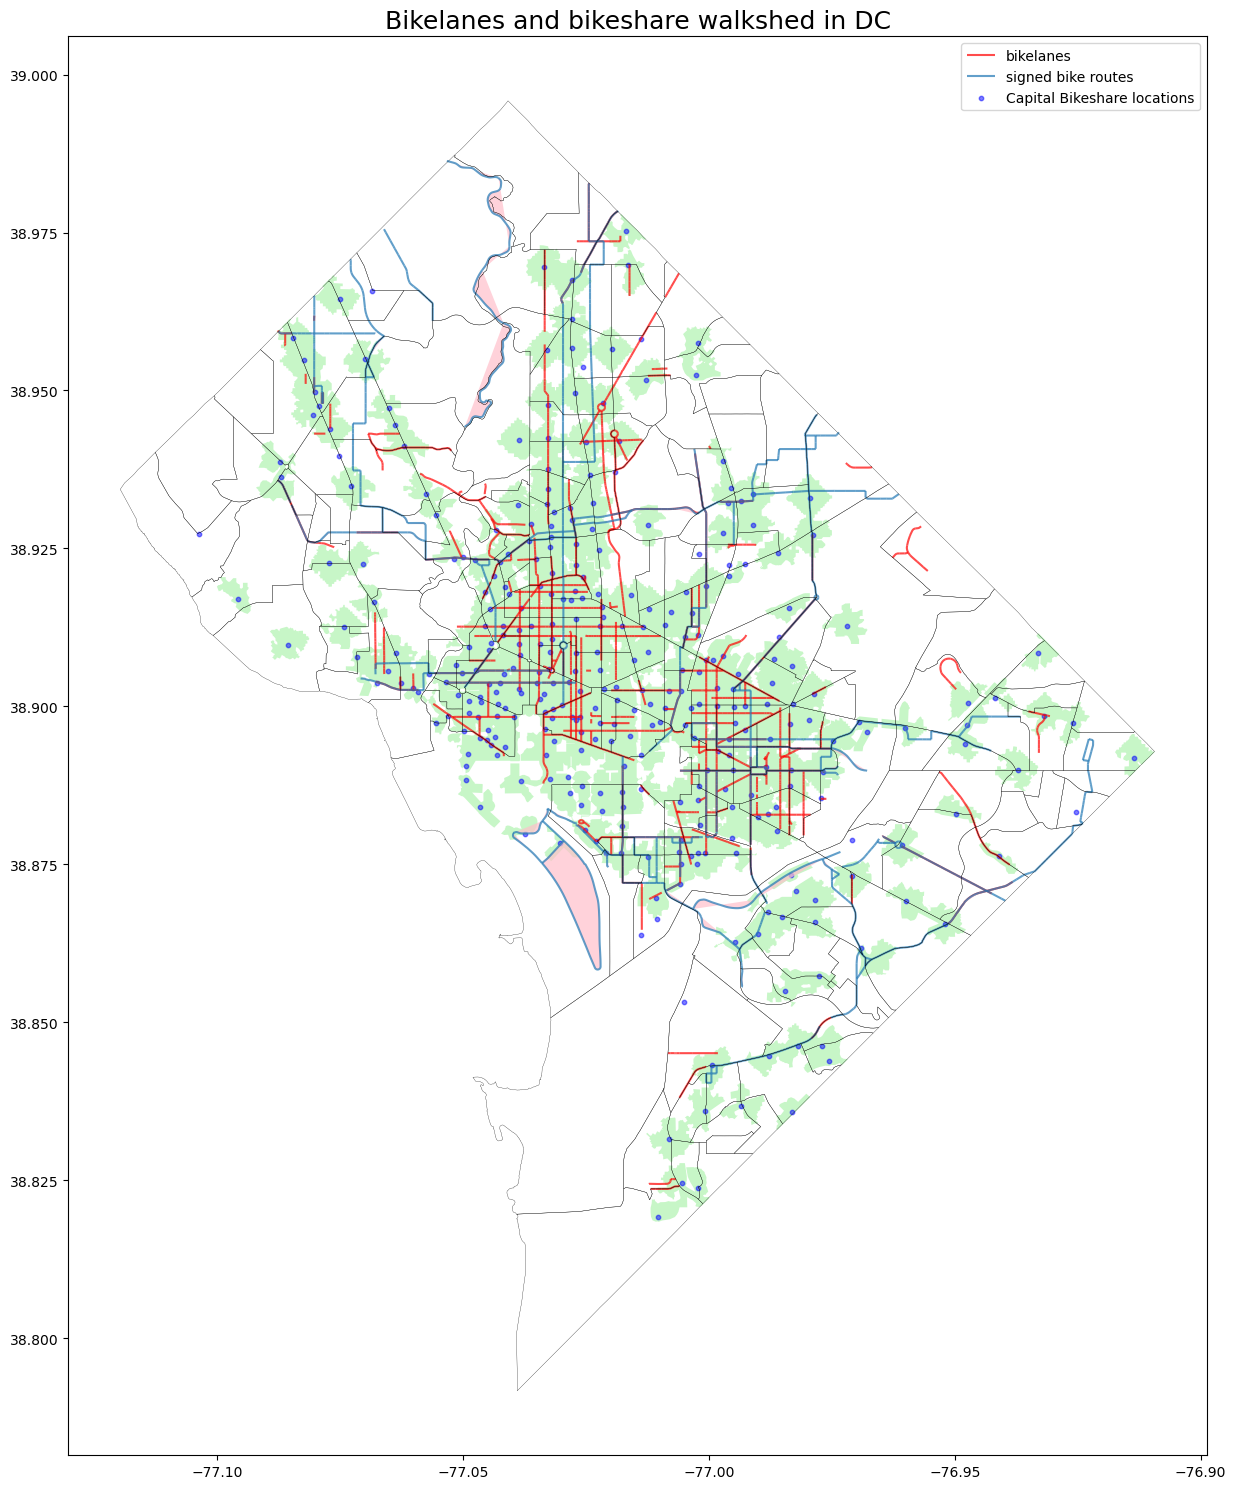

In [185]:
fig, ax = plt.subplots(figsize=(15, 15))
bikelanes.plot(ax=ax, alpha=0.7, color="red", label= 'bikelanes')
walkshed.plot(ax=ax, alpha=0.5, color="lightgreen", label= 'bikelanes')
signed.plot(ax=ax, alpha=0.7, facecolor="pink", label= 'signed bike routes')
bikeshare_loc.plot(ax=ax, alpha=0.5, markersize=10, facecolor="blue", label= 'Capital Bikeshare locations')
census_tract.boundary.plot(ax=ax, color="k", linewidth = 0.2)
ax.legend()
plt.title('Bikelanes and bikeshare walkshed in DC', fontsize=18)

## Hypothesis testing

In [186]:
# H0: commuter morning rush hour bikeshare activity have the same distribution
# in 25% highest income and 25% lowest income neighbourhoods
# by activity density, ride duration, speed and distance.

In [187]:
top25percent = median_inc_ct_Viz.nlargest(50, 'Median Income')
top25 = top25percent['GEOID'].values.tolist()

In [188]:
high_inc_25 = geoStartcommuter.loc[geoStartcommuter['GEOID'].isin(top25)]
high_inc_25.head()

ride_id  distance/km      speed   duration  \
22    6E4203B71BA7ACE2     1.729171  12.704112   8.166667   
786   272BAE57A9278E1E     1.499303  15.782135   5.700000   
1773  BF5C4167EA92EBF5     0.902029   9.385277   5.766667   
2812  C48E659C8C8F1D91     1.373976   9.736840   8.466667   
3388  69228F9B0F1FE017     4.215105  16.351702  15.466667   

                        geometry  index_right   ALAND TRACTCE        GEOID  \
22    POINT (-77.00314 38.89497)          135  338424  008200  11001008200   
786   POINT (-77.00314 38.89497)          135  338424  008200  11001008200   
1773  POINT (-77.00314 38.89497)          135  338424  008200  11001008200   
2812  POINT (-77.00314 38.89497)          135  338424  008200  11001008200   
3388  POINT (-77.00035 38.88996)          135  338424  008200  11001008200   

     NAME  
22     82  
786    82  
1773   82  
2812   82  
3388   82

In [189]:
high_inc_25_ad = commuter_tract_start.loc[commuter_tract_start['GEOID'].isin(top25)]
high_inc_25_ad.head()

ALAND TRACTCE        GEOID   NAME  \
0    271037  004001  11001004001  40.01   
1    194755  004002  11001004002  40.02   
10  1042157  000300  11001000300      3   
11  1541239  000400  11001000400      4   
12   581507  000502  11001000502   5.02   

                                             geometry  ride_id      speed  \
0   POLYGON ((-77.05018 38.92125, -77.05006 38.921...     4441  11.722740   
1   POLYGON ((-77.04630 38.91632, -77.04630 38.916...     8537  11.541538   
10  POLYGON ((-77.08263 38.92120, -77.08257 38.921...     1272  12.060649   
11  POLYGON ((-77.07319 38.92762, -77.07319 38.928...     1349  12.333473   
12  POLYGON ((-77.06640 38.93097, -77.06639 38.931...     1873  14.497210   

    distance/km   duration  Activity Density  
0      1.959089  10.405622          0.016385  
1      1.896871  10.465197          0.043835  
10     3.024240  15.003472          0.001221  
11     3.132451  16.001730          0.000875  
12     2.762618  12.242810          0.003221

In [190]:
bot25percent = median_inc_ct_Viz.nsmallest(50, 'Median Income')
bot25 = bot25percent['GEOID'].values.tolist()

In [191]:
low_inc_25 = geoStartcommuter.loc[geoStartcommuter['GEOID'].isin(bot25)]
low_inc_25.head()

ride_id  distance/km      speed   duration  \
1     8698F10128EA4F18     0.482884  11.988854   2.416667   
448   62070F64DBBFFBDC     3.700668  12.462493  17.816667   
1522  B5C9E37A1C3DD5C2     0.592170  10.103369   3.516667   
2144  C5883F3A650A1198     2.779260   8.730661  19.100000   
3964  ED94736A3E61C51E     3.785946  13.670415  16.616667   

                        geometry  index_right   ALAND TRACTCE        GEOID  \
1     POINT (-77.04645 38.90071)          152  661580  010800  11001010800   
448   POINT (-77.04154 38.89351)          152  661580  010800  11001010800   
1522  POINT (-77.04988 38.89610)          152  661580  010800  11001010800   
2144  POINT (-77.04988 38.89610)          152  661580  010800  11001010800   
3964  POINT (-77.04891 38.90088)          152  661580  010800  11001010800   

     NAME  
1     108  
448   108  
1522  108  
2144  108  
3964  108

In [192]:
low_inc_25_ad = commuter_tract_start.loc[commuter_tract_start['GEOID'].isin(bot25)]
low_inc_25_ad.head()

ALAND TRACTCE        GEOID   NAME  \
5    608700  007407  11001007407  74.07   
16  1209113  007401  11001007401  74.01   
19   518363  009804  11001009804  98.04   
21   601755  001804  11001001804  18.04   
25  1037012  009807  11001009807  98.07   

                                             geometry  ride_id      speed  \
5   POLYGON ((-76.99424 38.86080, -76.99416 38.860...       25  11.696346   
16  POLYGON ((-77.00540 38.86880, -77.00342 38.870...      361  10.554385   
19  POLYGON ((-77.00422 38.84041, -77.00351 38.841...       10  13.136319   
21  POLYGON ((-77.03342 38.96220, -77.03342 38.962...      544  15.451298   
25  POLYGON ((-77.01737 38.82390, -77.01737 38.824...       86  12.946325   

    distance/km   duration  Activity Density  
5      2.894082  15.815333          0.000041  
16     1.855415  10.795522          0.000299  
19     2.986197  14.783333          0.000019  
21     3.810401  14.568873          0.000904  
25     2.478202  10.896124          0.000083

### K-S tests

In [193]:
# k-s pairwise
stats.ks_2samp(high_inc_25_ad['Activity Density'],low_inc_25_ad['Activity Density'])

KstestResult(statistic=0.5499738356881214, pvalue=1.3874537323085308e-06)

In [194]:
# k-s pairwise
stats.ks_2samp(high_inc_25_ad['speed'],low_inc_25_ad['speed'])

KstestResult(statistic=0.20041862899005755, pvalue=0.2983164366023223)

In [195]:
# k-s pairwise
stats.ks_2samp(high_inc_25_ad['duration'],low_inc_25_ad['duration'])

KstestResult(statistic=0.20774463631606488, pvalue=0.2569695168220891)

In [196]:
# k-s pairwise
stats.ks_2samp(high_inc_25_ad['distance/km'],low_inc_25_ad['distance/km'])

KstestResult(statistic=0.130298273155416, pvalue=0.7951861195142726)

In [197]:
# k-s pairwise -ride counts
stats.ks_2samp(high_inc_25_ad['ride_id'],low_inc_25_ad['ride_id'])

KstestResult(statistic=0.5960230245944532, pvalue=1.0171908514548417e-07)

### T- tests

In [198]:
# t test pairwise
stats.ttest_ind(high_inc_25_ad['Activity Density'],low_inc_25_ad['Activity Density'])

Ttest_indResult(statistic=3.9514279319509646, pvalue=0.00015874556615855877)

In [199]:
# t test pairwise
stats.ttest_ind(high_inc_25_ad['speed'],low_inc_25_ad['speed'])

Ttest_indResult(statistic=0.31352236443872455, pvalue=0.7546429943961694)

In [200]:
# t test pairwise
stats.ttest_ind(high_inc_25_ad['duration'],low_inc_25_ad['duration'])

Ttest_indResult(statistic=-1.1886463108665823, pvalue=0.23785081341724781)

In [201]:
# t test pairwise
stats.ttest_ind(high_inc_25_ad['distance/km'],low_inc_25_ad['distance/km'])

Ttest_indResult(statistic=-0.9691278117477153, pvalue=0.3351991181579519)

In [202]:
# t test pairwise
stats.ttest_ind(high_inc_25_ad['ride_id'],low_inc_25_ad['ride_id'])

Ttest_indResult(statistic=4.476933372158033, pvalue=2.3110198381175203e-05)

### Hist plot dstribution

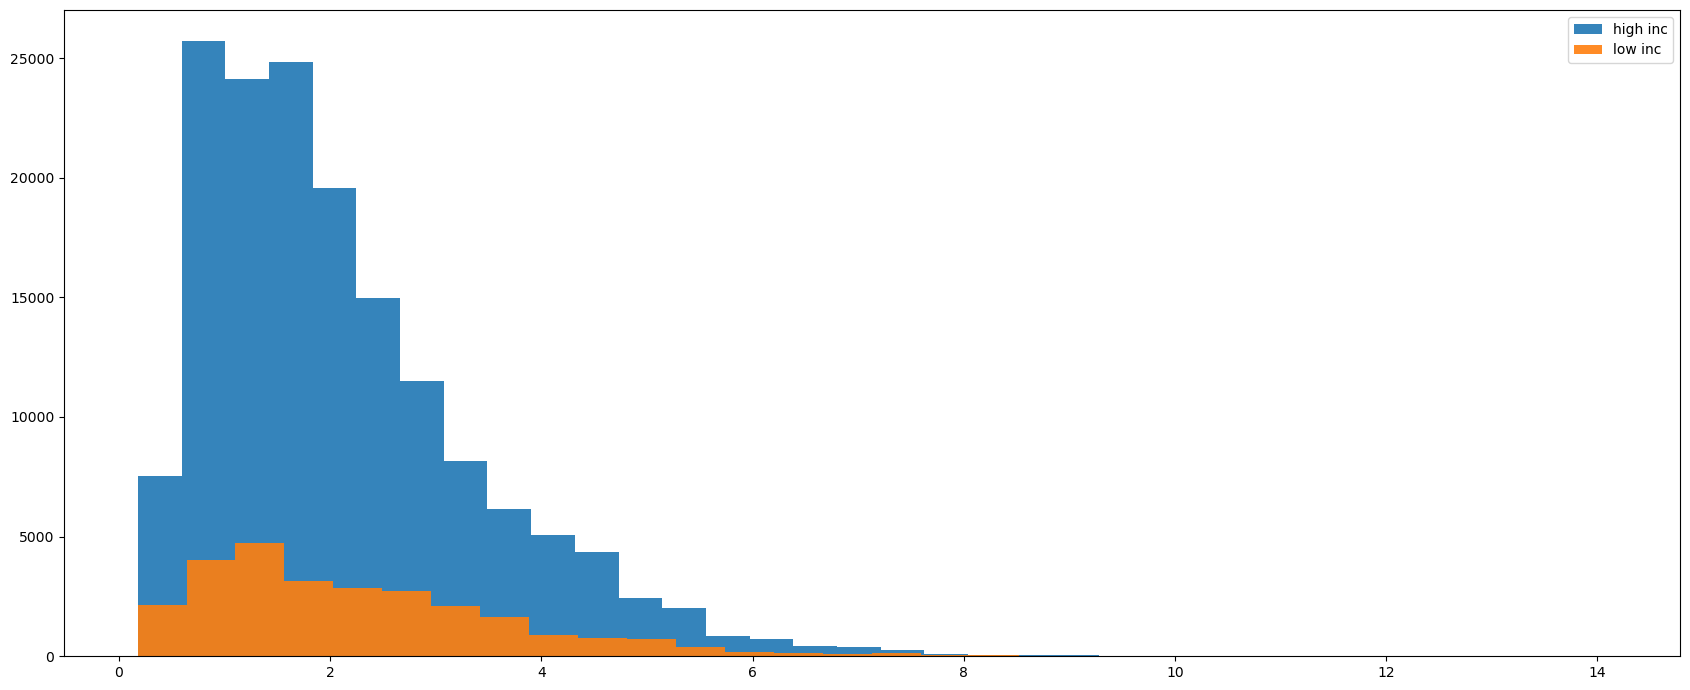

In [207]:
plt.hist(high_inc_25['distance/km'].values,bins=30,alpha=0.9,label='high inc')
plt.hist(low_inc_25['distance/km'].values,bins=30,alpha=0.9,label='low inc')
plt.legend()
plt.show()

---------------

# Regression Analysis

### Correlation

In [208]:
Rides_tract_start_c = median_inc_ct_Viz.merge(Rides_tract_start,right_on='GEOID',left_on='GEOID')
Rides_tract_start_c  = Rides_tract_start_c[['GEOID','Median Income','speed','distance/km','Activity Density','duration']]
Rides_tract_start_c ['log Income'] = np.log(Rides_tract_start_c ['Median Income'])
Rides_tract_start_c ['log speed'] = np.log(Rides_tract_start_c ['speed'])
Rides_tract_start_c ['log distance'] = np.log(Rides_tract_start_c['distance/km'])
Rides_tract_start_c ['log duration'] = np.log(Rides_tract_start_c ['duration'])
Rides_tract_start_c ['log Activity Density'] = np.log(Rides_tract_start_c ['Activity Density'])
Rides_tract_start_c.rename(columns={'Median Income':'income','Activity Density':'activitydensity'}, inplace=True)

In [209]:
commuter_tract_start_c = median_inc_ct_Viz.merge(commuter_tract_start,right_on='GEOID',left_on='GEOID')
commuter_tract_start_c = commuter_tract_start_c.merge(bikeshare,right_on='GEOID',left_on='GEOID')
commuter_tract_start_c = commuter_tract_start_c[['GEOID','Median Income','OBJECTID','speed','distance/km','Activity Density','duration']]
commuter_tract_start_c['log_Income'] = np.log(commuter_tract_start_c['Median Income'])
commuter_tract_start_c['log_speed'] = np.log(commuter_tract_start_c['speed'])
commuter_tract_start_c['log_distance'] = np.log(commuter_tract_start_c['distance/km'])
commuter_tract_start_c['log_duration'] = np.log(commuter_tract_start_c['duration'])
commuter_tract_start_c['log_Activity_Density'] = np.log(commuter_tract_start_c['Activity Density'])
commuter_tract_start_c['log_infrastructure'] = np.log(commuter_tract_start_c['OBJECTID'])
commuter_tract_start_c.rename(columns={'Median Income':'income','Activity Density':'activitydensity', 'distance/km':'distance', 'OBJECTID':'infrastructure'}, inplace=True)
commuter_tract_start_c

GEOID    income  infrastructure      speed  distance  \
0    11001004001  153650.0               2  11.722740  1.959089   
1    11001004002  154792.0               2  11.541538  1.896871   
2    11001003600  107610.0               2  12.637866  2.309042   
3    11001004201  132386.0               1  11.762406  1.549387   
4    11001004202  105449.0               1  10.521677  1.432854   
..           ...       ...             ...        ...       ...   
146  11001006900  178611.0               3  11.118119  2.080021   
147  11001009508   58250.0               1  11.487942  3.516332   
148  11001009801   13510.0               1  13.050765  1.655910   
149  11001002801   62323.0               1  12.831062  2.889878   
150  11001002802   72582.0               1  12.941075  2.690197   

     activitydensity   duration  log_Income  log_speed  log_distance  \
0           0.016385  10.405622   11.942433   2.461531      0.672480   
1           0.043835  10.465197   11.949838   2.445953      0.640206   
2           0.016154  11.329093   11.586269   2.536698      0.836833   
3           0.058539   8.384071   11.793477   2.464908      0.437859   
4           0.020246   8.538285   11.565983   2.353438      0.359669   
..               ...        ...         ...        ...           ...   
146         0.011681  11.332997   12.092966   2.408576      0.732378   
147         0.000429  17.532809   10.972499   2.441298      1.257418   
148         0.000176   8.026754    9.511185   2.568847      0.504351   
149         0.017986  13.856727   11.040086   2.551869      1.061214   
150         0.009652  13.082852   11.192472   2.560406      0.989614   

     log_duration  log_Activity_Density  log_infrastructure  
0        2.342346             -4.111376            0.693147  
1        2.348055             -3.127333            0.693147  
2        2.427374             -4.125572            0.693147  
3        2.126334             -2.838056            0.000000  
4        2.144560             -3.899798            0.000000  
..            ...                   ...                 ...  
146      2.427719             -4.449798            1.098612  
147      2.864074             -7.753542            0.000000  
148      2.082780             -8.644021            0.000000  
149      2.628771             -4.018153            0.000000  
150      2.571302             -4.640602            0.000000  

[151 rows x 13 columns]

In [210]:
corr_allrides = Rides_tract_start_c.corr()

In [211]:
corr_commuter = commuter_tract_start_c.corr()

<AxesSubplot: >

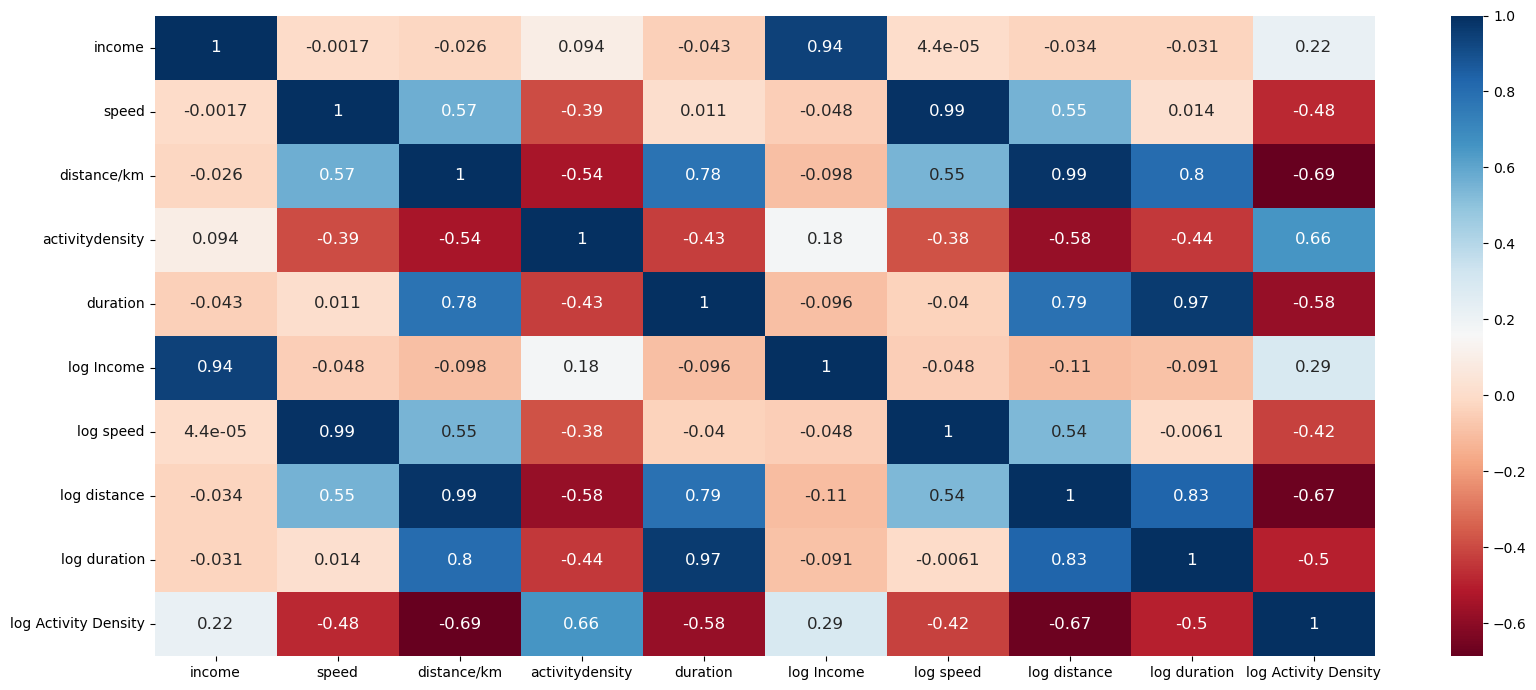

In [212]:
sns.heatmap(corr_allrides, cmap="RdBu", annot=True, annot_kws={"size":12})

<AxesSubplot: >

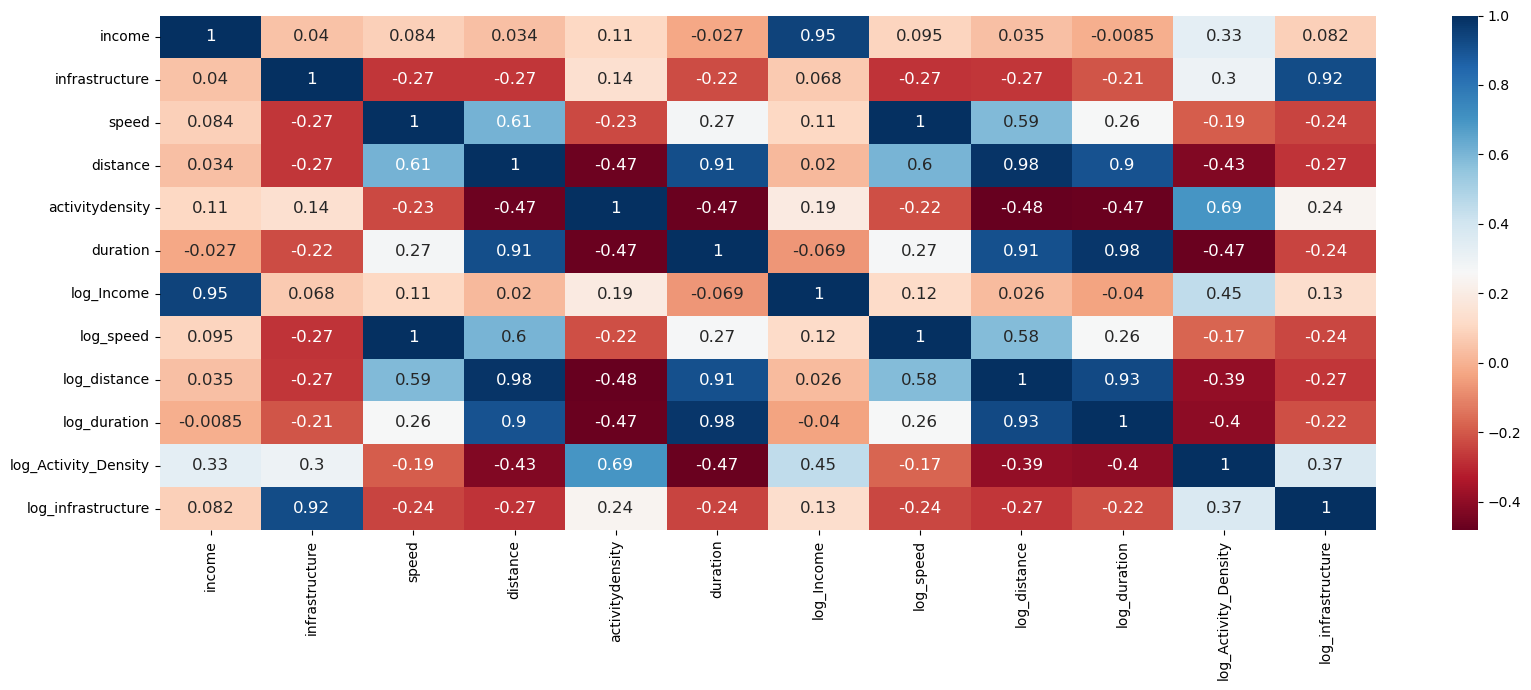

In [213]:
sns.heatmap(corr_commuter, cmap="RdBu", annot=True, annot_kws={"size":12})

## Linear regression analysis

In [214]:
commuter_tract_start_c['income_stand']=(commuter_tract_start_c['income']-commuter_tract_start_c['income'].mean())/commuter_tract_start_c['income'].std()
commuter_tract_start_c['activitydensity_stand']=(commuter_tract_start_c['activitydensity']-commuter_tract_start_c['activitydensity'].mean())/commuter_tract_start_c['activitydensity'].std()
commuter_tract_start_c['duration_stand']=(commuter_tract_start_c['duration']-commuter_tract_start_c['duration'].mean())/commuter_tract_start_c['duration'].std()
commuter_tract_start_c['distance_stand']=(commuter_tract_start_c['distance']-commuter_tract_start_c['distance'].mean())/commuter_tract_start_c['distance'].std()
commuter_tract_start_c['speed_stand']=(commuter_tract_start_c['speed']-commuter_tract_start_c['speed'].mean())/commuter_tract_start_c['speed'].std()
commuter_tract_start_c['infra_stand']=(commuter_tract_start_c['infrastructure']-commuter_tract_start_c['infrastructure'].mean())/commuter_tract_start_c['infrastructure'].std()

In [215]:
commuter_tract_start_c

GEOID    income  infrastructure      speed  distance  \
0    11001004001  153650.0               2  11.722740  1.959089   
1    11001004002  154792.0               2  11.541538  1.896871   
2    11001003600  107610.0               2  12.637866  2.309042   
3    11001004201  132386.0               1  11.762406  1.549387   
4    11001004202  105449.0               1  10.521677  1.432854   
..           ...       ...             ...        ...       ...   
146  11001006900  178611.0               3  11.118119  2.080021   
147  11001009508   58250.0               1  11.487942  3.516332   
148  11001009801   13510.0               1  13.050765  1.655910   
149  11001002801   62323.0               1  12.831062  2.889878   
150  11001002802   72582.0               1  12.941075  2.690197   

     activitydensity   duration  log_Income  log_speed  log_distance  \
0           0.016385  10.405622   11.942433   2.461531      0.672480   
1           0.043835  10.465197   11.949838   2.445953      0.640206   
2           0.016154  11.329093   11.586269   2.536698      0.836833   
3           0.058539   8.384071   11.793477   2.464908      0.437859   
4           0.020246   8.538285   11.565983   2.353438      0.359669   
..               ...        ...         ...        ...           ...   
146         0.011681  11.332997   12.092966   2.408576      0.732378   
147         0.000429  17.532809   10.972499   2.441298      1.257418   
148         0.000176   8.026754    9.511185   2.568847      0.504351   
149         0.017986  13.856727   11.040086   2.551869      1.061214   
150         0.009652  13.082852   11.192472   2.560406      0.989614   

     log_duration  log_Activity_Density  log_infrastructure  income_stand  \
0        2.342346             -4.111376            0.693147      1.014099   
1        2.348055             -3.127333            0.693147      1.037116   
2        2.427374             -4.125572            0.693147      0.086154   
3        2.126334             -2.838056            0.000000      0.585519   
4        2.144560             -3.899798            0.000000      0.042599   
..            ...                   ...                 ...           ...   
146      2.427719             -4.449798            1.098612      1.517193   
147      2.864074             -7.753542            0.000000     -0.908705   
148      2.082780             -8.644021            0.000000     -1.810448   
149      2.628771             -4.018153            0.000000     -0.826613   
150      2.571302             -4.640602            0.000000     -0.619841   

     activitydensity_stand  duration_stand  distance_stand  speed_stand  \
0                 0.145877       -0.764524       -0.688100    -0.081115   
1                 1.491118       -0.745056       -0.773170    -0.217869   
2                 0.134558       -0.462736       -0.209617     0.609541   
3                 2.211774       -1.425162       -1.248278    -0.051178   
4                 0.335086       -1.374765       -1.407610    -0.987569   
..                     ...             ...             ...          ...   
146              -0.084672       -0.461461       -0.522752    -0.537428   
147              -0.636097        1.564622        1.441086    -0.258319   
148              -0.648498       -1.541932       -1.102631     0.921161   
149               0.224336        0.363288        0.584549     0.755348   
150              -0.184111        0.110387        0.311528     0.838376   

     infra_stand  
0      -0.065696  
1      -0.065696  
2      -0.065696  
3      -0.616816  
4      -0.616816  
..           ...  
146     0.485424  
147    -0.616816  
148    -0.616816  
149    -0.616816  
150    -0.616816  

[151 rows x 19 columns]

### standardized

In [216]:
lm = smf.ols(formula='activitydensity~income', data = commuter_tract_start_c).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        activitydensity   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.711
Date:                Mon, 19 Dec 2022   Prob (F-statistic):              0.193
Time:                        07:33:13   Log-Likelihood:                 374.79
No. Observations:                 151   AIC:                            -745.6
Df Residuals:                     149   BIC:                            -739.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.004      2.314      0.0

In [217]:
commuter_tract_start_c['predicted_ad']=lm.predict()

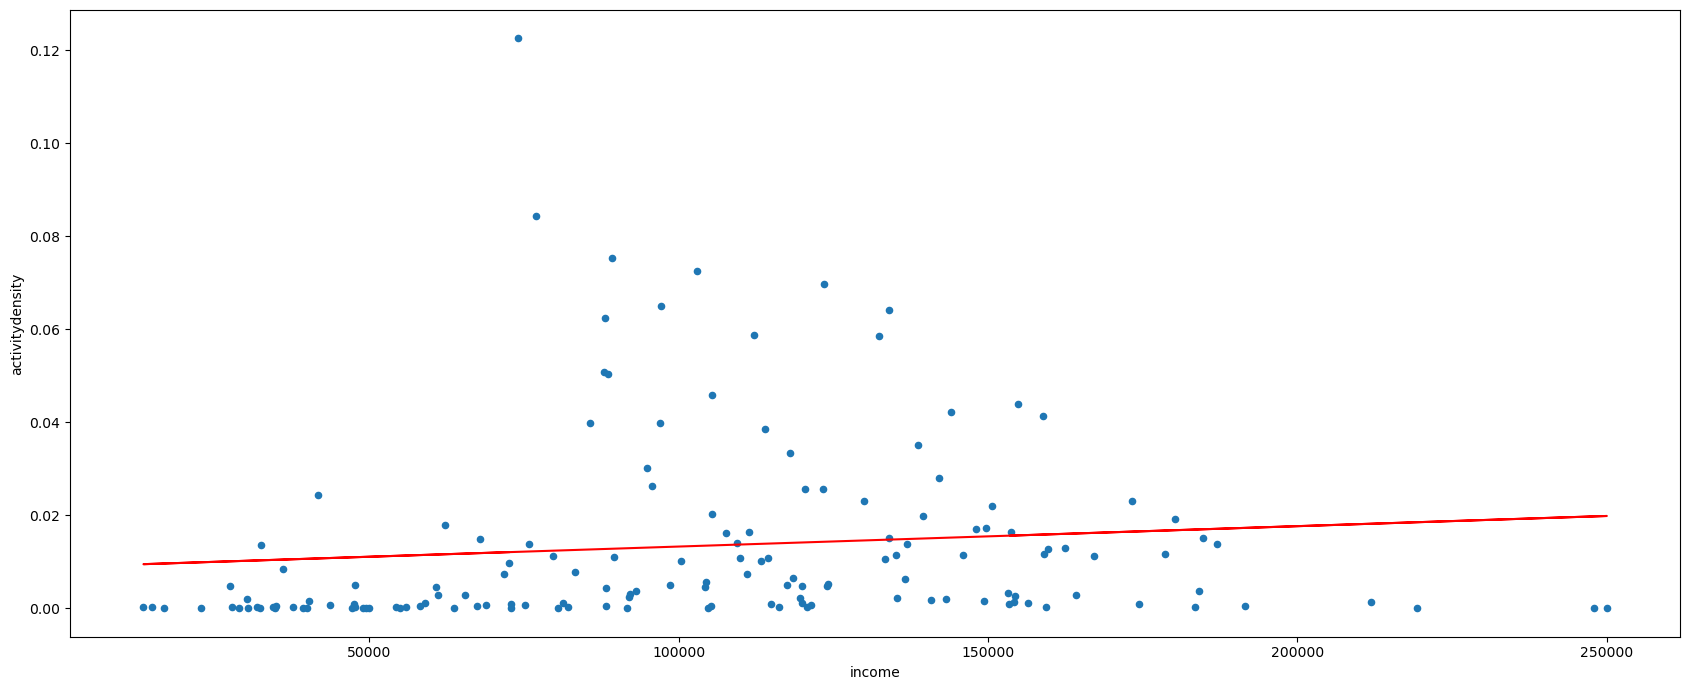

In [218]:
fig, ax = plt.subplots()
commuter_tract_start_c.plot(ax=ax,x='income',y='activitydensity',kind='scatter')
ax.plot(commuter_tract_start_c['income'],commuter_tract_start_c['predicted_ad'],'r-');

In [219]:
lm = smf.ols(formula='activitydensity_stand~income_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.011
Model:                               OLS   Adj. R-squared:                  0.005
Method:                    Least Squares   F-statistic:                     1.711
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):              0.193
Time:                           07:33:16   Log-Likelihood:                -212.90
No. Observations:                    151   AIC:                             429.8
Df Residuals:                        149   BIC:                             435.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.42

In [220]:
lm = smf.ols(formula='activitydensity_stand~duration_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.221
Model:                               OLS   Adj. R-squared:                  0.216
Method:                    Least Squares   F-statistic:                     42.31
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           1.11e-09
Time:                           07:33:42   Log-Likelihood:                -194.89
No. Observations:                    151   AIC:                             393.8
Df Residuals:                        149   BIC:                             399.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [221]:
lm = smf.ols(formula='activitydensity_stand~infra_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.021
Model:                               OLS   Adj. R-squared:                  0.014
Method:                    Least Squares   F-statistic:                     3.134
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):             0.0787
Time:                           07:33:43   Log-Likelihood:                -212.19
No. Observations:                    151   AIC:                             428.4
Df Residuals:                        149   BIC:                             434.4
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.429e-

In [222]:
lm = smf.ols(formula='activitydensity_stand~distance_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.217
Model:                               OLS   Adj. R-squared:                  0.211
Method:                    Least Squares   F-statistic:                     41.23
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           1.71e-09
Time:                           07:33:44   Log-Likelihood:                -195.32
No. Observations:                    151   AIC:                             394.6
Df Residuals:                        149   BIC:                             400.7
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [223]:
lm = smf.ols(formula='activitydensity_stand~speed_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.053
Model:                               OLS   Adj. R-squared:                  0.047
Method:                    Least Squares   F-statistic:                     8.316
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):            0.00451
Time:                           07:33:44   Log-Likelihood:                -209.66
No. Observations:                    151   AIC:                             423.3
Df Residuals:                        149   BIC:                             429.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.429e-

In [224]:
lm = smf.ols(formula='activitydensity_stand~income_stand+speed_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.069
Model:                               OLS   Adj. R-squared:                  0.056
Method:                    Least Squares   F-statistic:                     5.468
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):            0.00512
Time:                           07:33:45   Log-Likelihood:                -208.38
No. Observations:                    151   AIC:                             422.8
Df Residuals:                        148   BIC:                             431.8
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.42

In [225]:
lm = smf.ols(formula='activitydensity_stand~income_stand+infra_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.031
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     2.351
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):             0.0988
Time:                           07:33:45   Log-Likelihood:                -211.40
No. Observations:                    151   AIC:                             428.8
Df Residuals:                        148   BIC:                             437.8
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.42

In [226]:
lm = smf.ols(formula='activitydensity_stand~income_stand+duration_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.230
Model:                               OLS   Adj. R-squared:                  0.220
Method:                    Least Squares   F-statistic:                     22.10
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           3.98e-09
Time:                           07:33:46   Log-Likelihood:                -194.03
No. Observations:                    151   AIC:                             394.1
Df Residuals:                        148   BIC:                             403.1
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [227]:
lm = smf.ols(formula='activitydensity_stand~income_stand+distance_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.232
Model:                               OLS   Adj. R-squared:                  0.221
Method:                    Least Squares   F-statistic:                     22.32
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           3.36e-09
Time:                           07:33:46   Log-Likelihood:                -193.85
No. Observations:                    151   AIC:                             393.7
Df Residuals:                        148   BIC:                             402.8
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [228]:
lm = smf.ols(formula='activitydensity_stand~income_stand+distance_stand+speed_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.235
Model:                               OLS   Adj. R-squared:                  0.220
Method:                    Least Squares   F-statistic:                     15.06
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           1.34e-08
Time:                           07:33:46   Log-Likelihood:                -193.52
No. Observations:                    151   AIC:                             395.0
Df Residuals:                        147   BIC:                             407.1
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [229]:
lm = smf.ols(formula='activitydensity_stand~income_stand+distance_stand+duration_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.241
Model:                               OLS   Adj. R-squared:                  0.225
Method:                    Least Squares   F-statistic:                     15.53
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           7.98e-09
Time:                           07:33:47   Log-Likelihood:                -192.98
No. Observations:                    151   AIC:                             394.0
Df Residuals:                        147   BIC:                             406.0
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [230]:
lm = smf.ols(formula='activitydensity_stand~income_stand+speed_stand+duration_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.243
Model:                               OLS   Adj. R-squared:                  0.228
Method:                    Least Squares   F-statistic:                     15.75
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           6.23e-09
Time:                           07:33:47   Log-Likelihood:                -192.72
No. Observations:                    151   AIC:                             393.4
Df Residuals:                        147   BIC:                             405.5
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

In [231]:
lm = smf.ols(formula='activitydensity_stand~income_stand+speed_stand+duration_stand+distance_stand+infra_stand', data = commuter_tract_start_c).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     activitydensity_stand   R-squared:                       0.243
Model:                               OLS   Adj. R-squared:                  0.217
Method:                    Least Squares   F-statistic:                     9.325
Date:                   Mon, 19 Dec 2022   Prob (F-statistic):           1.01e-07
Time:                           07:33:48   Log-Likelihood:                -192.71
No. Observations:                    151   AIC:                             397.4
Df Residuals:                        145   BIC:                             415.5
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

### log

In [290]:
lm = smf.ols(formula='log_Activity_Density~log_Income', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.107
Model:                              OLS   Adj. R-squared:                  0.102
Method:                   Least Squares   F-statistic:                     20.96
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           8.86e-06
Time:                          23:39:52   Log-Likelihood:                -423.05
No. Observations:                   177   AIC:                             850.1
Df Residuals:                       175   BIC:                             856.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.1557      3.848

In [247]:
lm = smf.ols(formula='log_Activity_Density~log_duration', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.105
Model:                              OLS   Adj. R-squared:                  0.100
Method:                   Least Squares   F-statistic:                     20.48
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           1.11e-05
Time:                          23:13:05   Log-Likelihood:                -423.27
No. Observations:                   177   AIC:                             850.5
Df Residuals:                       175   BIC:                             856.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.3604     

In [248]:
lm = smf.ols(formula='log_Activity_Density~log_speed', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.156
Model:                              OLS   Adj. R-squared:                  0.151
Method:                   Least Squares   F-statistic:                     32.33
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           5.36e-08
Time:                          23:13:16   Log-Likelihood:                -418.07
No. Observations:                   177   AIC:                             840.1
Df Residuals:                       175   BIC:                             846.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2901      3.321

In [249]:
lm = smf.ols(formula='log_Activity_Density~log_distance', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.196
Model:                              OLS   Adj. R-squared:                  0.191
Method:                   Least Squares   F-statistic:                     42.58
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           7.06e-10
Time:                          23:13:24   Log-Likelihood:                -413.79
No. Observations:                   177   AIC:                             831.6
Df Residuals:                       175   BIC:                             837.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.3203     

## Multiple regression analysis

In [244]:
lm = smf.ols(formula='log_Activity_Density~log_Income+log_distance', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.296
Model:                              OLS   Adj. R-squared:                  0.288
Method:                   Least Squares   F-statistic:                     36.60
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           5.40e-14
Time:                          23:11:40   Log-Likelihood:                -401.99
No. Observations:                   177   AIC:                             810.0
Df Residuals:                       174   BIC:                             819.5
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -20.4262     

In [250]:
lm = smf.ols(formula='log_Activity_Density~log_Income+log_speed', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.275
Model:                              OLS   Adj. R-squared:                  0.266
Method:                   Least Squares   F-statistic:                     32.96
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           7.25e-13
Time:                          23:14:04   Log-Likelihood:                -404.63
No. Observations:                   177   AIC:                             815.3
Df Residuals:                       174   BIC:                             824.8
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5494      4.549

In [251]:
lm = smf.ols(formula='log_Activity_Density~log_Income+log_duration', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.201
Model:                              OLS   Adj. R-squared:                  0.191
Method:                   Least Squares   F-statistic:                     21.83
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           3.49e-09
Time:                          23:14:15   Log-Likelihood:                -413.26
No. Observations:                   177   AIC:                             832.5
Df Residuals:                       174   BIC:                             842.0
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -15.7375     

In [252]:
lm = smf.ols(formula='log_Activity_Density~log_Income+log_duration+log_speed', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.337
Model:                              OLS   Adj. R-squared:                  0.325
Method:                   Least Squares   F-statistic:                     29.30
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           2.28e-15
Time:                          23:15:06   Log-Likelihood:                -396.71
No. Observations:                   177   AIC:                             801.4
Df Residuals:                       173   BIC:                             814.1
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2748     

In [254]:
lm = smf.ols(formula='log_Activity_Density~log_distance+log_speed+log_Income', data = commuter_tract_start_c).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     log_Activity_Density   R-squared:                       0.339
Model:                              OLS   Adj. R-squared:                  0.327
Method:                   Least Squares   F-statistic:                     29.52
Date:                  Sat, 17 Dec 2022   Prob (F-statistic):           1.83e-15
Time:                          23:15:46   Log-Likelihood:                -396.48
No. Observations:                   177   AIC:                             801.0
Df Residuals:                       173   BIC:                             813.7
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.4118     

------------